# Big Data and Data Mining Project Code
## 202114855 - Tahia Tabassum

In [ ]:
# Importing libraries 

import pandas as pd
import numpy as np
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
from datetime import time
from dateutil.relativedelta import relativedelta
from sklearn.cluster import KMeans
from collections import Counter

from datetime import timedelta
from imblearn.under_sampling import RandomUnderSampler

from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

from imblearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import datetime


from sklearn.compose import make_column_selector as mcs
from urllib.request import UnknownHandler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from matplotlib import pyplot
import random
pd.set_option('max_rows', 2000)
from tabulate import tabulate

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif, mutual_info_classif

from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE


Reading in the files

In [ ]:
accident = pd.read_csv('Road Safety Data - Accidents 2019.csv')
casualty = pd.read_csv('Road Safety Data - Casualties 2019.csv')
vehicle = pd.read_csv('Road Safety Data- Vehicles 2019.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


##### Creating a dataframe of vehicle types along with code

In [ ]:
labels = ['Pedal cycle', 'Motorcycle 50cc and under', 'Motorcycle 125cc and under','Motorcycle over 125cc and up to 500cc','Motorcycle over 500cc',
 'Taxi/Private hire car','Car','Minibus (8 - 16 passenger seats)','Bus or coach (17 or more pass seats)','Ridden horse','Agricultural vehicle','Tram',
 'Van / Goods 3.5 tonnes mgw or under','Goods over 3.5t. and under 7.5t','Goods 7.5 tonnes mgw and over','Mobility scooter','Electric motorcycle','Other vehicle',
 'Motorcycle - unknown cc','Goods vehicle - unknown weight','Data missing or out of range']
codes = [1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98, -1]

vehicle_types = pd.DataFrame(list(zip(codes, labels)),  columns=['code', 'label'])

In [ ]:
code = [1,2,3,4,5,6,7]


### Missing Value Functions

- When nan_fill is set to True, the cells with -1 are replaced with NaN.
- When neg_fill is set to True, the cells with NaN are filled with -1.

In [ ]:
def view_nan(data, nan_fill = False, neg_fill = False):
  
  # Setting this to true replaces all -1s with NaN 
  if nan_fill ==True:
    data = data.replace(-1, np.NaN)
    print(data.isnull().sum()) 

  #This does the reverse and makes all NaNs -1
  elif neg_fill ==True:
    
    data = data.replace(np.NaN, -1)
    print(data.isnull().sum()) 

  else:
    # This doesn't modify the data
    print(data.isnull().sum())

  #missing value heatmap
  
  colours = ['whitesmoke', 'red'] 

  plt.figure(figsize=(10, 10))
  sns.set(font_scale = 1.2)

  sns.heatmap(data.isnull(), cmap=sns.color_palette(colours))

  plt.title('Missing Values Heatmap')
  plt.savefig('missing_values.png')
  
  return data 



This function imputes the data with the median from a group of cells which have the same value as its neighbouring rows

In [ ]:
'''
This function returns a list of columns to use when imputing nan values
The number of nan values in the selected column are checked (to avoid columns that are all nan)
The features are then sorted with the column with the least number of nans being placed first 
nan_imputer will therefore try to match this column at the very end (if all other columns are null) since there is a high chance this one isn't
'''

def nan_imputer_features(df, nan_col=None):
  features = {}
  if nan_col != None:
    df = df[df[nan_col].isna()==True]
    
  cols = list(df.columns)
  #ignoring accident index etc. columns
  cols = cols[3:]
  for col in cols:
    #making a dictionary of column names and the number of values in each column
    if (df[col].isna().sum() != len(df)) & (col!=nan_col):    
      features[ col] = df[col].isna().sum()
      #returning a list of column names, sorted according to missing values
  f =sorted(features, key=features.__getitem__)
  return f



In [ ]:
def nan_imputer(df, nan_col, f = None):
  if f==None:
    feature_cols = nan_imputer_features(df, nan_col)
  else: 
    #features from nan_imputer_features are used here
    feature_cols = f
  while len(df[df[nan_col].isna()==True])>0:
    #grouping the selected feature columns to find a value to impute with
    df[nan_col].fillna(df.groupby(feature_cols)[nan_col].transform('median'), inplace=True)
    feature_cols.pop(len(feature_cols)-1)
  return df


In [ ]:
f = lambda x: x.median() if np.issubdtype(x.dtype, np.number) else x.mode().iloc[0]
df = df.fillna(df.groupby('make').transform(f))
print (df)

This function shows the percentage of missing values in a column when the dataframe is grouped by values in another column

In [ ]:
def null_percent(df, col1, col2):
  subset = df.groupby(col1)[col2].count().reset_index()
  subset['Total_Values'] = (df.groupby(col1).size().reset_index())[0]
  subset['Percentage_Missing'] = (subset['Total_Values']- subset[col2])*100 /subset['Total_Values']
  return subset

This function returns the rows which have null values in a specific column

In [ ]:
def null_rows(df, col):
  return df[df[col].isna()==True]

##### Rounding out any float values that occurred during imputation

In [ ]:
def df_round(df, cols=None):
  df_cols = list(df.columns)
  if cols!=None:
    for col in cols:
      df_cols.remove(col)
  df[df_cols] = df[df_cols].round()
  return df

###Summary Function
Provides a brief summary of the data

In [ ]:
def summary(data):
  view_nan(data)
  print(data.head())
  #summary of data
  print(data.describe())
  for col in data.columns:
    if len(data[col].unique())<=30:
      #unique values are returned (unless the column is continuous or has too many unique values)
      print ('The unique values of', col, 'are', data[col].unique())
    else:
      print('Too many unique values.')

## Date Time Functions

In [ ]:
def date_converter(data, col):
  data[col] = pd.to_datetime(data[col], infer_datetime_format=True)
  data[col] =  data[col].dt.date
  return data

def time_converter(data, time, colon= False):
  new_times = []
  if colon ==True:
    for time_str in data[time]:
      h, m = time_str.split(':')
      m = m/60
      new_times.append(h+m)
      data['converted_time_' +time] = new_times
  else:
      data[time] = pd.to_datetime(data[time], infer_datetime_format=True)
      data['converted_time_' +time] = [(time.hour+time.minute/60) for time in data[time]]


  return data






This function extracts a week's worth of data from the dataframe; there is also the option of specifying a time.

In [ ]:
#Given the start date and time, a week's worth of data will be returned
def week_extractor(df, sdate, time, date_col, time_col):
  if time !=None:
    sdate = pd.to_datetime(sdate)
    fdate = (sdate)+timedelta(days=7)
    week = df[(df[date_col]>= sdate) & (df['Date']<= fdate )]
    week.drop(week[(week[date_col] == sdate) & (week[time_col] <time)].index, inplace=True)
    week.drop(week[(week[date_col] == fdate) & (week[time_col] >time)].index, inplace=True)
  else:
    sdate = pd.to_datetime(sdate)
    fdate = (sdate)+timedelta(days=7)
    week = df[(df[date_col]>= sdate) & (df['Date']<= fdate )] 
  return week

In [ ]:
#given the start date, a week's worth of data will be returned for every month 
def week_extractor_every_month(startdate):
  d = []
  sdate = pd.to_datetime(startdate)
  for i in range(12):
    d.append(sdate)
    # adjusting for individual months - for example, if the start date is in february, 28 days will be added for the next month's week
    if sdate.month ==2:
      sdate = sdate+timedelta(days=30)
    elif (sdate.month == 3) | (sdate.month == 5) |(sdate.month == 8) | (sdate.month == 10) :
      sdate = sdate+timedelta(days=30)
    elif (sdate.month ==1) & (sdate.day==29):   
      sdate = sdate+timedelta(days=30)
    elif (sdate.month ==1) & (sdate.day==30):   
      sdate = sdate+timedelta(days=29)
    elif (sdate.month ==1) & (sdate.day==31):   
      sdate = sdate+timedelta(days=28)
    else:
      sdate = sdate+timedelta(days=31)
      
      
      

  return d


 ### Visualization functions

##### Line plot

In [ ]:
def lineplt(df,ind, col, val, fig_x, fig_y, title, xlabel, ylabel, mark=False, xticks=None, ticks = None):
  res = df.pivot(index=ind, columns=col, values=val)
  plt.figure(figsize = (fig_x,fig_y))
  x = sns.lineplot(data = res, markers=mark)
  if xticks!=None:
    x.set_xticks(ticks)
    x.set_xticklabels(xticks)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

##### Displot

In [ ]:
def displt(fig_x, fig_y, data, col_x, bwidth, pal, title, xlabel, ylabel, hue, col, rotate, multiple=None):
  sns.set_theme()
  plt.figure(figsize = (fig_x,fig_y))
  sns.displot(data, x=col_x, binwidth=bwidth, palette = pal, hue = hue, col = col)
  plt.title(title)
  plt.xticks(rotation=rotate)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

##### Barplot

In [ ]:
def barplt(fig_x, fig_y, df, col_x, col_y, pal, title, xlabel, ylabel, rotate, bins, hue):
  sns.set_theme()
  plt.figure(figsize = (fig_x,fig_y))
  plt.xticks(rotation=rotate)
  sns.barplot(data = df, x=col_x, y =col_y, palette = pal)
  plt.locator_params(axis='x', nbins=bins)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)




##### Boxplot

In [ ]:
def boxplt(fig_x, fig_y, title, df, x_col, y_col, rotate = 0):
  sns.set_theme()
  plt.figure(figsize=(fig_x,fig_y))
  plt.xticks(rotation=rotate)
  plt.title(title)
  sns.boxplot(data=df, x = x_col, y = y_col)


In [ ]:
def encoder(df_train, df_test=None, cols=None):
  if cols ==None:
    cols = df_train.columns
  enc = OneHotEncoder(handle_unknown='ignore')
  ct = ColumnTransformer(transformers= [('encoder', OneHotEncoder(handle_unknown='ignore'), cols)], remainder= 'passthrough')
  df_train = ct.fit_transform(df_train)
  if df_test!=None:
	  df_test = ct.transform(df_test)
  
  return df_train, df_test

##### daylight hours function

In [ ]:
def daylight_chart(df, title, color, xlabel, ylabel1, ylabel2, linex, liney):
  #Create combo chart
  fig, ax1 = plt.subplots(figsize=(10,6))
  #bar plot creation
  ax1.set_title(title, fontsize=12)

  sns.barplot(data = df.groupby(['Month', 'Month_Label']).size().reset_index(), x='Month_Label', y =0, color = color)
  plt.xticks(rotation=90)
  ax1.set_xlabel(xlabel, fontsize=12)
  ax1.set_ylabel(ylabel1, fontsize=12)
  #specify we want to share the same x-axis
  ax2 = ax1.twinx()
  #line plot creation
  ax2.set_ylabel(ylabel2, fontsize=12)
  ax2 = sns.lineplot(x=linex, y=liney, data = df.groupby(['Month', 'Month_Label']).mean().reset_index(), sort=False, color='red')
  #show plot
  plt.show()


##### Splitting the data intro features and output

In [ ]:
def split(data, split_size, rs, strat):
	X = data.iloc[:,:-1]
	y = (data.iloc[:,-1])
	# split into train and test sets
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=rs, stratify=strat)
	# summarize
	print('Train', X_train.shape, y_train.shape)
	print('Test', X_test.shape, y_test.shape)
	return X_train, X_test, y_train, y_test
 

##### function for selecting features

In [ ]:
def feature_select(function, X_train, X_test, y_train, predict_cols, k_value):
  # Perform the feature selection
  selector = SelectKBest(score_func=function, k=k_value)
  selector.fit(X_train[predict_cols], y_train)

  cols = selector.get_support(1)

  #X_train = selector.transform(X_train)
  #X_test = selector.transform(X_test)
  scores = selector.scores_
  # Use plt to plot the scores
  plt.bar(range(len(predict_cols)), scores)
  plt.xticks(range(len(predict_cols)), predict_cols, rotation='vertical')
  plt.show()
  return selector, X_train.iloc[:,cols]
  

##### function for selecting features

In [ ]:
def feature_select(function, X_train, X_test, y_train, predict_cols, k_value):
  # Perform the feature selection
  selector = SelectKBest(score_func=function, k=k_value)
  selector.fit(X_train[predict_cols], y_train)

  cols = selector.get_support(1)

  #X_train = selector.transform(X_train)
  #X_test = selector.transform(X_test)
  scores = selector.scores_
  # Use plt to plot the scores
  plt.bar(range(len(predict_cols)), scores)
  plt.xticks(range(len(predict_cols)), predict_cols, rotation='vertical')
  plt.show()
  return selector, X_train.iloc[:,cols]
  

##### function for plotting

In [ ]:
def score_plot(selector, predict_cols):
  cols = selector.get_support(1)

  scores_all = selector.scores_
  # Use plt to plot the scores
  plt.figure(figsize=(15,10))
  plt.bar(range(len(predict_cols)), scores_all)
  plt.xticks(range(len(predict_cols)), predict_cols, rotation='vertical')
  plt.show()


  return 
  

##### smote function for balancing

In [ ]:
def balance(X_train, y_train, over_ss, under_ss):
  if over_ss!=None:
    over = SMOTE(random_state=1, sampling_strategy = over_ss)
    X_train, y_train = over.fit_resample(X_train, y_train)
  if under_ss != None:
    under = RandomUnderSampler(random_state=1, sampling_strategy=under_ss)
    X_train, y_train = under.fit_resample(X_train, y_train)

  return X_train, y_train

##### function for replacing the last column with the output variable

In [ ]:
def replace_y(df, col):
  y = df.pop(col)
  df.insert(len(df.columns), col, y)
  return df

## Vehicle Dataset - Preprocessing



### Cleaning

#### Adding a column of vehicle types

In [ ]:
# adding a column of vehicle types to the dataframe
vehicle = vehicle.merge(vehicle_types, how ='inner', left_on ='Vehicle_Type', right_on='code')
labels = vehicle.pop('label')
  
vehicle.insert(2, 'Label', labels)
vehicle.pop('code')

0          9
1          9
2          9
3          9
4          9
          ..
216376    18
216377    18
216378    18
216379    18
216380    18
Name: code, Length: 216381, dtype: int64

#### Summary and missing values

Accident_Index                      0
Vehicle_Reference                   0
Label                               0
Vehicle_Type                        0
Towing_and_Articulation             0
Vehicle_Manoeuvre                   0
Vehicle_Location-Restricted_Lane    0
Junction_Location                   0
Skidding_and_Overturning            0
Hit_Object_in_Carriageway           0
Vehicle_Leaving_Carriageway         0
Hit_Object_off_Carriageway          0
1st_Point_of_Impact                 0
Was_Vehicle_Left_Hand_Drive?        0
Journey_Purpose_of_Driver           0
Sex_of_Driver                       0
Age_of_Driver                       0
Age_Band_of_Driver                  0
Engine_Capacity_(CC)                0
Propulsion_Code                     0
Age_of_Vehicle                      0
Driver_IMD_Decile                   0
Driver_Home_Area_Type               0
Vehicle_IMD_Decile                  0
dtype: int64
  Accident_Index  Vehicle_Reference Label  Vehicle_Type  \
0  2019010128300

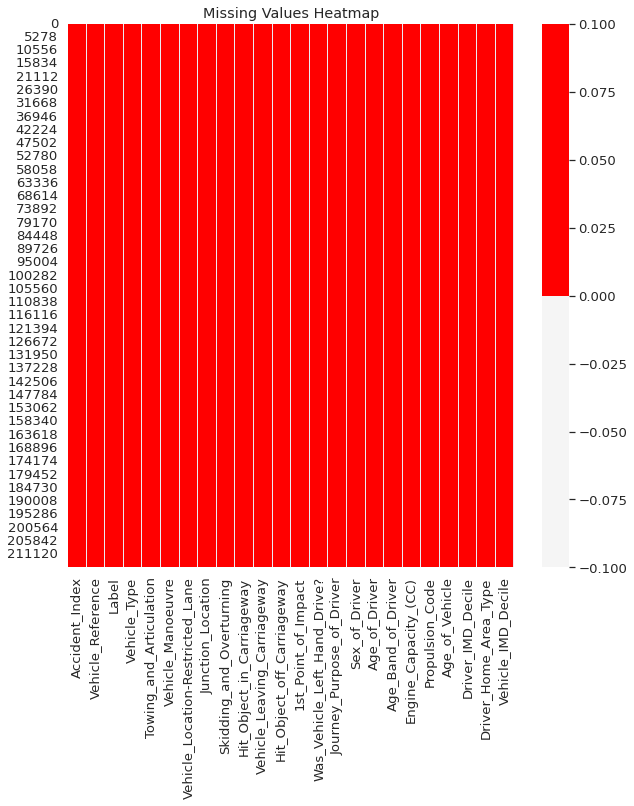

In [ ]:
summary(vehicle)

Looking at the dataframe with all -1 replaced by nan

Accident_Index                          0
Vehicle_Reference                       0
Label                                   0
Vehicle_Type                          309
Towing_and_Articulation              4527
Vehicle_Manoeuvre                   13063
Vehicle_Location-Restricted_Lane    12746
Junction_Location                    9531
Skidding_and_Overturning            13361
Hit_Object_in_Carriageway           13057
Vehicle_Leaving_Carriageway         12916
Hit_Object_off_Carriageway          12271
1st_Point_of_Impact                  6681
Was_Vehicle_Left_Hand_Drive?        11051
Journey_Purpose_of_Driver              58
Sex_of_Driver                           1
Age_of_Driver                       29756
Age_Band_of_Driver                  29756
Engine_Capacity_(CC)                54958
Propulsion_Code                     54447
Age_of_Vehicle                      61755
Driver_IMD_Decile                   42385
Driver_Home_Area_Type               44869
Vehicle_IMD_Decile                

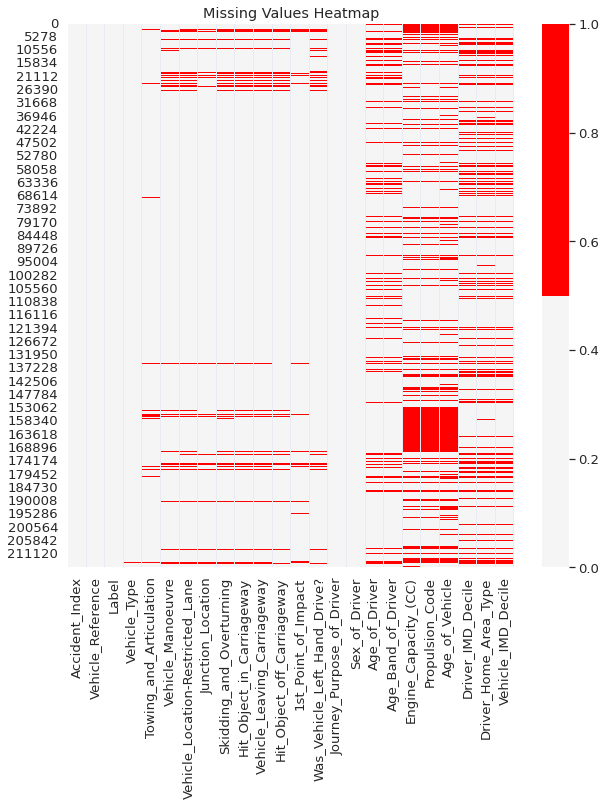

In [ ]:
#many missing values have been replaced by -1 in the dataframe
vehicle = view_nan(vehicle, True, False)

##### Missing value dataframe by vehicle type

This dataframe represents the number of missing values in each column according to vehicle type:

In [ ]:
vehicle_type_null=vehicle.groupby(['Label', 'Vehicle_Type']).count()
vehicle_type_null['Total_Values'] = list((vehicle.groupby(['Label', 'Vehicle_Type']).size().reset_index())[0])

temp = vehicle_type_null.pop('Total_Values')
  
vehicle_type_null.insert(0, 'Total_Values', temp)
vehicle_type_null.pop('Accident_Index')
vehicle_type_null.pop('Vehicle_Reference')

cols = list(vehicle_type_null.columns)
cols.pop(0)
cols

vehicle_type_null[cols] = -vehicle_type_null[cols].sub(vehicle_type_null['Total_Values'], axis=0)

vehicle_type_null = vehicle_type_null.reset_index()
vehicle_type_null

Label  Vehicle_Type  Total_Values  \
0                    Agricultural vehicle          17.0           423   
1    Bus or coach (17 or more pass seats)          11.0          3902   
2                                     Car           9.0        152686   
3                     Electric motorcycle          23.0            65   
4           Goods 7.5 tonnes mgw and over          21.0          3357   
5         Goods over 3.5t. and under 7.5t          20.0           982   
6          Goods vehicle - unknown weight          98.0           890   
7        Minibus (8 - 16 passenger seats)          10.0           405   
8                        Mobility scooter          22.0           250   
9                 Motorcycle - unknown cc          97.0           415   
10             Motorcycle 125cc and under           3.0          8053   
11              Motorcycle 50cc and under           2.0          1489   
12  Motorcycle over 125cc and up to 500cc           4.0          2119   
13                  Motorcycle over 500cc           5.0          5228   
14                          Other vehicle          90.0          1005   
15                            Pedal cycle           1.0         17437   
16                           Ridden horse          16.0            65   
17                  Taxi/Private hire car           8.0          4696   
18                                   Tram          18.0            26   
19    Van / Goods 3.5 tonnes mgw or under          19.0         12579   

    Towing_and_Articulation  Vehicle_Manoeuvre  \
0                         1                  3   
1                        62                156   
2                      1789               7962   
3                         1                  7   
4                        28                 39   
5                        21                 52   
6                        42                 79   
7                         5                 27   
8                         6                 10   
9                        20                 36   
10                       87                918   
11                       18                 65   
12                        8                 85   
13                       17                159   
14                       14                 27   
15                     2023               1902   
16                        1                  1   
17                       67                745   
18                        0                  0   
19                      196                711   

    Vehicle_Location-Restricted_Lane  Junction_Location  \
0                                  3                  2   
1                                163                114   
2                               7728               5676   
3                                  5                  5   
4                                 37                 21   
5                                 51                 37   
6                                 78                 51   
7                                 25                 15   
8                                 10                  5   
9                                 36                 34   
10                               908                695   
11                                63                 58   
12                                88                 74   
13                               149                118   
14                                23                 15   
15                              1884               1505   
16                                 1                  1   
17                               731                555   
18                                 0                  0   
19                               686                507   

    Skidding_and_Overturning  Hit_Object_in_Carriageway  \
0                          4                          3   
1                        171                        168   
2                       8081      

##### Missing value dataframe percentage by vehicle type

This dataframe represents the percentage of missing values in each column according to vehicle type:

In [ ]:
vehicle_type_percent_null = vehicle_type_null.copy()
vehicle_type_percent_null[cols] = (vehicle_type_percent_null[cols].div(vehicle_type_percent_null['Total_Values'], axis = 0))*100
vehicle_type_percent_null

Label  Vehicle_Type  Total_Values  \
0                    Agricultural vehicle          17.0           423   
1    Bus or coach (17 or more pass seats)          11.0          3902   
2                                     Car           9.0        152686   
3                     Electric motorcycle          23.0            65   
4           Goods 7.5 tonnes mgw and over          21.0          3357   
5         Goods over 3.5t. and under 7.5t          20.0           982   
6          Goods vehicle - unknown weight          98.0           890   
7        Minibus (8 - 16 passenger seats)          10.0           405   
8                        Mobility scooter          22.0           250   
9                 Motorcycle - unknown cc          97.0           415   
10             Motorcycle 125cc and under           3.0          8053   
11              Motorcycle 50cc and under           2.0          1489   
12  Motorcycle over 125cc and up to 500cc           4.0          2119   
13                  Motorcycle over 500cc           5.0          5228   
14                          Other vehicle          90.0          1005   
15                            Pedal cycle           1.0         17437   
16                           Ridden horse          16.0            65   
17                  Taxi/Private hire car           8.0          4696   
18                                   Tram          18.0            26   
19    Van / Goods 3.5 tonnes mgw or under          19.0         12579   

    Towing_and_Articulation  Vehicle_Manoeuvre  \
0                  0.236407           0.709220   
1                  1.588929           3.997950   
2                  1.171686           5.214623   
3                  1.538462          10.769231   
4                  0.834078           1.161752   
5                  2.138493           5.295316   
6                  4.719101           8.876404   
7                  1.234568           6.666667   
8                  2.400000           4.000000   
9                  4.819277           8.674699   
10                 1.080343          11.399478   
11                 1.208865           4.365346   
12                 0.377537           4.011326   
13                 0.325172           3.041316   
14                 1.393035           2.686567   
15                11.601766          10.907840   
16                 1.538462           1.538462   
17                 1.426746          15.864566   
18                 0.000000           0.000000   
19                 1.558152           5.652278   

    Vehicle_Location-Restricted_Lane  Junction_Location  \
0                           0.709220           0.472813   
1                           4.177345           2.921579   
2                           5.061368           3.717433   
3                           7.692308           7.692308   
4                           1.102175           0.625559   
5                           5.193483           3.767821   
6                           8.764045           5.730337   
7                           6.172840           3.703704   
8                           4.000000           2.000000   
9                           8.674699           8.192771   
10                         11.275301           8.630324   
11                          4.231028           3.895232   
12                          4.152902           3.492213   
13                          2.850038           2.257077   
14                          2.288557           1.492537   
15                         10.804611           8.631072   
16                          1.538462           1.538462   
17                         15.566440          11.818569   
18                          0.000000           0.000000   
19                          5.453534           4.030527   

    Skidding_and_Overturning  Hit_Object_in_Carriageway  \
0                   0.945626                   0.709220   
1                   4.382368                   4.305484   
2                   5.292561      

#### Imputing the sex of driver

In [ ]:
null_rows(vehicle, 'Sex_of_Driver')

Accident_Index  Vehicle_Reference Label  Vehicle_Type  \
21954  2019010215125                  2   Car           9.0   

       Towing_and_Articulation  Vehicle_Manoeuvre  \
21954                      0.0                NaN   

       Vehicle_Location-Restricted_Lane  Junction_Location  \
21954                               NaN                NaN   

       Skidding_and_Overturning  Hit_Object_in_Carriageway  \
21954                       NaN                        NaN   

       Vehicle_Leaving_Carriageway  Hit_Object_off_Carriageway  \
21954                          NaN                         NaN   

       1st_Point_of_Impact  Was_Vehicle_Left_Hand_Drive?  \
21954                  1.0                           NaN   

       Journey_Purpose_of_Driver  Sex_of_Driver  Age_of_Driver  \
21954                        NaN            NaN            NaN   

       Age_Band_of_Driver  Engine_Capacity_(CC)  Propulsion_Code  \
21954                 NaN                1364.0              1.0   

       Age_of_Vehicle  Driver_IMD_Decile  Driver_Home_Area_Type  \
21954             1.0                2.0                    1.0   

       Vehicle_IMD_Decile  
21954                 2.0

In [ ]:
vehicle = nan_imputer(vehicle, 'Sex_of_Driver')

In [ ]:
vehicle

Accident_Index  Vehicle_Reference Label  Vehicle_Type  \
0       2019010128300                  1   Car           9.0   
1       2019010128300                  2   Car           9.0   
2       2019010152270                  1   Car           9.0   
3       2019010152270                  2   Car           9.0   
4       2019010155191                  1   Car           9.0   
...               ...                ...   ...           ...   
216376  201931C186819                  1  Tram          18.0   
216377  201931C222119                  1  Tram          18.0   
216378  201931C250519                  1  Tram          18.0   
216379  201931D067019                  1  Tram          18.0   
216380  2019950000372                  2  Tram          18.0   

        Towing_and_Articulation  Vehicle_Manoeuvre  \
0                           0.0                NaN   
1                           0.0                NaN   
2                           0.0               18.0   
3                           0.0               18.0   
4                           0.0                3.0   
...                         ...                ...   
216376                      0.0               18.0   
216377                      0.0               18.0   
216378                      0.0               18.0   
216379                      0.0               18.0   
216380                      0.0               18.0   

        Vehicle_Location-Restricted_Lane  Junction_Location  \
0                                    NaN                NaN   
1                                    NaN                NaN   
2                                    NaN                0.0   
3                                    NaN                0.0   
4                                    0.0                1.0   
...                                  ...                ...   
216376                               1.0                0.0   
216377                               1.0                0.0   
216378                               1.0                0.0   
216379                               1.0                1.0   
216380                               0.0                1.0   

        Skidding_and_Overturning  Hit_Object_in_Carriageway  \
0                            NaN                        NaN   
1                            NaN                        NaN   
2                            NaN                        NaN   
3                            NaN                        NaN   
4                            0.0                        0.0   
...                          ...                        ...   
216376                       0.0                        0.0   
216377                       0.0                        0.0   
216378                       0.0                        0.0   
216379                       0.0                        0.0   
216380                       0.0                        0.0   

        Vehicle_Leaving_Carriageway  Hit_Object_off_Carriageway  \
0                               NaN                         NaN   
1                               NaN                         NaN   
2                               NaN                         NaN   
3                               NaN                         NaN   
4                               0.0                         0.0   
...                             ...                         ...   
216376                          0.0                         0.0   
216377                          0.0                         0.0   
216378                          0.0                         0.0   
216379                          0.0                         0.0   
216380                          0.0                         0.0   

        1st_Point_of_Impact  Was_Vehicle_Left_Hand_Drive?  \
0                       4.0                           NaN   
1                       NaN                           NaN   
2                       1.0                           NaN   
3                       Na

The sex of the driver was imputed with 1 (Male):

In [ ]:
vehicle[vehicle['Accident_Index']==2019010215125]

Empty DataFrame
Columns: [Accident_Index, Vehicle_Reference, Label, Vehicle_Type, Towing_and_Articulation, Vehicle_Manoeuvre, Vehicle_Location-Restricted_Lane, Junction_Location, Skidding_and_Overturning, Hit_Object_in_Carriageway, Vehicle_Leaving_Carriageway, Hit_Object_off_Carriageway, 1st_Point_of_Impact, Was_Vehicle_Left_Hand_Drive?, Journey_Purpose_of_Driver, Sex_of_Driver, Age_of_Driver, Age_Band_of_Driver, Engine_Capacity_(CC), Propulsion_Code, Age_of_Vehicle, Driver_IMD_Decile, Driver_Home_Area_Type, Vehicle_IMD_Decile]
Index: []

#### Cleaning the age of vehicle column

**Vehicles of unknown weight and cc, pedal cycles, ridden horses, and trams have 100% missing values**

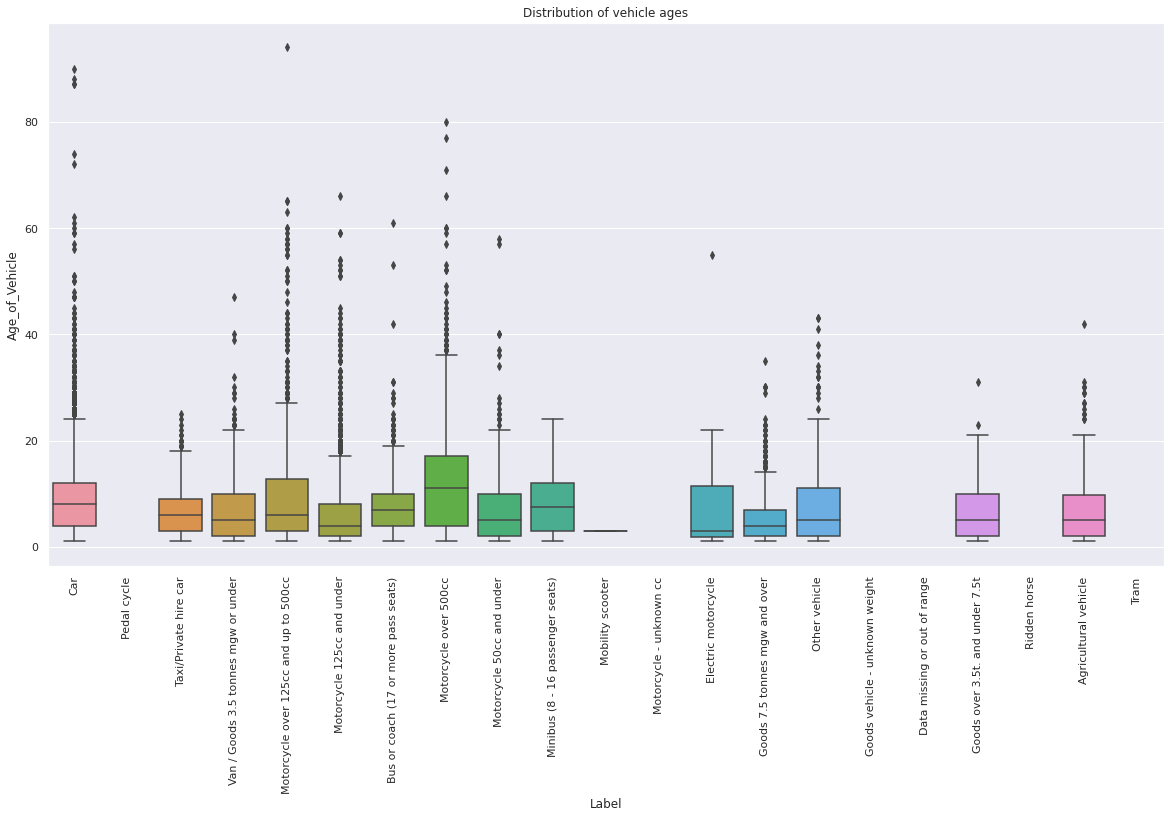

In [ ]:
boxplt(20, 10, 'Distribution of vehicle ages', vehicle, 'Label', 'Age_of_Vehicle', 90)

In [ ]:
subset = vehicle_type_percent_null[vehicle_type_percent_null['Age_of_Vehicle']>50]
subset[['Label', 'Vehicle_Type', 'Age_of_Vehicle']]

Label  Vehicle_Type  Age_of_Vehicle
3                Electric motorcycle          23.0       81.538462
5    Goods over 3.5t. and under 7.5t          20.0       57.433809
6     Goods vehicle - unknown weight          98.0      100.000000
7   Minibus (8 - 16 passenger seats)          10.0       61.481481
8                   Mobility scooter          22.0       99.600000
9            Motorcycle - unknown cc          97.0      100.000000
14                     Other vehicle          90.0       67.164179
15                       Pedal cycle           1.0      100.000000
16                      Ridden horse          16.0      100.000000
18                              Tram          18.0      100.000000

##### ridden horse

The ages of vehicle type 16 (ridden horse) have been left as nan. These can be imputed with a random number among the average riding ages of horses (5-25 years old). 

Maximum horse riding age: https://equinehelper.com/what-age-a-horse-should-retire/ 

Horses are broken in at 2-3 years old: https://animals.mom.com/old-horse-before-saddle-breaking-11043.html#:~:text=Most%20breeds%20of%20horses%20are,soundness%20issues%20as%20they%20age

Minimum riding age was thus listed as 5.


In [ ]:
vehicle.loc[vehicle['Vehicle_Type'] == 16,'Age_of_Vehicle'] = vehicle.loc[vehicle['Vehicle_Type'] == 16,'Age_of_Vehicle'].apply(lambda x: random.randint(5,25))


##### Trams and mini buses

Since the age of public transport like trams and mini buses isn't recorded, they've all been assumed to be new.

In [ ]:
vehicle.loc[(vehicle['Vehicle_Type'] == 18) | (vehicle['Vehicle_Type'] == 10) ,'Age_of_Vehicle'] = 0


##### Pedal cycles

If the driver is a young child, it's likely that the bike is new. Therefore the vehicle age was imputed as 0 years for them. For everyone else, a random number between 0 to 7 was imputed.

In [ ]:
vehicle.loc[(vehicle['Vehicle_Type'] == 1) & (vehicle['Age_of_Driver'] <12),'Age_of_Vehicle'] = 0

vehicle.loc[(vehicle['Vehicle_Type'] == 1) & (vehicle['Age_of_Driver'] >=12),'Age_of_Vehicle'] = vehicle.loc[(vehicle['Vehicle_Type'] == 1) & (vehicle['Age_of_Driver'] >=12),'Age_of_Vehicle'].apply(lambda x: random.randint(0,7))


##### Electric motorcycles

Electric motorcycles can last as long as normal motorcycles, that is, 10 to 15 years. Source: https://motor.onehowto.com/article/what-is-the-average-life-expectancy-of-a-motorcycle-6656.html 

20 was used as the upper **threshold**

In [ ]:
vehicle.loc[(vehicle['Vehicle_Type'] == 23),'Age_of_Vehicle'] =  vehicle.loc[(vehicle['Vehicle_Type'] == 23),'Age_of_Vehicle'].apply(lambda x: random.randint(0,20))


#### Cleaning the Engine Capacity column

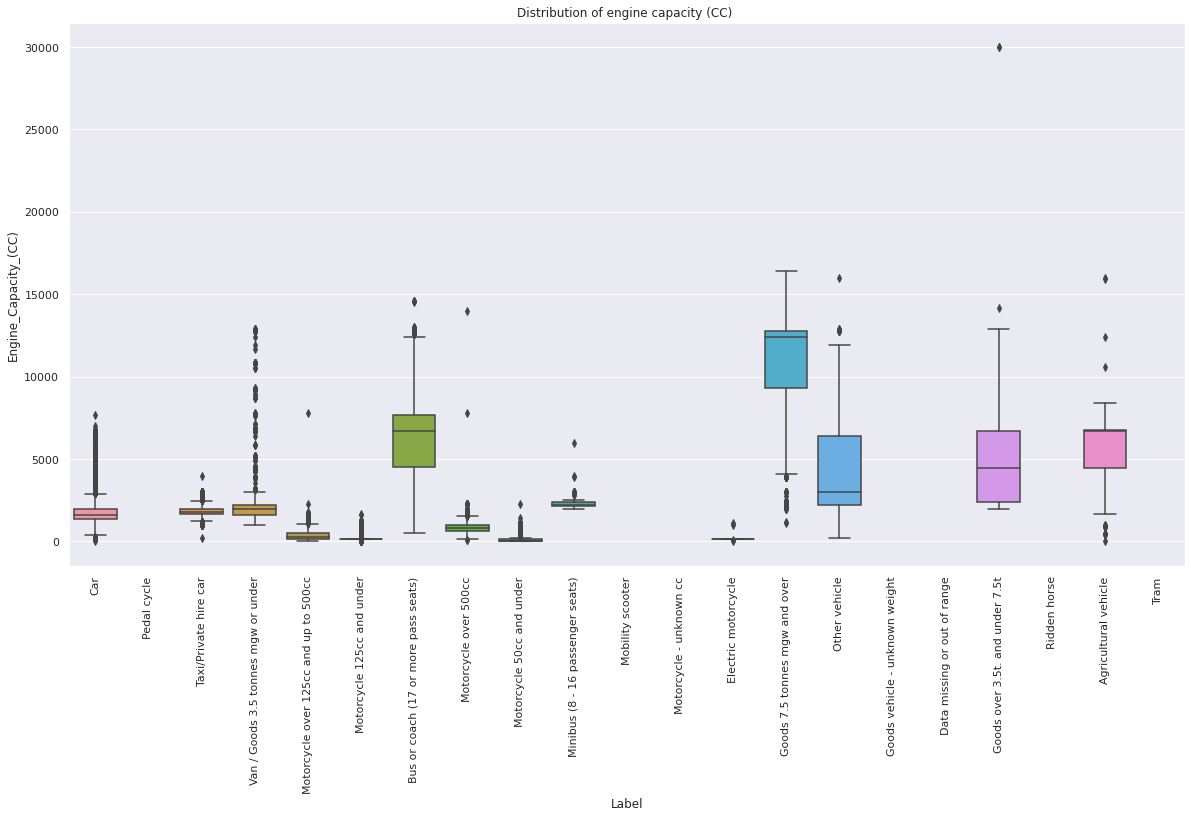

In [ ]:
boxplt(20, 10, 'Distribution of engine capacity (CC) ', vehicle, 'Label', 'Engine_Capacity_(CC)', 90)

In [ ]:
vehicle_type_percent_null[['Label', 'Vehicle_Type', 'Total_Values',  'Engine_Capacity_(CC)']]

Label  Vehicle_Type  Total_Values  \
0                    Agricultural vehicle          17.0           423   
1    Bus or coach (17 or more pass seats)          11.0          3902   
2                                     Car           9.0        152686   
3                     Electric motorcycle          23.0            65   
4           Goods 7.5 tonnes mgw and over          21.0          3357   
5         Goods over 3.5t. and under 7.5t          20.0           982   
6          Goods vehicle - unknown weight          98.0           890   
7        Minibus (8 - 16 passenger seats)          10.0           405   
8                        Mobility scooter          22.0           250   
9                 Motorcycle - unknown cc          97.0           415   
10             Motorcycle 125cc and under           3.0          8053   
11              Motorcycle 50cc and under           2.0          1489   
12  Motorcycle over 125cc and up to 500cc           4.0          2119   
13                  Motorcycle over 500cc           5.0          5228   
14                          Other vehicle          90.0          1005   
15                            Pedal cycle           1.0         17437   
16                           Ridden horse          16.0            65   
17                  Taxi/Private hire car           8.0          4696   
18                                   Tram          18.0            26   
19    Van / Goods 3.5 tonnes mgw or under          19.0         12579   

    Engine_Capacity_(CC)  
0              51.536643  
1              20.322911  
2              17.344092  
3              86.153846  
4              22.817992  
5              55.498982  
6             100.000000  
7              59.506173  
8             100.000000  
9             100.000000  
10             13.771265  
11             21.558093  
12             19.915054  
13             11.055853  
14             65.771144  
15            100.000000  
16            100.000000  
17             20.911414  
18            100.000000  
19             19.015820

In [ ]:
subset = vehicle_type_percent_null[vehicle_type_percent_null['Engine_Capacity_(CC)']>50]
subset[['Label', 'Vehicle_Type', 'Engine_Capacity_(CC)']]

Label  Vehicle_Type  Engine_Capacity_(CC)
0               Agricultural vehicle          17.0             51.536643
3                Electric motorcycle          23.0             86.153846
5    Goods over 3.5t. and under 7.5t          20.0             55.498982
6     Goods vehicle - unknown weight          98.0            100.000000
7   Minibus (8 - 16 passenger seats)          10.0             59.506173
8                   Mobility scooter          22.0            100.000000
9            Motorcycle - unknown cc          97.0            100.000000
14                     Other vehicle          90.0             65.771144
15                       Pedal cycle           1.0            100.000000
16                      Ridden horse          16.0            100.000000
18                              Tram          18.0            100.000000

##### Electric motorcycles that aren't electric

Some electric motorcycles have a listed CC which shouldn't be there since they're electric:

In [ ]:
vehicle[(vehicle['Vehicle_Type'] == 23) & (vehicle['Engine_Capacity_(CC)'].isna() == False)]

Accident_Index  Vehicle_Reference                Label  Vehicle_Type  \
209285  2019040856947                  1  Electric motorcycle          23.0   
209294  2019200836123                  2  Electric motorcycle          23.0   
209295  2019200851242                  2  Electric motorcycle          23.0   
209298  2019200890716                  1  Electric motorcycle          23.0   
209299  2019200891477                  1  Electric motorcycle          23.0   
209302  2019220881564                  1  Electric motorcycle          23.0   
209306  2019400835888                  1  Electric motorcycle          23.0   
209313  2019460828864                  1  Electric motorcycle          23.0   
209314  2019460873931                  1  Electric motorcycle          23.0   

        Towing_and_Articulation  Vehicle_Manoeuvre  \
209285                      0.0                9.0   
209294                      0.0               18.0   
209295                      0.0               18.0   
209298                      0.0               17.0   
209299                      0.0               17.0   
209302                      0.0               18.0   
209306                      0.0               18.0   
209313                      0.0               18.0   
209314                      0.0               18.0   

        Vehicle_Location-Restricted_Lane  Junction_Location  \
209285                               0.0                6.0   
209294                               0.0                8.0   
209295                               0.0                8.0   
209298                               0.0                0.0   
209299                               0.0                0.0   
209302                               0.0                1.0   
209306                               0.0                0.0   
209313                               0.0                0.0   
209314                               0.0                0.0   

        Skidding_and_Overturning  Hit_Object_in_Carriageway  \
209285                       1.0                        0.0   
209294                       0.0                        0.0   
209295                       0.0                        0.0   
209298                       0.0                       10.0   
209299                       2.0                        0.0   
209302                       0.0                        0.0   
209306                       0.0                        0.0   
209313                       5.0                        0.0   
209314                       0.0                        0.0   

        Vehicle_Leaving_Carriageway  Hit_Object_off_Carriageway  \
209285                          0.0                         0.0   
209294                          0.0                         0.0   
209295                          0.0                         0.0   
209298                          1.0                        10.0   
209299                          0.0                         0.0   
209302                          0.0                         0.0   
209306                          0.0                         0.0   
209313                          0.0                         0.0   
209314                          1.0                         0.0   

        1st_Point_of_Impact  Was_Vehicle_Left_Hand_Drive?  \
209285                  3.0                           1.0   
209294                  1.0                           1.0   
209295                  4.0                           1.0   
209298                  1.0                           1.0   
209299                  3.0                           1.0   
209302                  1.0                           1.0   
209306                  0.0                           1.0   
209313                  0.0                           1.0   
209314                  1.0                           1.0   

        Journey_Purpose_of_Driver  Sex_of_Driver  Age_of_Driver  \
209285                        5.0            1.0           17.0 

Their propulsion codes are also Petrol instead of electric. The labels and vehicle types of these bikes have been renamed according to their CC.

In [ ]:
vehicle.loc[((vehicle['Vehicle_Type'] == 23) & (vehicle['Propulsion_Code'] == 1) & (vehicle['Engine_Capacity_(CC)']<=50)), 'Label'] = 'Motorcycle 50cc and under'
vehicle.loc[((vehicle['Vehicle_Type'] == 23) & (vehicle['Propulsion_Code'] == 1) & (vehicle['Engine_Capacity_(CC)']<=50)), 'Vehicle_Type'] = 2

vehicle.loc[((vehicle['Vehicle_Type'] == 23) & (vehicle['Propulsion_Code'] == 1) & (vehicle['Engine_Capacity_(CC)']<=125)), 'Label'] = 'Motorcycle 125cc and under'
vehicle.loc[((vehicle['Vehicle_Type'] == 23) & (vehicle['Propulsion_Code'] == 1) & (vehicle['Engine_Capacity_(CC)']<=125)), 'Vehicle_Type'] = 3

vehicle.loc[((vehicle['Vehicle_Type'] == 23) & (vehicle['Propulsion_Code'] == 1) & (vehicle['Engine_Capacity_(CC)']>=500)), 'Label'] = 'Motorcycle over 500cc'
vehicle.loc[((vehicle['Vehicle_Type'] == 23) & (vehicle['Propulsion_Code'] == 1) & (vehicle['Engine_Capacity_(CC)']>=500)), 'Vehicle_Type'] = 5


##### Mobility scooters, pedal cycles, trams, and ridden horses, and electric motorcycles

 The engine capacity was set to 0 for these categories and the rest of the electric vehicles since they are electric.

In [ ]:
vehicle.loc[(vehicle['Vehicle_Type'] == 1) | (vehicle['Vehicle_Type'] == 16)| (vehicle['Vehicle_Type'] == 18) | (vehicle['Vehicle_Type'] == 22) | (vehicle['Vehicle_Type'] == 23), 'Engine_Capacity_(CC)'] = 0
vehicle.loc[(vehicle['Propulsion_Code']==3), 'Engine_Capacity_(CC)'] = 0


##### Outliers in Engine Capacity

Vehicle type 20 has a median engine capacity of 5000; even vehicles carrying goods 7.5 tonnes and over has a median engine capacity less than 15000. 

This could be an odd value imputed because the engine capacity was not known; both of these have thus been imputed with nan.

The same was done for outliers in other motorcycle vehicles.

In [ ]:
vehicle[(vehicle['Vehicle_Type']==20) & (vehicle['Engine_Capacity_(CC)']>20000)]
vehicle.loc[(vehicle['Vehicle_Type'] == 20) & (vehicle['Engine_Capacity_(CC)']>20000), 'Engine_Capacity_(CC)'] = np.NaN

vehicle[((vehicle['Vehicle_Type']==4) | (vehicle['Vehicle_Type']==5))  & (vehicle['Engine_Capacity_(CC)']>5000)]
vehicle.loc[((vehicle['Vehicle_Type']==4) | (vehicle['Vehicle_Type']==5)) & (vehicle['Engine_Capacity_(CC)']>5000), 'Engine_Capacity_(CC)'] = np.NaN



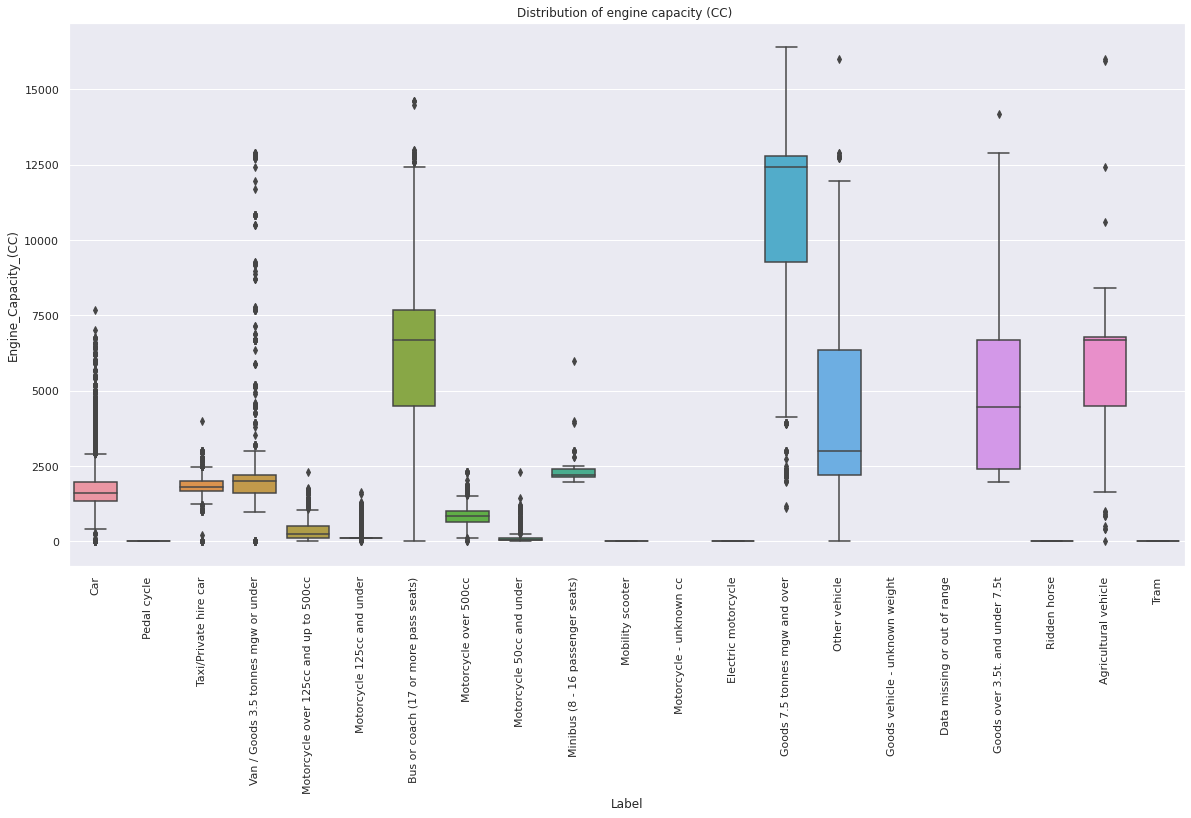

In [ ]:
boxplt(20, 10, 'Distribution of engine capacity (CC) ', vehicle, 'Label', 'Engine_Capacity_(CC)', 90)

In [ ]:
vehicle[(vehicle['Engine_Capacity_(CC)']<40) & (vehicle['Engine_Capacity_(CC)']>0)]


Accident_Index  Vehicle_Reference                 Label  Vehicle_Type  \
21387   2019010213638                  2                   Car           9.0   
216190  2019460816888                  1  Agricultural vehicle          17.0   

        Towing_and_Articulation  Vehicle_Manoeuvre  \
21387                       0.0               16.0   
216190                      0.0                9.0   

        Vehicle_Location-Restricted_Lane  Junction_Location  \
21387                                0.0                1.0   
216190                               0.0                8.0   

        Skidding_and_Overturning  Hit_Object_in_Carriageway  \
21387                        0.0                        0.0   
216190                       0.0                        0.0   

        Vehicle_Leaving_Carriageway  Hit_Object_off_Carriageway  \
21387                           0.0                         0.0   
216190                          0.0                         0.0   

        1st_Point_of_Impact  Was_Vehicle_Left_Hand_Drive?  \
21387                   2.0                           1.0   
216190                  1.0                           1.0   

        Journey_Purpose_of_Driver  Sex_of_Driver  Age_of_Driver  \
21387                         6.0            2.0           51.0   
216190                        1.0            1.0           18.0   

        Age_Band_of_Driver  Engine_Capacity_(CC)  Propulsion_Code  \
21387                  8.0                   2.0              2.0   
216190                 4.0                   1.0              2.0   

        Age_of_Vehicle  Driver_IMD_Decile  Driver_Home_Area_Type  \
21387             12.0                7.0                    1.0   
216190             3.0                3.0                    2.0   

        Vehicle_IMD_Decile  
21387                  7.0  
216190                 3.0

In [ ]:
vehicle.loc[vehicle['Engine_Capacity_(CC)']<40, 'Engine_Capacity_(CC)'] =  ((vehicle.loc[vehicle['Engine_Capacity_(CC)']<40])['Engine_Capacity_(CC)']) *1000


#### Cleaning the Propulsion Code column

In [ ]:
vehicle_type_percent_null[['Label', 'Vehicle_Type', 'Total_Values',  'Propulsion_Code']]

Label  Vehicle_Type  Total_Values  \
0                    Agricultural vehicle          17.0           423   
1    Bus or coach (17 or more pass seats)          11.0          3902   
2                                     Car           9.0        152686   
3                     Electric motorcycle          23.0            65   
4           Goods 7.5 tonnes mgw and over          21.0          3357   
5         Goods over 3.5t. and under 7.5t          20.0           982   
6          Goods vehicle - unknown weight          98.0           890   
7        Minibus (8 - 16 passenger seats)          10.0           405   
8                        Mobility scooter          22.0           250   
9                 Motorcycle - unknown cc          97.0           415   
10             Motorcycle 125cc and under           3.0          8053   
11              Motorcycle 50cc and under           2.0          1489   
12  Motorcycle over 125cc and up to 500cc           4.0          2119   
13                  Motorcycle over 500cc           5.0          5228   
14                          Other vehicle          90.0          1005   
15                            Pedal cycle           1.0         17437   
16                           Ridden horse          16.0            65   
17                  Taxi/Private hire car           8.0          4696   
18                                   Tram          18.0            26   
19    Van / Goods 3.5 tonnes mgw or under          19.0         12579   

    Propulsion_Code  
0         29.787234  
1         19.118401  
2         17.171843  
3         76.923077  
4         22.252011  
5         54.989817  
6        100.000000  
7         59.506173  
8         98.800000  
9        100.000000  
10        13.709177  
11        21.087979  
12        19.773478  
13        10.998470  
14        65.174129  
15       100.000000  
16       100.000000  
17        20.421635  
18       100.000000  
19        18.785277

In [ ]:
subset = vehicle_type_percent_null[vehicle_type_percent_null['Propulsion_Code']>50]
subset[['Label', 'Vehicle_Type', 'Propulsion_Code']]

Label  Vehicle_Type  Propulsion_Code
3                Electric motorcycle          23.0        76.923077
5    Goods over 3.5t. and under 7.5t          20.0        54.989817
6     Goods vehicle - unknown weight          98.0       100.000000
7   Minibus (8 - 16 passenger seats)          10.0        59.506173
8                   Mobility scooter          22.0        98.800000
9            Motorcycle - unknown cc          97.0       100.000000
14                     Other vehicle          90.0        65.174129
15                       Pedal cycle           1.0       100.000000
16                      Ridden horse          16.0       100.000000
18                              Tram          18.0       100.000000

In [ ]:
vehicle.groupby(['Vehicle_Type', 'Label', 'Propulsion_Code']).size().reset_index()

Vehicle_Type                                  Label  Propulsion_Code  \
0            2.0              Motorcycle 50cc and under              1.0   
1            2.0              Motorcycle 50cc and under              3.0   
2            3.0             Motorcycle 125cc and under              1.0   
3            3.0             Motorcycle 125cc and under              3.0   
4            4.0  Motorcycle over 125cc and up to 500cc              1.0   
5            4.0  Motorcycle over 125cc and up to 500cc              2.0   
6            4.0  Motorcycle over 125cc and up to 500cc              3.0   
7            5.0                  Motorcycle over 500cc              1.0   
8            5.0                  Motorcycle over 500cc              2.0   
9            5.0                  Motorcycle over 500cc              3.0   
10           5.0                  Motorcycle over 500cc              5.0   
11           8.0                  Taxi/Private hire car              1.0   
12           8.0                  Taxi/Private hire car              2.0   
13           8.0                  Taxi/Private hire car              3.0   
14           8.0                  Taxi/Private hire car              6.0   
15           8.0                  Taxi/Private hire car              7.0   
16           8.0                  Taxi/Private hire car              8.0   
17           8.0                  Taxi/Private hire car             12.0   
18           9.0                                    Car              1.0   
19           9.0                                    Car              2.0   
20           9.0                                    Car              3.0   
21           9.0                                    Car              5.0   
22           9.0                                    Car              6.0   
23           9.0                                    Car              7.0   
24           9.0                                    Car              8.0   
25           9.0                                    Car              9.0   
26           9.0                                    Car             12.0   
27          10.0       Minibus (8 - 16 passenger seats)              1.0   
28          10.0       Minibus (8 - 16 passenger seats)              2.0   
29          11.0   Bus or coach (17 or more pass seats)              1.0   
30          11.0   Bus or coach (17 or more pass seats)              2.0   
31          11.0   Bus or coach (17 or more pass seats)              3.0   
32          11.0   Bus or coach (17 or more pass seats)              5.0   
33          17.0                   Agricultural vehicle              1.0   
34          17.0                   Agricultural vehicle              2.0   
35          19.0    Van / Goods 3.5 tonnes mgw or under              1.0   
36          19.0    Van / Goods 3.5 tonnes mgw or under              2.0   
37          19.0    Van / Goods 3.5 tonnes mgw or under              3.0   
38          19.0    Van / Goods 3.5 tonnes mgw or under              5.0   
39          19.0    Van / Goods 3.5 tonnes mgw or under              7.0   
40          20.0        Goods over 3.5t. and under 7.5t              2.0   
41          20.0        Goods over 3.5t. and under 7.5t              7.0   
42          21.0          Goods 7.5 tonnes mgw and over              2.0   
43          21.0          Goods 7.5 tonnes mgw and over              5.0   
44          22.0                       Mobility scooter              3.0   
45          23.0                    Electric motorcycle              3.0   
46          90.0                          Other vehicle              1.0   
47          90.0                          Other vehicle              2.0   
48          90.0                          Other vehicle              3.0   
49          90.0                          Other vehicle              4.0   
50          90.0                          Other vehicle              5.0   

        0  
0    1169  
1       7  
2    6950  
3  

Some entries for motorcycles have electric as their propulsion code:

In [ ]:
vehicle[((vehicle['Vehicle_Type'] == 2) | (vehicle['Vehicle_Type'] == 3)  |(vehicle['Vehicle_Type'] == 4)  |(vehicle['Vehicle_Type'] == 5)) & (vehicle['Propulsion_Code'] == 3)]

Accident_Index  Vehicle_Reference  \
187990  2019010208121                  1   
188075  2019010215458                  2   
188076  2019010215485                  2   
190501  2019010176950                  1   
192339  2019010212589                  2   
192801  2019010221154                  1   
196156  2019460840069                  1   
196278  2019460892181                  1   
202160  2019010205003                  1   
202836  2019070331283                  1   
204901  2019440165358                  1   
206912  2019010184634                  1   
206995  2019010196542                  2   
207004  2019010197303                  2   
207151  2019010220393                  2   
207158  2019010221156                  2   
207179  2019010223273                  1   
207207  2019010227505                  2   

                                        Label  Vehicle_Type  \
187990  Motorcycle over 125cc and up to 500cc           4.0   
188075  Motorcycle over 125cc and up to 500cc           4.0   
188076  Motorcycle over 125cc and up to 500cc           4.0   
190501             Motorcycle 125cc and under           3.0   
192339             Motorcycle 125cc and under           3.0   
192801             Motorcycle 125cc and under           3.0   
196156             Motorcycle 125cc and under           3.0   
196278             Motorcycle 125cc and under           3.0   
202160                  Motorcycle over 500cc           5.0   
202836                  Motorcycle over 500cc           5.0   
204901                  Motorcycle over 500cc           5.0   
206912              Motorcycle 50cc and under           2.0   
206995              Motorcycle 50cc and under           2.0   
207004              Motorcycle 50cc and under           2.0   
207151              Motorcycle 50cc and under           2.0   
207158              Motorcycle 50cc and under           2.0   
207179              Motorcycle 50cc and under           2.0   
207207              Motorcycle 50cc and under           2.0   

        Towing_and_Articulation  Vehicle_Manoeuvre  \
187990                      0.0                9.0   
188075                      0.0                5.0   
188076                      0.0               15.0   
190501                      0.0               18.0   
192339                      0.0                9.0   
192801                      NaN                NaN   
196156                      0.0               16.0   
196278                      0.0               13.0   
202160                      0.0               13.0   
202836                      0.0                5.0   
204901                      0.0               13.0   
206912                      0.0               16.0   
206995                      0.0               18.0   
207004                      0.0                NaN   
207151                      0.0                4.0   
207158                      0.0               18.0   
207179                      0.0                NaN   
207207                      0.0               13.0   

        Vehicle_Location-Restricted_Lane  Junction_Location  \
187990                               0.0                1.0   
188075                               0.0                1.0   
188076                               0.0                1.0   
190501                               0.0                0.0   
192339                               0.0                2.0   
192801                               NaN                NaN   
196156                               0.0                0.0   
196278                               0.0                1.0   
202160                               0.0                0.0   
202836                               0.0                0.0   
204901                               0.0                0.0   
206912                               0.0                8.0   
206995                               0.0                1.0   
207004                               0.0                NaN   


##### motorbikes that are electric

These motorbikes even have 0 listed as their engine capacity (CC). It's likely that these are electric motorbikes; the vehicle types and labels have been renamed accordingly.

In [ ]:
vehicle.loc[((vehicle['Vehicle_Type'] == 2) | (vehicle['Vehicle_Type'] == 3)  |(vehicle['Vehicle_Type'] == 4)  |(vehicle['Vehicle_Type'] == 5)) & (vehicle['Propulsion_Code'] == 3), 'Label'] = 'Electric motorcycle'
vehicle.loc[((vehicle['Vehicle_Type'] == 2) | (vehicle['Vehicle_Type'] == 3)  |(vehicle['Vehicle_Type'] == 4)  |(vehicle['Vehicle_Type'] == 5)) & (vehicle['Propulsion_Code'] == 3), 'Vehicle_Type'] = 23



##### mobility scooter, tram, and electric bike

For mobility scooters, trams, and electric motorcycles, the propulsion code has been set to 3 (electric)

In [ ]:
vehicle.loc[((vehicle['Vehicle_Type'] == 23) | (vehicle['Vehicle_Type'] == 22)  |(vehicle['Vehicle_Type'] == 18)), 'Propulsion_Code'] = 3


##### pedal cycle and ridden horse

For pedal cycles and ridden horses, a new propulsion code '13' was imputed. This means manual labour.

In [ ]:
vehicle.loc[((vehicle['Vehicle_Type']==1) | (vehicle['Vehicle_Type']==16)), 'Propulsion_Code'] = 13

#### Cleaning the driver age column

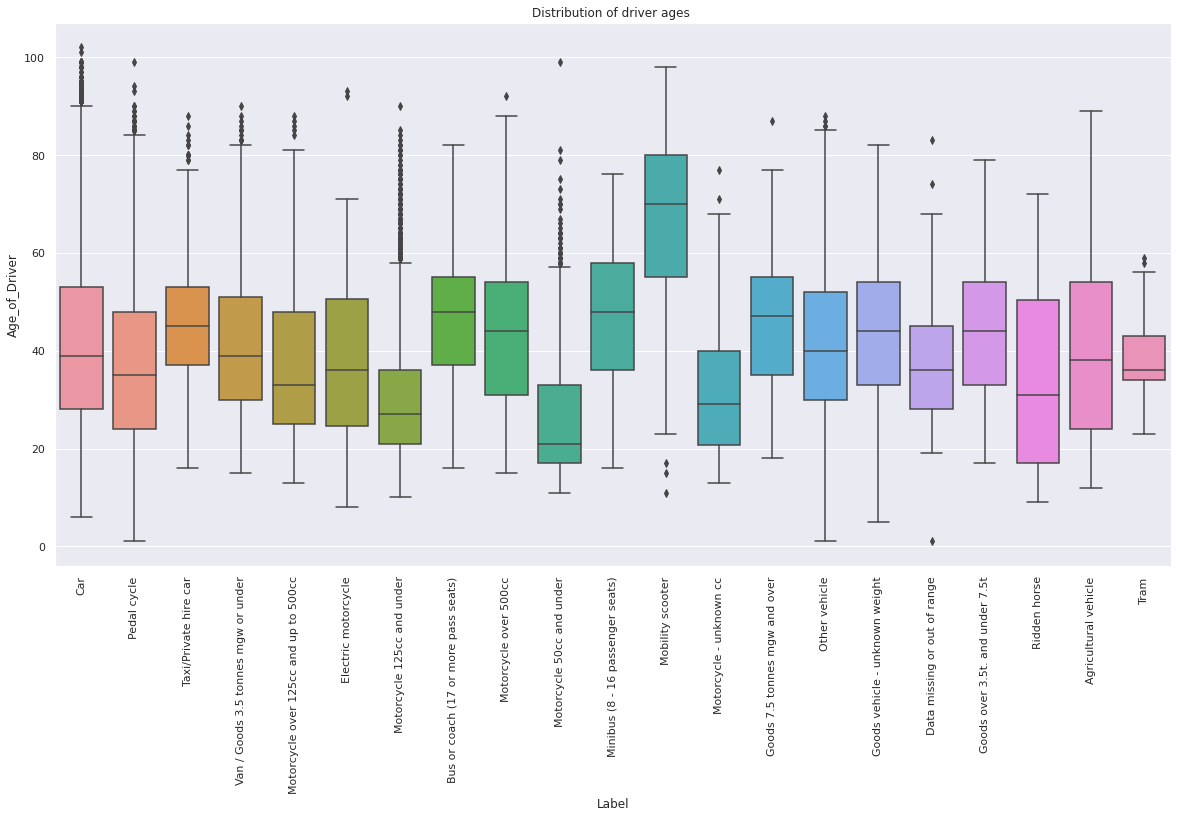

In [ ]:
boxplt(20, 10, 'Distribution of driver ages ', vehicle, 'Label', 'Age_of_Driver', 90)

In [ ]:
vehicle_type_percent_null[['Label', 'Vehicle_Type', 'Total_Values',  'Age_of_Driver']]

Label  Vehicle_Type  Total_Values  \
0                    Agricultural vehicle          17.0           423   
1    Bus or coach (17 or more pass seats)          11.0          3902   
2                                     Car           9.0        152686   
3                     Electric motorcycle          23.0            65   
4           Goods 7.5 tonnes mgw and over          21.0          3357   
5         Goods over 3.5t. and under 7.5t          20.0           982   
6          Goods vehicle - unknown weight          98.0           890   
7        Minibus (8 - 16 passenger seats)          10.0           405   
8                        Mobility scooter          22.0           250   
9                 Motorcycle - unknown cc          97.0           415   
10             Motorcycle 125cc and under           3.0          8053   
11              Motorcycle 50cc and under           2.0          1489   
12  Motorcycle over 125cc and up to 500cc           4.0          2119   
13                  Motorcycle over 500cc           5.0          5228   
14                          Other vehicle          90.0          1005   
15                            Pedal cycle           1.0         17437   
16                           Ridden horse          16.0            65   
17                  Taxi/Private hire car           8.0          4696   
18                                   Tram          18.0            26   
19    Van / Goods 3.5 tonnes mgw or under          19.0         12579   

    Age_of_Driver  
0       11.820331  
1       11.276269  
2       15.147427  
3       10.769231  
4       10.991957  
5       16.089613  
6       46.067416  
7       15.555556  
8       13.200000  
9       46.987952  
10       3.849497  
11       8.462055  
12       4.388863  
13       1.989288  
14      18.308458  
15       3.767850  
16       1.538462  
17      19.101363  
18      19.230769  
19      17.918753

##### Ridden Horse young ages

Some horse riders appear to be as young as 9 years old. There are currently no laws in the U.K. regarding minimum ages of horseriders on carriageways: https://www.bhs.org.uk/advice-and-information/the-law/highway-code 

There are forums which specifically address the issue as well: https://forums.digitalspy.com/discussion/1134243/are-there-any-age-laws-on-riding-ponies-horses-on-the-road 

It appears that this is not a completely unlikely phenomenon.

In [ ]:
vehicle[vehicle['Vehicle_Type']==16]

Accident_Index  Vehicle_Reference         Label  Vehicle_Type  \
215867  2019010158681                  2  Ridden horse          16.0   
215868  2019010168607                  2  Ridden horse          16.0   
215869  2019010192005                  2  Ridden horse          16.0   
215870  2019010203229                  2  Ridden horse          16.0   
215871  2019010205442                  2  Ridden horse          16.0   
215872  201906L261764                  2  Ridden horse          16.0   
215873  201906L261764                  3  Ridden horse          16.0   
215874  2019070004830                  2  Ridden horse          16.0   
215875  2019070528781                  2  Ridden horse          16.0   
215876  2019100846338                  2  Ridden horse          16.0   
215877  2019100905249                  1  Ridden horse          16.0   
215878  2019121900553                  2  Ridden horse          16.0   
215879  2019122000132                  1  Ridden horse          16.0   
215880  2019136CF0516                  2  Ridden horse          16.0   
215881  2019136CF0516                  3  Ridden horse          16.0   
215882  2019140825831                  2  Ridden horse          16.0   
215883  2019160824609                  2  Ridden horse          16.0   
215884  2019160836021                  1  Ridden horse          16.0   
215885  2019160836021                  3  Ridden horse          16.0   
215886  2019160912617                  2  Ridden horse          16.0   
215887  2019160918617                  2  Ridden horse          16.0   
215888  2019200905336                  2  Ridden horse          16.0   
215889  2019210830565                  2  Ridden horse          16.0   
215890  2019220356257                  2  Ridden horse          16.0   
215891  2019220826172                  2  Ridden horse          16.0   
215892  2019220837375                  2  Ridden horse          16.0   
215893  2019220847222                  2  Ridden horse          16.0   
215894  2019220856538                  2  Ridden horse          16.0   
215895  2019220894975                  2  Ridden horse          16.0   
215896  2019220911086                  2  Ridden horse          16.0   
215897  2019301900990                  2  Ridden horse          16.0   
215898  201931B161619                  2  Ridden horse          16.0   
215899  2019320078812                  1  Ridden horse          16.0   
215900  2019370872835                  2  Ridden horse          16.0   
215901  2019370891939                  2  Ridden horse          16.0   
215902  2019400827378                  2  Ridden horse          16.0   
215903  2019400827378                  3  Ridden horse          16.0   
215904  2019410906731                  2  Ridden horse          16.0   
215905  2019420915690                  2  Ridden horse          16.0   
215906  2019430370393                  1  Ridden horse          16.0   
215907  2019450831578                  1  Ridden horse          16.0   
215908  2019460834429                  2  Ridden horse          16.0   
215909  2019470903395                  2  Ridden horse          16.0   
215910  2019470907118                  2  Ridden horse          16.0   
215911  2019470914278                  2  Ridden horse          16.0   
215912  2019470914278                  3  Ridden horse          16.0   
215913  2019471900896                  2  Ridden horse          16.0   
215914  2019471900914                  1  Ridden horse          16.0   
215915  2019500828622                  1  Ridden horse          16.0   
215916  2019500838892                  2  Ridden horse          16.0   
215917  2019500855526                  2  Ridden horse          16.0   
215918  2019500876617                  2  Ridden horse          16.0   
215919  2019500905948                  2  Ridden horse          16.0   
215920  2019520900865                  2  Ridden horse          16.0   
215921  2019521907596                  2  Ridde

##### Pedal Cycle young ages

Children as young as 3 were riding the cycle.

In [ ]:
vehicle[(vehicle['Vehicle_Type']==1) & (vehicle['Age_of_Driver']<8)]

Accident_Index  Vehicle_Reference        Label  Vehicle_Type  \
152783  2019010157265                  1  Pedal cycle           1.0   
153885  2019010176141                  2  Pedal cycle           1.0   
154371  2019010182992                  2  Pedal cycle           1.0   
155774  2019010201844                  2  Pedal cycle           1.0   
156187  2019010206672                  2  Pedal cycle           1.0   
156275  2019010207888                  2  Pedal cycle           1.0   
157543  2019030874153                  1  Pedal cycle           1.0   
157545  2019030876871                  1  Pedal cycle           1.0   
157558  2019030888279                  2  Pedal cycle           1.0   
157645  2019040841083                  2  Pedal cycle           1.0   
157682  2019040852520                  2  Pedal cycle           1.0   
157802  2019040879590                  3  Pedal cycle           1.0   
157834  2019040889059                  2  Pedal cycle           1.0   
158096  2019051912014                  2  Pedal cycle           1.0   
158478  201906F257011                  2  Pedal cycle           1.0   
158546  201906J158344                  1  Pedal cycle           1.0   
158727  201906N257618                  2  Pedal cycle           1.0   
158759  201906Q156820                  1  Pedal cycle           1.0   
158783  201906Q262436                  2  Pedal cycle           1.0   
158983  2019070445810                  2  Pedal cycle           1.0   
159076  2019070703149                  1  Pedal cycle           1.0   
159154  2019100827009                  2  Pedal cycle           1.0   
159206  2019100844877                  1  Pedal cycle           1.0   
159273  2019100865183                  2  Pedal cycle           1.0   
159292  2019100872901                  1  Pedal cycle           1.0   
159386  2019100906858                  2  Pedal cycle           1.0   
159568  2019121900667                  2  Pedal cycle           1.0   
159580  2019121900718                  2  Pedal cycle           1.0   
159643  2019121901081                  2  Pedal cycle           1.0   
159668  2019121901209                  2  Pedal cycle           1.0   
159859  20191363D1372                  2  Pedal cycle           1.0   
159904  20191364G1125                  1  Pedal cycle           1.0   
159929  2019136551297                  2  Pedal cycle           1.0   
160000  20191366R1569                  1  Pedal cycle           1.0   
160023  20191367A1239                  1  Pedal cycle           1.0   
160030  20191367D1542                  2  Pedal cycle           1.0   
160056  20191367Q1009                  1  Pedal cycle           1.0   
160087  20191368Q1798                  2  Pedal cycle           1.0   
160285  2019140810700                  2  Pedal cycle           1.0   
160326  2019140827251                  2  Pedal cycle           1.0   
160402  2019140857235                  2  Pedal cycle           1.0   
160411  2019140861443                  2  Pedal cycle           1.0   
160694  2019160837492                  2  Pedal cycle           1.0   
160710  2019160840602                  2  Pedal cycle           1.0   
160772  2019160854761                  2  Pedal cycle           1.0   
160775  2019160855032                  1  Pedal cycle           1.0   
160818  2019160863682                  2  Pedal cycle           1.0   
160875  2019160875178                  2  Pedal cycle           1.0   
160947  2019160894041                  2  Pedal cycle           1.0   
161029  2019160914039                  2  Pedal cycle           1.0   
161064  2019170H10519                  2  Pedal cycle           1.0   
161068  2019170H10669                  2  Pedal cycle           1.0   
161155  2019170S11809                  2  Pedal cycle           1.0   
161230  2019200822673                  2  Pedal cycle           1.0   
161412  2019200861378                  2  Pedal cycle           1.0   
161414  2019200861971          

##### Cars and bikes young ages

In the U.K., minors can apply for their provisional license at the age of 15 years and 9 months; they can start driving quad bikes from 16. It was assumed that drivers as young as 15 are plausible, and younger ages are passengers instead of drivers. These ages and age bands were replaced with NaN. 


In [ ]:
vehicle[((vehicle['Vehicle_Type'] == 9) | (vehicle['Vehicle_Type'] == 8) |  (vehicle['Vehicle_Type'] == 2)  |  (vehicle['Vehicle_Type'] == 3) | (vehicle['Vehicle_Type'] == 4)  |  (vehicle['Vehicle_Type'] == 5) |  (vehicle['Vehicle_Type'] == 23)) & (vehicle['Age_of_Driver']<15)]
vehicle.loc[((vehicle['Vehicle_Type'] == 9) | (vehicle['Vehicle_Type'] == 8) |  (vehicle['Vehicle_Type'] == 2)  |  (vehicle['Vehicle_Type'] == 3) | (vehicle['Vehicle_Type'] == 4)  |  (vehicle['Vehicle_Type'] == 5) |  (vehicle['Vehicle_Type'] == 23) | (vehicle['Vehicle_Type'] == 97) |  (vehicle['Vehicle_Type'] == 17) | (vehicle['Vehicle_Type'] == 98)) & (vehicle['Age_of_Driver']<15), 'Age_of_Driver'] = np.NaN
vehicle.loc[((vehicle['Vehicle_Type'] == 9) | (vehicle['Vehicle_Type'] == 8) |  (vehicle['Vehicle_Type'] == 2)  |  (vehicle['Vehicle_Type'] == 3) | (vehicle['Vehicle_Type'] == 4)  |  (vehicle['Vehicle_Type'] == 5) |  (vehicle['Vehicle_Type'] == 23) | (vehicle['Vehicle_Type'] == 97) |  (vehicle['Vehicle_Type'] == 17) | (vehicle['Vehicle_Type'] == 98)) & (vehicle['Age_of_Driver']<15), 'Age_Band_of_Driver'] = np.NaN


#### Cleaning the Towed column

Ridden horses can't be towed!

```
# This is formatted as code
```



In [ ]:
vehicle.loc[vehicle['Vehicle_Type'] == 16,'Towing_and_Articulation'] = 0

#### Imputing the remaining missing values

Missing values were checked and imputed as much as possible through reasoning; many of them however, still have to be imputed based on the values of similar rows and columns.

##### Visualizations before filling in

Before filling them in, here is what some of the graphs looked like:

<Figure size 1080x720 with 0 Axes>

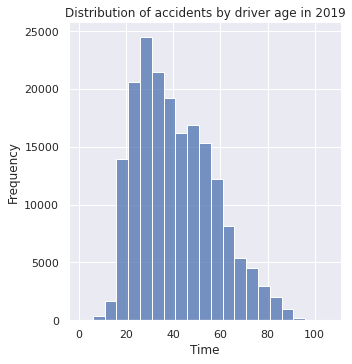

In [ ]:
displt(15, 10, vehicle, 'Age_of_Driver', 5, 'mako', 'Distribution of accidents by driver age in 2019', 'Time', 'Frequency', None, None, None)

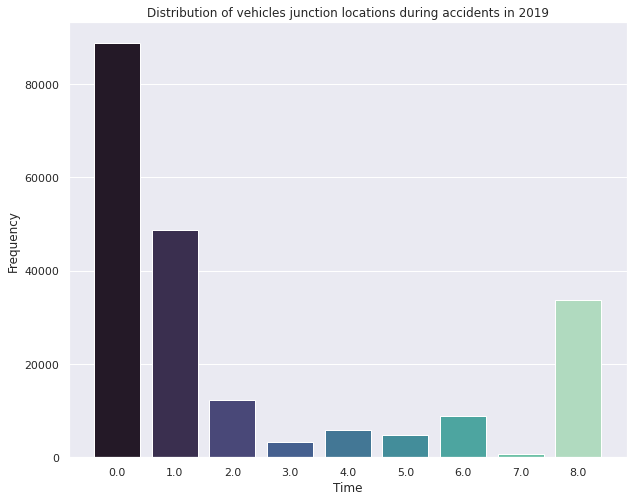

In [ ]:
subset = vehicle.groupby(['Junction_Location']).size().reset_index()
barplt(10, 8, subset, 'Junction_Location', 0, 'mako', 'Distribution of vehicles junction locations during accidents in 2019', 'Time', 'Frequency', None, None, None)

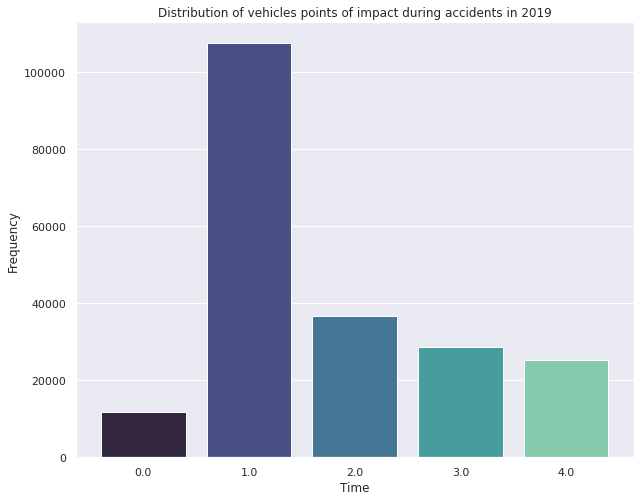

In [ ]:
subset = vehicle.groupby(['1st_Point_of_Impact']).size().reset_index()
barplt(10, 8, subset, '1st_Point_of_Impact', 0, 'mako', 'Distribution of vehicles points of impact during accidents in 2019', 'Time', 'Frequency', None, None, None)

##### Filling in the missing values

Accident_Index                          0
Vehicle_Reference                       0
Label                                   0
Vehicle_Type                          309
Towing_and_Articulation              4526
Vehicle_Manoeuvre                   13063
Vehicle_Location-Restricted_Lane    12746
Junction_Location                    9531
Skidding_and_Overturning            13361
Hit_Object_in_Carriageway           13057
Vehicle_Leaving_Carriageway         12916
Hit_Object_off_Carriageway          12271
1st_Point_of_Impact                  6681
Was_Vehicle_Left_Hand_Drive?        11051
Journey_Purpose_of_Driver              58
Sex_of_Driver                           0
Age_of_Driver                       29799
Age_Band_of_Driver                  29756
Engine_Capacity_(CC)                36768
Propulsion_Code                     36622
Age_of_Vehicle                      44582
Driver_IMD_Decile                   42385
Driver_Home_Area_Type               44869
Vehicle_IMD_Decile                

Accident_Index  Vehicle_Reference Label  Vehicle_Type  \
0       2019010128300                  1   Car           9.0   
1       2019010128300                  2   Car           9.0   
2       2019010152270                  1   Car           9.0   
3       2019010152270                  2   Car           9.0   
4       2019010155191                  1   Car           9.0   
...               ...                ...   ...           ...   
216376  201931C186819                  1  Tram          18.0   
216377  201931C222119                  1  Tram          18.0   
216378  201931C250519                  1  Tram          18.0   
216379  201931D067019                  1  Tram          18.0   
216380  2019950000372                  2  Tram          18.0   

        Towing_and_Articulation  Vehicle_Manoeuvre  \
0                           0.0                NaN   
1                           0.0                NaN   
2                           0.0               18.0   
3                           0.0               18.0   
4                           0.0                3.0   
...                         ...                ...   
216376                      0.0               18.0   
216377                      0.0               18.0   
216378                      0.0               18.0   
216379                      0.0               18.0   
216380                      0.0               18.0   

        Vehicle_Location-Restricted_Lane  Junction_Location  \
0                                    NaN                NaN   
1                                    NaN                NaN   
2                                    NaN                0.0   
3                                    NaN                0.0   
4                                    0.0                1.0   
...                                  ...                ...   
216376                               1.0                0.0   
216377                               1.0                0.0   
216378                               1.0                0.0   
216379                               1.0                1.0   
216380                               0.0                1.0   

        Skidding_and_Overturning  Hit_Object_in_Carriageway  \
0                            NaN                        NaN   
1                            NaN                        NaN   
2                            NaN                        NaN   
3                            NaN                        NaN   
4                            0.0                        0.0   
...                          ...                        ...   
216376                       0.0                        0.0   
216377                       0.0                        0.0   
216378                       0.0                        0.0   
216379                       0.0                        0.0   
216380                       0.0                        0.0   

        Vehicle_Leaving_Carriageway  Hit_Object_off_Carriageway  \
0                               NaN                         NaN   
1                               NaN                         NaN   
2                               NaN                         NaN   
3                               NaN                         NaN   
4                               0.0                         0.0   
...                             ...                         ...   
216376                          0.0                         0.0   
216377                          0.0                         0.0   
216378                          0.0                         0.0   
216379                          0.0                         0.0   
216380                          0.0                         0.0   

        1st_Point_of_Impact  Was_Vehicle_Left_Hand_Drive?  \
0                       4.0                           NaN   
1                       NaN                           NaN   
2                       1.0                           NaN   
3                       Na

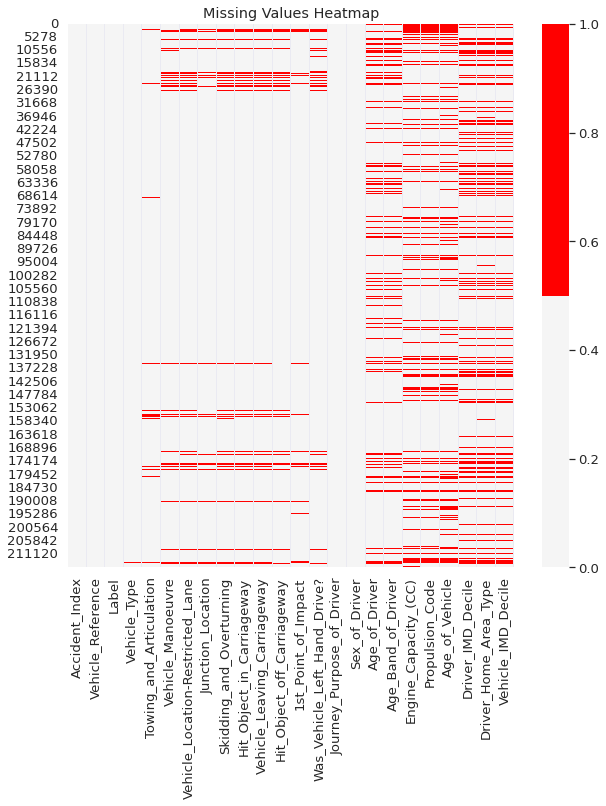

In [ ]:
view_nan(vehicle, True, False)


In [ ]:
for col in nan_imputer_features(vehicle):
  ncols = []
  if col!= 'Age_Band_of_Driver':
    try:
      vehicle = nan_imputer(vehicle, col)
    except:
      ncols.append(col)

print(ncols)

['Driver_Home_Area_Type']


In [ ]:
for col in ['Age_of_Vehicle', 'Propulsion_Code', 'Engine_Capacity_(CC)', 'Age_of_Driver', 'Driver_Home_Area_Type']:
  vehicle = nan_imputer(vehicle, col, ['Vehicle_Manoeuvre', 'Junction_Location', '1st_Point_of_Impact', 'Age_of_Driver'])



Accident_Index                          0
Vehicle_Reference                       0
Label                                   0
Vehicle_Type                            0
Towing_and_Articulation                 0
Vehicle_Manoeuvre                       0
Vehicle_Location-Restricted_Lane        0
Junction_Location                       0
Skidding_and_Overturning                0
Hit_Object_in_Carriageway               0
Vehicle_Leaving_Carriageway             0
Hit_Object_off_Carriageway              0
1st_Point_of_Impact                     0
Was_Vehicle_Left_Hand_Drive?            0
Journey_Purpose_of_Driver               0
Sex_of_Driver                           0
Age_of_Driver                           0
Age_Band_of_Driver                  29756
Engine_Capacity_(CC)                    0
Propulsion_Code                         0
Age_of_Vehicle                          0
Driver_IMD_Decile                       1
Driver_Home_Area_Type                   0
Vehicle_IMD_Decile                

Accident_Index  Vehicle_Reference Label  Vehicle_Type  \
0       2019010128300                  1   Car           9.0   
1       2019010128300                  2   Car           9.0   
2       2019010152270                  1   Car           9.0   
3       2019010152270                  2   Car           9.0   
4       2019010155191                  1   Car           9.0   
...               ...                ...   ...           ...   
216376  201931C186819                  1  Tram          18.0   
216377  201931C222119                  1  Tram          18.0   
216378  201931C250519                  1  Tram          18.0   
216379  201931D067019                  1  Tram          18.0   
216380  2019950000372                  2  Tram          18.0   

        Towing_and_Articulation  Vehicle_Manoeuvre  \
0                           0.0               16.0   
1                           0.0               18.0   
2                           0.0               18.0   
3                           0.0               18.0   
4                           0.0                3.0   
...                         ...                ...   
216376                      0.0               18.0   
216377                      0.0               18.0   
216378                      0.0               18.0   
216379                      0.0               18.0   
216380                      0.0               18.0   

        Vehicle_Location-Restricted_Lane  Junction_Location  \
0                                    0.0                1.0   
1                                    0.0                1.0   
2                                    0.0                0.0   
3                                    0.0                0.0   
4                                    0.0                1.0   
...                                  ...                ...   
216376                               1.0                0.0   
216377                               1.0                0.0   
216378                               1.0                0.0   
216379                               1.0                1.0   
216380                               0.0                1.0   

        Skidding_and_Overturning  Hit_Object_in_Carriageway  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        0.0   
...                          ...                        ...   
216376                       0.0                        0.0   
216377                       0.0                        0.0   
216378                       0.0                        0.0   
216379                       0.0                        0.0   
216380                       0.0                        0.0   

        Vehicle_Leaving_Carriageway  Hit_Object_off_Carriageway  \
0                               0.0                         0.0   
1                               0.0                         0.0   
2                               0.0                         0.0   
3                               0.0                         0.0   
4                               0.0                         0.0   
...                             ...                         ...   
216376                          0.0                         0.0   
216377                          0.0                         0.0   
216378                          0.0                         0.0   
216379                          0.0                         0.0   
216380                          0.0                         0.0   

        1st_Point_of_Impact  Was_Vehicle_Left_Hand_Drive?  \
0                       4.0                           1.0   
1                       1.0                           1.0   
2                       1.0                           1.0   
3                       1.

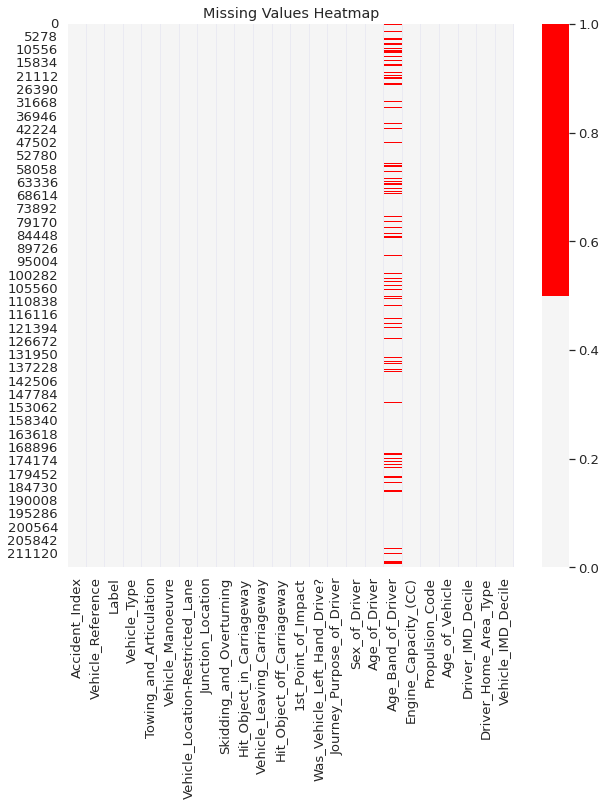

In [ ]:
vehicle = df_round(vehicle)
view_nan(vehicle, True, False)


After the values were imputed:

<Figure size 1080x720 with 0 Axes>

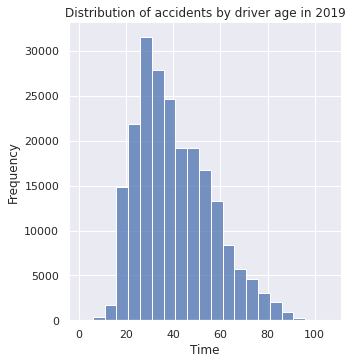

In [ ]:
displt(15, 10, vehicle, 'Age_of_Driver', 5, 'mako', 'Distribution of accidents by driver age in 2019', 'Time', 'Frequency', None, None, None)

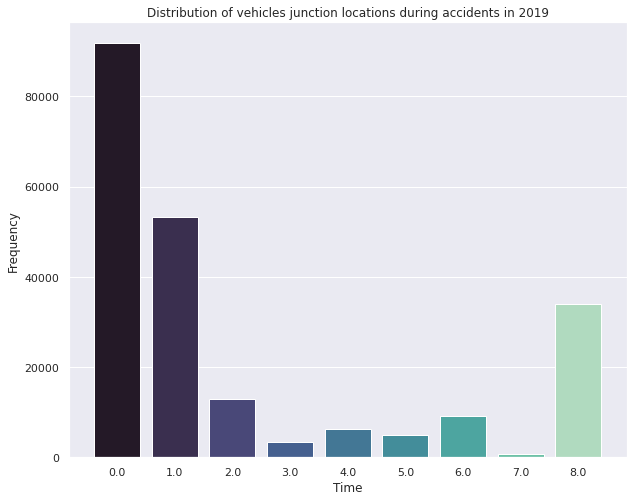

In [ ]:
subset = vehicle.groupby(['Junction_Location']).size().reset_index()
barplt(10, 8, subset, 'Junction_Location', 0, 'mako', 'Distribution of vehicles junction locations during accidents in 2019', 'Time', 'Frequency', None, None, None)

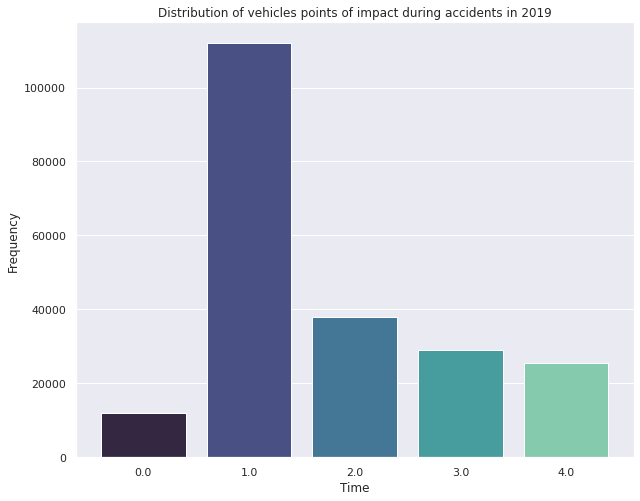

In [ ]:
subset = vehicle.groupby(['1st_Point_of_Impact']).size().reset_index()
barplt(10, 8, subset, '1st_Point_of_Impact', 0, 'mako', 'Distribution of vehicles points of impact during accidents in 2019', 'Time', 'Frequency', None, None, None)


### Feature engineering the vehicle dataframe

Binning the ages, and creating a binned age column for vehicles

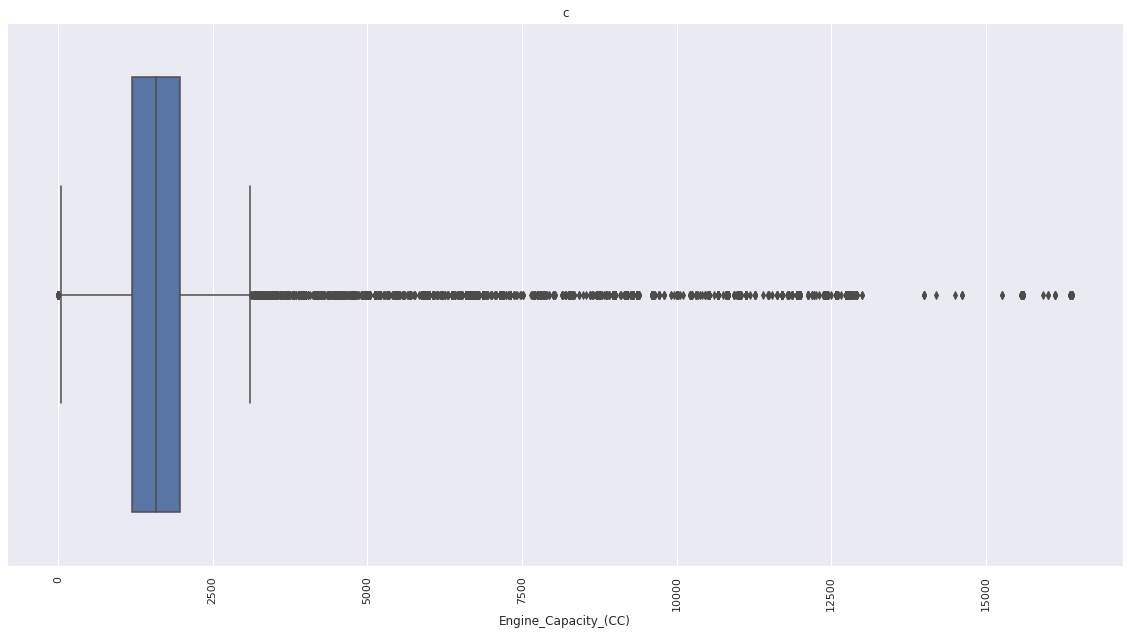

In [ ]:
boxplt(20,10,'c',vehicle, 'Engine_Capacity_(CC)', None, 90)

In [ ]:
vehicle['Age_Band_of_Driver'] = pd.cut(x=vehicle['Age_of_Driver'], bins=[0,5,10,15,20,25,35,45,55,65,75, 120],labels=range(1,12))
vehicle['Age_Band_of_Vehicle'] = pd.cut(x=vehicle['Age_of_Vehicle'], bins=[-1,5,10,15,20,120],labels=range(1,6))
vehicle['Band_of_Engine_Capacity']= pd.cut(x=vehicle['Engine_Capacity_(CC)'], bins=[-1,500,1000,1500, 2000,2500,3000,5000, 7000, 20000],labels=range(1,10))

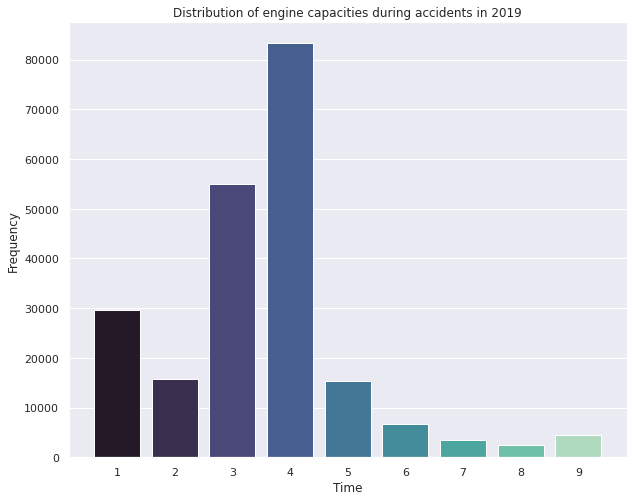

In [ ]:
subset = vehicle.groupby(['Band_of_Engine_Capacity']).size().reset_index()
barplt(10, 8, subset, 'Band_of_Engine_Capacity', 0, 'mako', 'Distribution of engine capacities during accidents in 2019', 'Time', 'Frequency', None, None, None)

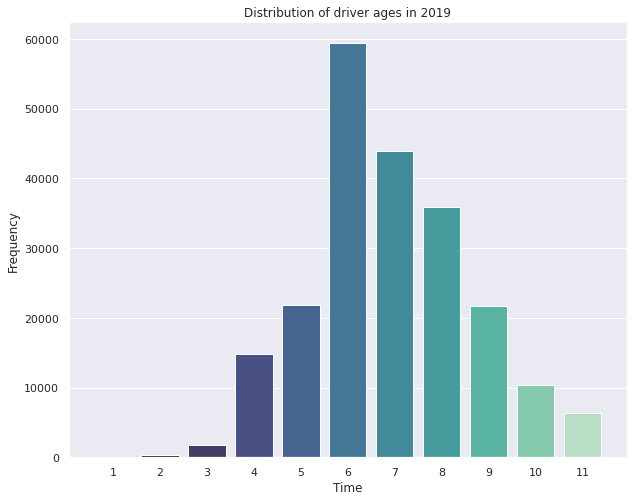

In [ ]:
subset = vehicle.groupby(['Age_Band_of_Driver']).size().reset_index()
barplt(10, 8, subset, 'Age_Band_of_Driver', 0, 'mako', 'Distribution of driver ages in 2019', 'Time', 'Frequency', None, None, None)

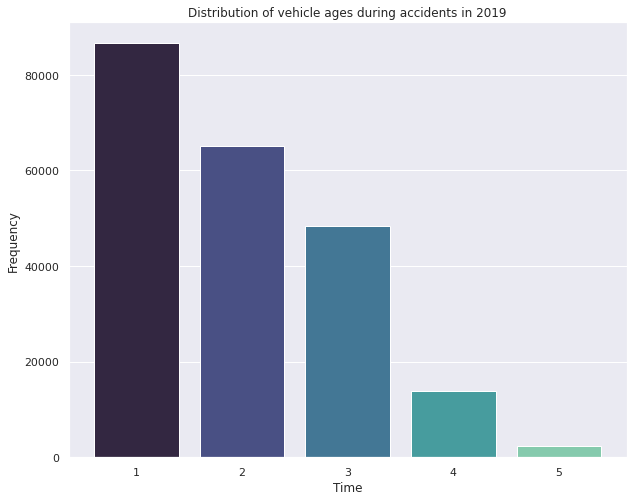

In [ ]:
subset = vehicle.groupby(['Age_Band_of_Vehicle']).size().reset_index()
barplt(10, 8, subset, 'Age_Band_of_Vehicle', 0, 'mako', 'Distribution of vehicle ages during accidents in 2019', 'Time', 'Frequency', None, None, None)

Creating a column stating if the object has hit something

In [ ]:
vehicle['Hit_Object'] = vehicle.apply(lambda row : 0 if (row.Hit_Object_in_Carriageway == 0 and row.Hit_Object_off_Carriageway ==0) else 1, axis =1)


Concatenating the vehicle location and junction location columns

In [ ]:
vehicle['Overall_Location'] = (vehicle['Hit_Object_in_Carriageway'].astype(int)).astype(str) + (vehicle['Hit_Object_off_Carriageway'].astype(int)).astype(str)

In [ ]:
vehicle['Overall_Location'].unique()

array(['00', '110', '40', '120', '71', '011', '04', '70', '90', '100',
       '07', '01', '02', '1011', '111', '60', '102', '711', '010', '80',
       '06', '101', '1111', '710', '107', '410', '106', '03', '104', '72',
       '05', '20', '77', '1110', '10', '411', '112', '105', '44', '910',
       '1010', '65', '91', '42', '510', '611', '116', '74', '50', '109',
       '09', '11', '41', '103', '114', '76', '117', '52', '45', '911',
       '122', '75', '125', '08', '126', '211', '94', '16', '14', '99',
       '26', '24', '67', '97', '124', '27', '46', '610', '96', '21',
       '1211', '79', '92', '47', '43', '69', '64', '123', '73', '49',
       '113', '129', '119', '68', '121', '108', '810', '87', '84', '30',
       '61', '1210', '85'], dtype=object)

In [ ]:
vehicle['Towed?'] = vehicle.apply(lambda row : 0 if (row.Towing_and_Articulation ==0) else 1, axis =1)
vehicle['Skid_or_Overturn?'] = vehicle.apply(lambda row : 0 if (row.Skidding_and_Overturning ==0) else 1, axis =1)
vehicle['left_carriageway?'] = vehicle.apply(lambda row : 3 if row.Vehicle_Leaving_Carriageway in [4,5,6,7,8] else (1 if row.Vehicle_Leaving_Carriageway in [1,2] else (2 if row.Vehicle_Leaving_Carriageway==3 else 0)), axis =1)



In [ ]:
from scipy.stats import skew
for col in vehicle.columns:
  if vehicle[col].isna().sum()==0:
    try:
      print( '\nSkewness for', col, ': ', skew(vehicle[col]))
      if skew(vehicle[col])>2 or skew(vehicle[col])<-2:
        subset = vehicle.groupby([col]).size().reset_index()
        #barplt(10, 8, subset, col, 0, 'mako', col, 'Time', 'Frequency', None, None, None)
    except:
      print(col)



Accident_Index

Skewness for Vehicle_Reference :  2.423244982257024
Label

Skewness for Vehicle_Type :  7.151137532800321

Skewness for Towing_and_Articulation :  12.62923712741574

Skewness for Vehicle_Manoeuvre :  -0.6202193960484957

Skewness for Vehicle_Location-Restricted_Lane :  6.579171238417892

Skewness for Junction_Location :  1.1671730653625487

Skewness for Skidding_and_Overturning :  4.905370252306754

Skewness for Hit_Object_in_Carriageway :  5.307167222219234

Skewness for Vehicle_Leaving_Carriageway :  4.716758637068291

Skewness for Hit_Object_off_Carriageway :  4.799115818100795

Skewness for 1st_Point_of_Impact :  0.780450513039576

Skewness for Was_Vehicle_Left_Hand_Drive? :  12.342650008131416

Skewness for Journey_Purpose_of_Driver :  -1.0373996303826076

Skewness for Sex_of_Driver :  1.0696173028823186

Skewness for Age_of_Driver :  0.6597975473801303

Skewness for Age_Band_of_Driver :  0.25604530349896565

Skewness for Engine_Capacity_(CC) :  4.232652727863756



## Accident Dataset

### Cleaning

Accident_Index                                     0
Location_Easting_OSGR                             28
Location_Northing_OSGR                            28
Longitude                                         28
Latitude                                          28
Police_Force                                       0
Accident_Severity                                  0
Number_of_Vehicles                                 0
Number_of_Casualties                               0
Date                                               0
Day_of_Week                                        0
Time                                              63
Local_Authority_(District)                         0
Local_Authority_(Highway)                          0
1st_Road_Class                                     0
1st_Road_Number                                    0
Road_Type                                          0
Speed_limit                                       80
Junction_Detail                               

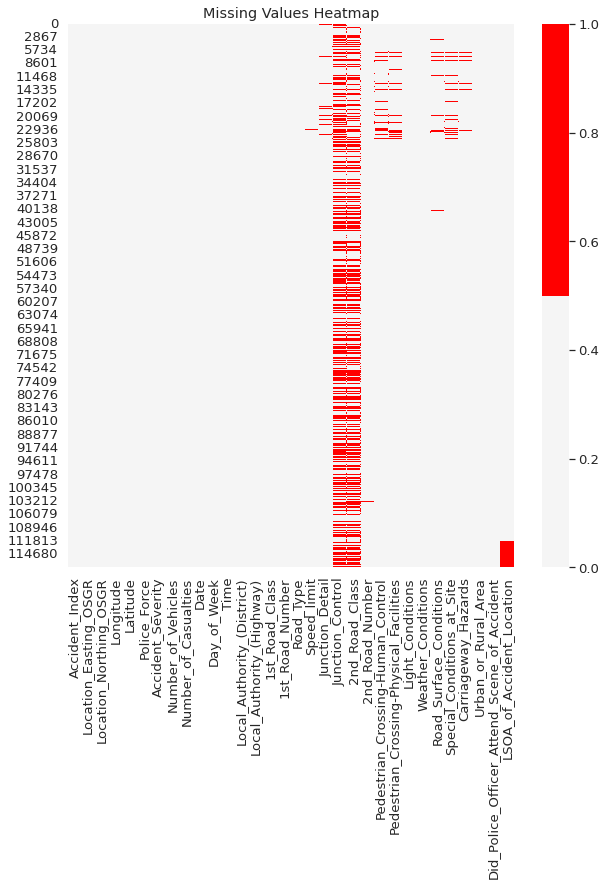

In [ ]:
accident = view_nan(accident, True, False)

It appears that the same 28 rows relating to location have missing values.

In [ ]:
accident[accident['Longitude'].isnull()==True]


Accident_Index  Location_Easting_OSGR  Location_Northing_OSGR  \
27337   2019040854828                    NaN                     NaN   
29369   2019051910615                    NaN                     NaN   
30791   2019051912864                    NaN                     NaN   
34816   2019070003662                    NaN                     NaN   
35505   2019070275916                    NaN                     NaN   
36347   2019070700923                    NaN                     NaN   
39798   2019121900341                    NaN                     NaN   
39919   2019121900485                    NaN                     NaN   
39933   2019121900505                    NaN                     NaN   
40179   2019121900771                    NaN                     NaN   
40399   2019121901033                    NaN                     NaN   
40451   2019121901096                    NaN                     NaN   
40659   2019121901327                    NaN                     NaN   
40723   2019121901399                    NaN                     NaN   
40885   2019121901582                    NaN                     NaN   
40891   2019121901588                    NaN                     NaN   
40946   2019122000042                    NaN                     NaN   
40976   2019122000077                    NaN                     NaN   
41049   2019122000278                    NaN                     NaN   
42953   20191367G1635                    NaN                     NaN   
48320   2019160864733                    NaN                     NaN   
59724   2019230919173                    NaN                     NaN   
90918   2019460853756                    NaN                     NaN   
97271   2019471902378                    NaN                     NaN   
107114  2019551900980                    NaN                     NaN   
107755  201960X043729                    NaN                     NaN   
109965  2019621900922                    NaN                     NaN   
111821  201963D115219                    NaN                     NaN   

        Longitude  Latitude  Police_Force  Accident_Severity  \
27337         NaN       NaN             4                  3   
29369         NaN       NaN             5                  3   
30791         NaN       NaN             5                  2   
34816         NaN       NaN             7                  3   
35505         NaN       NaN             7                  3   
36347         NaN       NaN             7                  3   
39798         NaN       NaN            12                  2   
39919         NaN       NaN            12                  3   
39933         NaN       NaN            12                  3   
40179         NaN       NaN            12                  3   
40399         NaN       NaN            12                  3   
40451         NaN       NaN            12                  3   
40659         NaN       NaN            12                  3   
40723         NaN       NaN            12                  3   
40885         NaN       NaN            12                  3   
40891         NaN       NaN            12                  3   
40946         NaN       NaN            12                  3   
40976         NaN       NaN            12                  3   
41049         NaN       NaN            12                  3   
42953         NaN       NaN            13                  3   
48320         NaN       NaN            16                  3   
59724         NaN       NaN            23                  3   
90918         NaN       NaN            46                  2   
97271         NaN       NaN            47                  3   
107114        NaN       NaN            55                  3   
107755        NaN       NaN            60                  2   
109965        NaN       NaN            62                  3   
111821        NaN       NaN            63                  3   

        Number_of_Vehicles  Number_of_Casualties        Date 

In [ ]:
accident['Time'].fillna('00:00', inplace = True)

In [ ]:
accident.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location'],
      dtype='object')

In [ ]:
accident = date_converter(accident, 'Date')
accident = time_converter(accident, 'Time')
accident.rename({'converted_time_Time': 'converted_time'}, axis=1, inplace=True)

In [ ]:
accident.columns

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'converted_time'],
      dtype='object')

In [ ]:
accident = accident.sort_values(by='Date')

In [ ]:
accident['Month'] = accident['Date'].apply(lambda x: x.month)


##### adding labels for weekdays and months

In [ ]:
accident['Day_of_Week'] = accident['Day_of_Week'].astype(int)
codes = [1,2,3,4,5,6,7]
day_labels = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekdays = pd.DataFrame(list(zip(codes, day_labels)), columns = ['Code', 'Day_Label'])
accident = weekdays.merge(accident, how = 'inner', left_on = 'Code', right_on = 'Day_of_Week')
accident.drop('Code', axis=1, inplace=True)

In [ ]:
accident['Month'] = accident['Month'].astype(int)
codes = [1,2,3,4,5,6,7,8,9,10,11,12]
month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months = pd.DataFrame(list(zip(codes, month_labels)), columns = ['Code', 'Month_Label'])
accident = months.merge(accident, how = 'inner', left_on = 'Code', right_on = 'Month')
accident.drop('Code', axis=1, inplace=True)

##### Light Conditions

In [ ]:
accident[accident['Light_Conditions'].isna()==True]

Month_Label Day_Label Accident_Index  Location_Easting_OSGR  \
11007    February    Monday  2019983103819               296905.0   

       Location_Northing_OSGR  Longitude   Latitude  Police_Force  \
11007                576133.0  -3.615979  55.068927            98   

       Accident_Severity  Number_of_Vehicles  Number_of_Casualties  \
11007                  3                   1                     1   

             Date  Day_of_Week                Time  \
11007  2019-02-11            2 2022-05-16 14:30:00   

       Local_Authority_(District) Local_Authority_(Highway)  1st_Road_Class  \
11007                         917                 S12000006               3   

       1st_Road_Number  Road_Type  Speed_limit  Junction_Detail  \
11007              781          6         30.0              0.0   

       Junction_Control  2nd_Road_Class  2nd_Road_Number  \
11007               NaN             NaN              0.0   

       Pedestrian_Crossing-Human_Control  \
11007                                NaN   

       Pedestrian_Crossing-Physical_Facilities  Light_Conditions  \
11007                                      NaN               NaN   

       Weather_Conditions  Road_Surface_Conditions  \
11007                   1                      NaN   

       Special_Conditions_at_Site  Carriageway_Hazards  Urban_or_Rural_Area  \
11007                         NaN                  NaN                    1   

       Did_Police_Officer_Attend_Scene_of_Accident LSOA_of_Accident_Location  \
11007                                            2                       NaN   

       converted_time  Month  
11007            14.5      2

In [ ]:
accident.columns

Index(['Month_Label', 'Day_Label', 'Accident_Index', 'Location_Easting_OSGR',
       'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force',
       'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)',
       'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number',
       'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
       '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'converted_time', 'Month'],
      dtype='object')

In [ ]:
accident = nan_imputer(accident, 'Light_Conditions', ['Urban_or_Rural_Area', 'Speed_limit', 'Local_Authority_(District)', 'Day_of_Week', 'converted_time'])


##### Longitude, Latitude, Locations East and North

In [ ]:

accident = nan_imputer(accident, 'Longitude', ['Local_Authority_(District)',	'Local_Authority_(Highway)', '1st_Road_Class',	 'Speed_limit', 'Day_of_Week', 'converted_time'])
accident = nan_imputer(accident, 'Latitude', ['Local_Authority_(District)',	'Local_Authority_(Highway)', '1st_Road_Class',	 'Speed_limit', 'Day_of_Week', 'converted_time'])
accident = nan_imputer(accident, 'Location_Easting_OSGR', [	'Local_Authority_(Highway)', '1st_Road_Class',	 'Speed_limit', 'Day_of_Week', 'converted_time'])
accident = nan_imputer(accident, 'Location_Northing_OSGR', ['Local_Authority_(Highway)', '1st_Road_Class',	 'Speed_limit', 'Day_of_Week', 'converted_time'])



##### Speed Limit

In [ ]:
accident[accident['Speed_limit'].isna()==True]
accident = nan_imputer(accident, 'Speed_limit', ['Local_Authority_(District)', '1st_Road_Class', 'Did_Police_Officer_Attend_Scene_of_Accident', 'Road_Type'])


##### 2nd Road Number

In [ ]:
accident[accident['2nd_Road_Number'].isna()==True]
accident = nan_imputer(accident, '2nd_Road_Number', ['Local_Authority_(District)', 'Speed_limit', 'Did_Police_Officer_Attend_Scene_of_Accident', '1st_Road_Number'])


##### Road Surface Conditions

In [ ]:
accident[accident['Road_Surface_Conditions'].isna()==True]
accident = nan_imputer(accident, 'Road_Surface_Conditions', ['Road_Type', 'Weather_Conditions', 'Light_Conditions'])


##### Junction Detail

In [ ]:
accident[accident['Junction_Detail'].isna()==True]

accident = nan_imputer(accident, 'Junction_Detail', ['1st_Road_Class', '2nd_Road_Class', 'Speed_limit', 'Junction_Control'])


In [ ]:
for col in ['Junction_Control', 'Carriageway_Hazards', 'LSOA_of_Accident_Location', '2nd_Road_Class']:
  accident.loc[(accident[col].isna()==True), col] = 99


##### Special Conditions on Site

In [ ]:
accident[accident['Special_Conditions_at_Site'].isna()==True]
accident = nan_imputer(accident, 'Special_Conditions_at_Site', ['1st_Road_Class', '2nd_Road_Class', 'Speed_limit', 'Junction_Control'])


In [ ]:
accident[accident['Pedestrian_Crossing-Human_Control'].isna()==True]
for col in ['Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities']:
  accident = nan_imputer(accident, col, ['1st_Road_Class', '2nd_Road_Class', 'Speed_limit', 'Junction_Control'])

Counter(accident['Pedestrian_Crossing-Physical_Facilities'])

Counter({0.0: 92045,
         0.5: 9,
         1.0: 5534,
         2.5: 2,
         3.0: 11,
         4.0: 6619,
         4.5: 24,
         5.0: 10059,
         7.0: 259,
         8.0: 2974})

In [ ]:
accident['Pedestrian_Crossing-Physical_Facilities'] = accident['Pedestrian_Crossing-Physical_Facilities'].replace(2,0)
accident['Pedestrian_Crossing-Physical_Facilities'] = accident['Pedestrian_Crossing-Physical_Facilities'].replace(3,0)

In [ ]:
accident['converted_time_classes'] = pd.cut(x=accident['converted_time'], bins=np.arange(-.5,24.5,0.5),labels=range(1,50))


Month_Label                                    0
Day_Label                                      0
Accident_Index                                 0
Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
Day_of_Week                                    0
Time                                           0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Detail     

Month_Label Day_Label Accident_Index  Location_Easting_OSGR  \
0          January    Sunday  201931A005919               444670.0   
1          January    Sunday  2019500811518               249906.0   
2          January    Sunday  2019450806039               514104.0   
3          January    Sunday  2019320006728               521244.0   
4          January    Sunday  2019450806056               524317.0   
...            ...       ...            ...                    ...   
117531    December  Saturday  2019051913357               330343.0   
117532    December  Saturday  2019052000001               350574.0   
117533    December  Saturday  2019010227501               511794.0   
117534    December  Saturday  2019370923547               580463.0   
117535    December  Saturday  2019052000062               338277.0   

        Location_Northing_OSGR  Longitude   Latitude  Police_Force  \
0                     351904.0  -1.334881  53.062541            31   
1                      60473.0  -4.114414  50.424870            50   
2                     156266.0  -0.364877  51.294099            45   
3                     357853.0  -0.190424  53.104128            32   
4                     141053.0  -0.223741  51.155233            45   
...                        ...        ...        ...           ...   
117531                392663.0  -3.049748  53.426155             5   
117532                397058.0  -2.746014  53.467943             5   
117533                183222.0  -0.389503  51.536842             1   
117534                286460.0   0.653967  52.446313            37   
117535                398731.0  -2.931559  53.481679             5   

        Accident_Severity  Number_of_Vehicles  Number_of_Casualties  \
0                       3                   1                     1   
1                       3                   2                     1   
2                       3                   2                     1   
3                       3                   2                     2   
4                       3                   1                     1   
...                   ...                 ...                   ...   
117531                  3                   2                     1   
117532                  3                   2                     1   
117533                  2                   2                     1   
117534                  3                   2                     2   
117535                  3                   2                     1   

              Date  Day_of_Week                Time  \
0       2019-01-06            1 2022-05-16 19:05:00   
1       2019-01-06            1 2022-05-16 10:53:00   
2       2019-01-06            1 2022-05-16 03:40:00   
3       2019-01-06            1 2022-05-16 00:30:00   
4       2019-01-06            1 2022-05-16 10:20:00   
...            ...          ...                 ...   
117531  2019-12-28            7 2022-05-16 11:30:00   
117532  2019-12-28            7 2022-05-16 07:30:00   
117533  2019-12-28            7 2022-05-16 03:30:00   
117534  2019-12-28            7 2022-05-16 15:55:00   
117535  2019-12-28            7 2022-05-16 12:48:00   

        Local_Authority_(District) Local_Authority_(Highway)  1st_Road_Class  \
0                              340                 E10000024               4   
1                              583                 E06000026               3   
2                              512                 E10000030               6   
3                              351                 E10000019               3   
4                              512                 E10000030               6   
...                            ...                       ...             ...   
117531                          95                 E08000015               6   
117532                          92                 E08000013               6   
117533                          27                 E09000009               3   
117534     

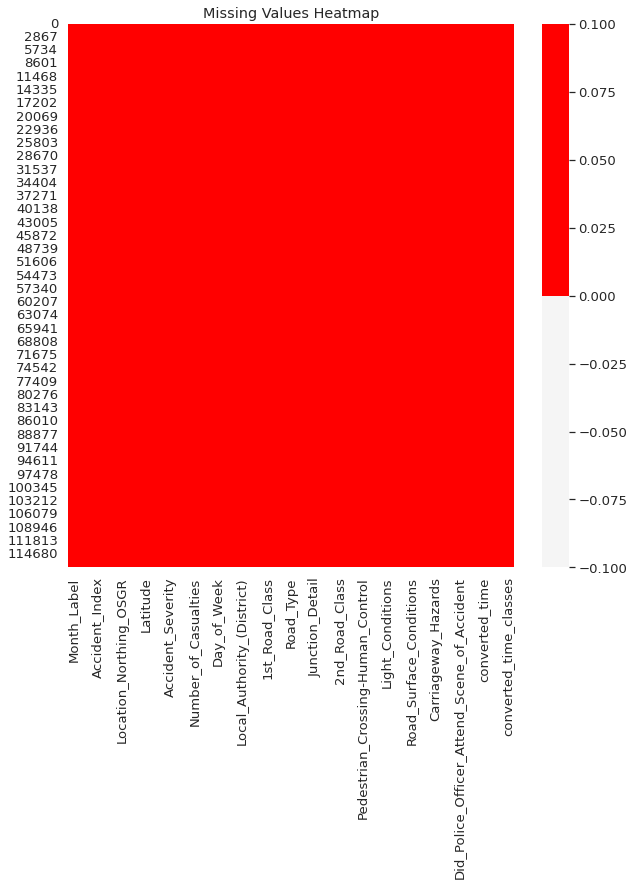

In [ ]:
view_nan(accident, True, False)

##### Creating columns for sunrise times, sunset times, and day length.

**This dataset was collated from**: https://www.sunrise-and-sunset.com/en/sun/russia/uk/2019

In [ ]:
sunset = pd.read_csv('sunset_sunrise.csv')
sunset.columns = sunset.iloc[0, :]
sunset = sunset.iloc[1:, :]

In [ ]:
#converting all the columns to date and time formats
sunset = date_converter(sunset, 'Date')
sunset  =time_converter(sunset, 'Sunset')
sunset  =time_converter(sunset, 'Sunrise')
sunset  =time_converter(sunset, 'Day length')


In [ ]:
#dropping completely blank rows in the dataframe
sunset.dropna(inplace=True)
sunset.drop(['Sunrise', 'Sunset', 'Day length'], axis=1, inplace=True)

In [ ]:
sunset['Date'] = pd.to_datetime(sunset['Date'])

In [ ]:
accident['Date']=pd.to_datetime(accident['Date'])

In [ ]:
#merging with the accident file
accident =accident.merge(sunset, how='inner', on='Date')

##### Creating converted time classes and district classes column

In [ ]:
#creating columns of converted times
for col in ['converted_time_Sunrise', 'converted_time_Sunset', 'converted_time_Day length']:
  accident[col+'_classes'] = pd.cut(x=accident[col], bins=np.arange(-.5,24.5,0.5),labels=range(1,50))

accident['converted_time_classes'] = pd.cut(x=accident['converted_time'], bins=np.arange(-1,25,1),labels=range(1,26))

#grouping district classes together
accident['district_classes'] = pd.cut(x=accident['Local_Authority_(District)'], bins=np.arange(-100,1100,100),labels=range(1,12))
acc_temp = accident.copy()

In [ ]:
accident = df_round(accident, ['converted_time', 'converted_time_Sunrise', 'converted_time_Sunset', 'converted_time_Day length', 'Latitude', 'Longitude'])


## Casualty

### Cleaning

Accident_Index                            0
Vehicle_Reference                         0
Casualty_Reference                        0
Casualty_Class                            0
Sex_of_Casualty                         733
Age_of_Casualty                        3255
Age_Band_of_Casualty                   3255
Casualty_Severity                         0
Pedestrian_Location                       1
Pedestrian_Movement                       0
Car_Passenger                           589
Bus_or_Coach_Passenger                   84
Pedestrian_Road_Maintenance_Worker       74
Casualty_Type                             5
Casualty_Home_Area_Type               17381
Casualty_IMD_Decile                   15372
dtype: int64


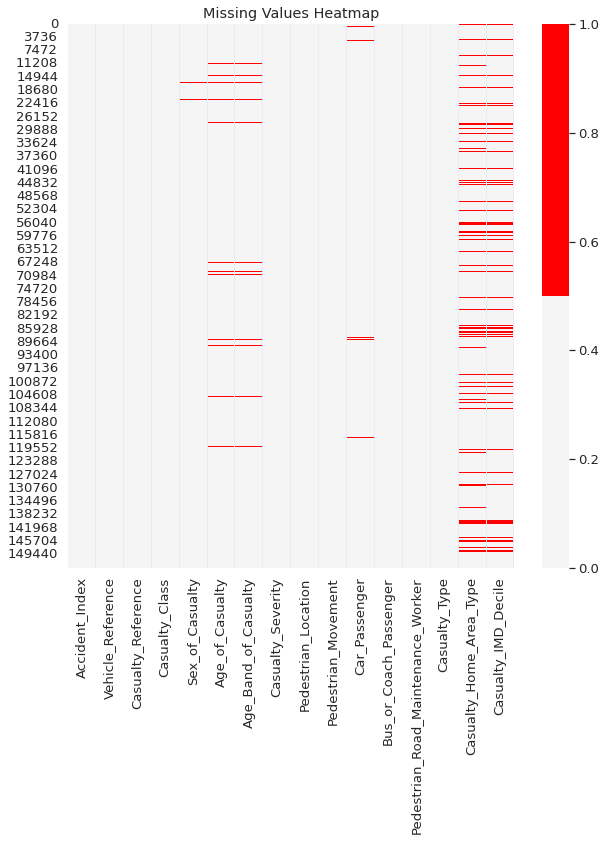

In [ ]:
casualty = view_nan(casualty, True, False)

##### Pedestrian Location

In [ ]:
casualty[casualty['Pedestrian_Location'].isna()==True]
casualty = nan_imputer(casualty, 'Pedestrian_Location', ['Sex_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity', 'Casualty_Class'])


##### Casualty Type

In [ ]:
casualty[casualty['Casualty_Type'].isna()==True]
casualty = nan_imputer(casualty, 'Casualty_Type', ['Sex_of_Casualty', 'Casualty_Severity', 'Age_Band_of_Casualty', 'Casualty_Class','Casualty_Severity', 'Casualty_Home_Area_Type'])


##### Sex of Casualty

In [ ]:
casualty[casualty['Sex_of_Casualty'].isna()==True]
casualty = nan_imputer(casualty, 'Sex_of_Casualty', ['Casualty_Class', 'Casualty_Type','Casualty_Severity'])


##### Age of Casualty

In [ ]:
casualty[casualty['Age_of_Casualty'].isna()==True]
casualty = nan_imputer(casualty, 'Age_of_Casualty', ['Casualty_Class', 'Casualty_Type', 'Casualty_Severity', 'Sex_of_Casualty','Casualty_Home_Area_Type'])


##### Maintenance Worker

In [ ]:
casualty[casualty['Pedestrian_Road_Maintenance_Worker'].isna()==True]
casualty = nan_imputer(casualty, 'Pedestrian_Road_Maintenance_Worker', ['Pedestrian_Location', 'Pedestrian_Movement'])


##### Bus or Coach Passenger

The ones listed as bus or coach occupant in casualty type were assigned a random value in the bus or coach passenger column to indicate what they were doing.

In [ ]:
casualty[casualty['Bus_or_Coach_Passenger'].isna()==True]
casualty.loc[((casualty['Bus_or_Coach_Passenger'].isna()==True) & (casualty['Casualty_Type']==11)),'Bus_or_Coach_Passenger'] = casualty.loc[((casualty['Bus_or_Coach_Passenger'].isna()==True) & (casualty['Casualty_Type']==11)),'Bus_or_Coach_Passenger'].apply(lambda x: random.randint(1,4))


If the vehicle type was not 11 (for a bus or coach occupant), the NaN was imputed with 0 (not a bus or coach passenger).

In [ ]:
casualty['Bus_or_Coach_Passenger'].fillna(0, inplace=True)

##### Car Passenger

Same as bus or coach passenger but with vehicle type 9.

In [ ]:
casualty[casualty['Car_Passenger'].isna()==True]
casualty.loc[((casualty['Car_Passenger'].isna()==True) & (casualty['Casualty_Type']==9)),'Car_Passenger'] = casualty.loc[((casualty['Car_Passenger'].isna()==True) & (casualty['Casualty_Type']==9)),'Car_Passenger'].apply(lambda x: random.randint(1,2))


In [ ]:
casualty['Car_Passenger'].fillna(0, inplace=True)

##### Casualty Home Area Type

In [ ]:
casualty[casualty['Casualty_Home_Area_Type'].isna()==True]
casualty = nan_imputer(casualty, 'Casualty_Home_Area_Type', ['Casualty_Type', 'Casualty_Class', 'Car_Passenger', 'Bus_or_Coach_Passenger'])


##### Age Band of Casualty

In [ ]:
casualty['Age_Band_of_Casualty'] = pd.cut(x=casualty['Age_of_Casualty'], bins=[-1,5,10,15,20,25,35,45,55,65,75, 120],labels=range(1,12))


Accident_Index                            0
Vehicle_Reference                         0
Casualty_Reference                        0
Casualty_Class                            0
Sex_of_Casualty                           0
Age_of_Casualty                           0
Age_Band_of_Casualty                      0
Casualty_Severity                         0
Pedestrian_Location                       0
Pedestrian_Movement                       0
Car_Passenger                             0
Bus_or_Coach_Passenger                    0
Pedestrian_Road_Maintenance_Worker        0
Casualty_Type                             0
Casualty_Home_Area_Type                   0
Casualty_IMD_Decile                   15372
dtype: int64


Accident_Index  Vehicle_Reference  Casualty_Reference  Casualty_Class  \
0       2019010128300                  1                   1               1   
1       2019010128300                  1                   2               2   
2       2019010128300                  1                   3               2   
3       2019010152270                  1                   1               1   
4       2019010155191                  2                   1               2   
...               ...                ...                 ...             ...   
153153  2019984106919                  1                   1               1   
153154  2019984107019                  1                   1               1   
153155  2019984107219                  2                   1               1   
153156  2019984107419                  1                   1               3   
153157  201998QC01004                  1                   1               1   

        Sex_of_Casualty  Age_of_Casualty Age_Band_of_Casualty  \
0                   1.0             58.0                    9   
1                   2.0             28.0                    6   
2                   2.0             28.0                    6   
3                   2.0             24.0                    5   
4                   2.0             21.0                    5   
...                 ...              ...                  ...   
153153              1.0             24.0                    5   
153154              1.0             22.0                    5   
153155              1.0             61.0                    9   
153156              1.0             54.0                    8   
153157              1.0             55.0                    8   

        Casualty_Severity  Pedestrian_Location  Pedestrian_Movement  \
0                       3                  0.0                    0   
1                       3                  0.0                    0   
2                       3                  0.0                    0   
3                       3                  0.0                    0   
4                       3                  0.0                    0   
...                   ...                  ...                  ...   
153153                  3                  0.0                    0   
153154                  3                  0.0                    0   
153155                  3                  0.0                    0   
153156                  3                  5.0                    3   
153157                  2                  0.0                    0   

        Car_Passenger  Bus_or_Coach_Passenger  \
0                 0.0                     0.0   
1                 1.0                     0.0   
2                 2.0                     0.0   
3                 0.0                     0.0   
4                 0.0                     0.0   
...               ...                     ...   
153153            0.0                     0.0   
153154            0.0                     0.0   
153155            0.0                     0.0   
153156            0.0                     0.0   
153157            0.0                     0.0   

        Pedestrian_Road_Maintenance_Worker  Casualty_Type  \
0                                      0.0            9.0   
1                                      0.0            9.0   
2                                      0.0            9.0   
3                                      0.0            9.0   
4                                      0.0            1.0   
...                                    ...            ...   
153153                                 0.0           19.0   
153154                                 0.0           19.0   
153155                                 0.0            9.0   
153156                                 0.0            0.0   
153157                                 0.0            5.0   

        Casualty_Home_Area_Type  Casualty_IMD_Decile  
0                           1.0    

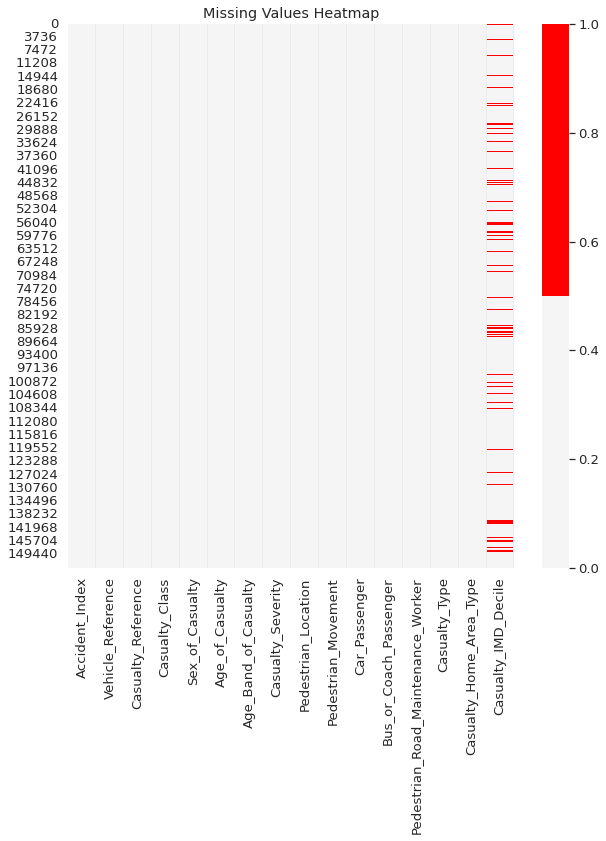

In [ ]:
casualty = df_round(casualty)
view_nan(casualty, True, False)

# Visualizations

### Merging dataframes

In [ ]:
v_acc = vehicle.merge(accident, how='inner', on='Accident_Index')
c_acc = casualty.merge(accident, how='inner', on='Accident_Index')
vac_merged = casualty.merge(v_acc, how = 'inner', on='Accident_Index')

Accident_Index                                     0
Vehicle_Reference                                  0
Casualty_Reference                                 0
Casualty_Class                                     0
Sex_of_Casualty                                    0
Age_of_Casualty                                    0
Age_Band_of_Casualty                               0
Casualty_Severity                                  0
Pedestrian_Location                                0
Pedestrian_Movement                                0
Car_Passenger                                      0
Bus_or_Coach_Passenger                             0
Pedestrian_Road_Maintenance_Worker                 0
Casualty_Type                                      0
Casualty_Home_Area_Type                            0
Casualty_IMD_Decile                            13162
Month_Label                                        0
Day_Label                                          0
Location_Easting_OSGR                         

Accident_Index  Vehicle_Reference  Casualty_Reference  Casualty_Class  \
0       2019010128300                  1                   1               1   
1       2019010128300                  1                   2               2   
2       2019010128300                  1                   3               2   
3       2019010152270                  1                   1               1   
4       2019010155191                  2                   1               2   
...               ...                ...                 ...             ...   
128588  2019984106919                  1                   1               1   
128589  2019984107019                  1                   1               1   
128590  2019984107219                  2                   1               1   
128591  2019984107419                  1                   1               3   
128592  201998QC01004                  1                   1               1   

        Sex_of_Casualty  Age_of_Casualty Age_Band_of_Casualty  \
0                   1.0             58.0                    9   
1                   2.0             28.0                    6   
2                   2.0             28.0                    6   
3                   2.0             24.0                    5   
4                   2.0             21.0                    5   
...                 ...              ...                  ...   
128588              1.0             24.0                    5   
128589              1.0             22.0                    5   
128590              1.0             61.0                    9   
128591              1.0             54.0                    8   
128592              1.0             55.0                    8   

        Casualty_Severity  Pedestrian_Location  Pedestrian_Movement  \
0                       3                  0.0                    0   
1                       3                  0.0                    0   
2                       3                  0.0                    0   
3                       3                  0.0                    0   
4                       3                  0.0                    0   
...                   ...                  ...                  ...   
128588                  3                  0.0                    0   
128589                  3                  0.0                    0   
128590                  3                  0.0                    0   
128591                  3                  5.0                    3   
128592                  2                  0.0                    0   

        Car_Passenger  Bus_or_Coach_Passenger  \
0                 0.0                     0.0   
1                 1.0                     0.0   
2                 2.0                     0.0   
3                 0.0                     0.0   
4                 0.0                     0.0   
...               ...                     ...   
128588            0.0                     0.0   
128589            0.0                     0.0   
128590            0.0                     0.0   
128591            0.0                     0.0   
128592            0.0                     0.0   

        Pedestrian_Road_Maintenance_Worker  Casualty_Type  \
0                                      0.0            9.0   
1                                      0.0            9.0   
2                                      0.0            9.0   
3                                      0.0            9.0   
4                                      0.0            1.0   
...                                    ...            ...   
128588                                 0.0           19.0   
128589                                 0.0           19.0   
128590                                 0.0            9.0   
128591                                 0.0            0.0   
128592                                 0.0            5.0   

        Casualty_Home_Area_Type  Casualty_IMD_Decile Month_Label Day_Label  \
0           

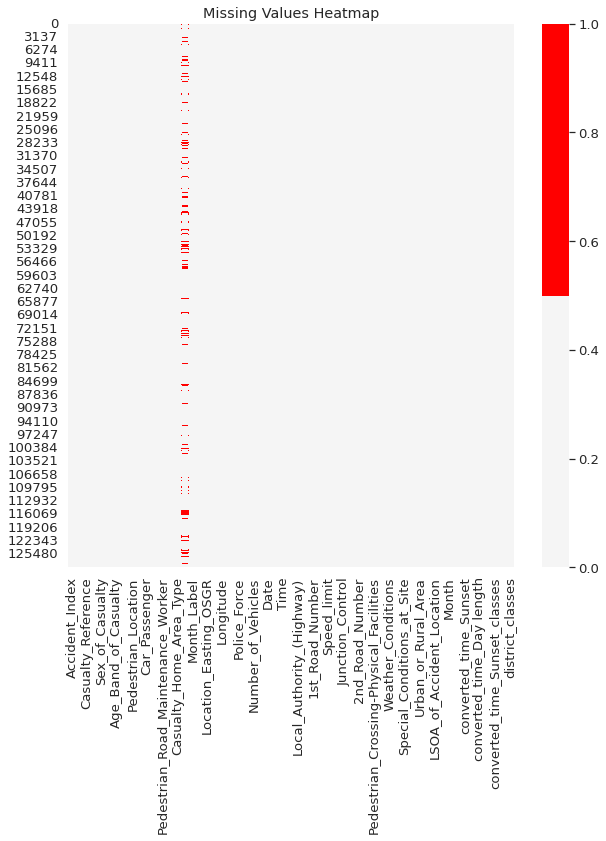

In [ ]:
view_nan(c_acc, True, False)

### Adding three separate columns based on number fatal, serious, and slight casualties

In [ ]:

#grouping the casualty severity data
subset = c_acc.groupby(['Accident_Index', 'Casualty_Severity']).size().reset_index()

#extracting rows which have slight severity
x = subset[subset['Casualty_Severity']=='3']
#renaming the number of slight casualties column
x.rename(columns={0:'Number_of_Slight_Casualties'}, inplace=True)
subset_new = x.merge(subset, on='Accident_Index', how ='outer')
subset_new.drop(['Casualty_Severity_x'], axis=1, inplace=True)

#extracting rows which have serious severity
x = subset[subset['Casualty_Severity']=='2']
#renaming the number of serious casualties column
x.rename(columns={0:'Number_of_Serious_Casualties'}, inplace=True)
subset_new = x.merge(subset_new, on='Accident_Index', how ='outer')
subset_new.drop(['Casualty_Severity'], axis=1, inplace=True)

#extracting rows which have fatal severity
x = subset[subset['Casualty_Severity']=='1']
#renaming the number of fatal casualties column
x.rename(columns={0:'Number_of_Fatal_Casualties'}, inplace=True)
subset_new = x.merge(subset_new, on='Accident_Index', how ='outer')
subset_new.drop(['Casualty_Severity', 'Casualty_Severity_y', 0], axis=1, inplace=True)
subset_new.fillna(0, inplace=True)

#merging the columns with the main accident dataset
subset_new
c_acc = c_acc.merge(subset_new, on='Accident_Index', how='inner')
c_acc = c_acc.drop_duplicates()
c_acc


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Accident_Index  Vehicle_Reference  Casualty_Reference  Casualty_Class  \
0       2019010128300                  1                   1               1   
1       2019010128300                  1                   2               2   
2       2019010128300                  1                   3               2   
3       2019010152270                  1                   1               1   
4       2019010155191                  2                   1               2   
...               ...                ...                 ...             ...   
141088  2019984106919                  1                   1               1   
141089  2019984107019                  1                   1               1   
141090  2019984107219                  2                   1               1   
141091  2019984107419                  1                   1               3   
141092  201998QC01004                  1                   1               1   

        Sex_of_Casualty  Age_of_Casualty Age_Band_of_Casualty  \
0                   1.0             58.0                    9   
1                   2.0             28.0                    6   
2                   2.0             28.0                    6   
3                   2.0             24.0                    5   
4                   2.0             21.0                    5   
...                 ...              ...                  ...   
141088              1.0             24.0                    5   
141089              1.0             22.0                    5   
141090              1.0             61.0                    9   
141091              1.0             54.0                    8   
141092              1.0             55.0                    8   

        Casualty_Severity  Pedestrian_Location  Pedestrian_Movement  \
0                       3                  0.0                    0   
1                       3                  0.0                    0   
2                       3                  0.0                    0   
3                       3                  0.0                    0   
4                       3                  0.0                    0   
...                   ...                  ...                  ...   
141088                  3                  0.0                    0   
141089                  3                  0.0                    0   
141090                  3                  0.0                    0   
141091                  3                  5.0                    3   
141092                  2                  0.0                    0   

        Car_Passenger  Bus_or_Coach_Passenger  \
0                 0.0                     0.0   
1                 1.0                     0.0   
2                 2.0                     0.0   
3                 0.0                     0.0   
4                 0.0                     0.0   
...               ...                     ...   
141088            0.0                     0.0   
141089            0.0                     0.0   
141090            0.0                     0.0   
141091            0.0                     0.0   
141092            0.0                     0.0   

        Pedestrian_Road_Maintenance_Worker  Casualty_Type  \
0                                      0.0            9.0   
1                                      0.0            9.0   
2                                      0.0            9.0   
3                                      0.0            9.0   
4                                      0.0            1.0   
...                                    ...            ...   
141088                                 0.0           19.0   
141089                                 0.0           19.0   
141090                                 0.0            9.0   
141091                                 0.0            0.0   
141092                                 0.0            5.0   

        Casualty_Home_Area_Type  Casualty_IMD_Decile Month_Label Day_Label  \
0           

##### distribution of accidents by day

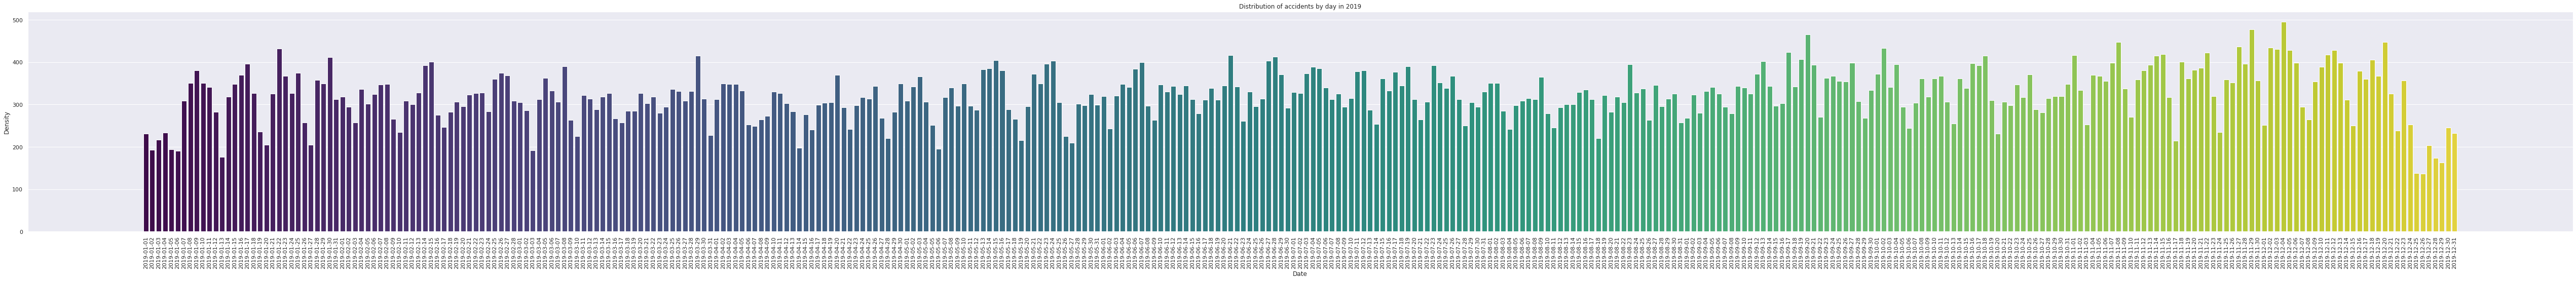

In [ ]:
subset = accident.groupby(['Date']).size().reset_index()
subset['Date'] = subset['Date'].dt.date
barplt(90,8, subset, 'Date', 0, 'viridis', 'Distribution of accidents by day in 2019', 'Date', 'Density', 90,None, None)

In [ ]:
subset.describe()

0
count  365.000000
mean   322.016438
std     58.637972
min    137.000000
25%    289.000000
50%    323.000000
75%    360.000000
max    495.000000

##### Accident Numbers on Celebratory Days

In [ ]:
#creating a dataframe of special occasion days
occasion = ['New Years', 'Christmas', 'Valentines', 'St. Patricks', 'April Fools', 'St. Georges', 'May Day', 'Halloween', 'Bonfire Night', 
            'Boxing Day', 'Black Friday', 'Eid ul Fitr', 'Eid ul Azha']
date = ['1/1/2019', '25/12/2019', '14/2/2019', '17/3/2019', '1/4/2019', '23/4/2019', '1/5/2019', '31/10/2019', '5/11/2019', '26/12/2019',
        '29/11/2019', '3/6/2019', '11/8/2019']
celebrations = pd.DataFrame(list(zip(occasion, date)), columns = ['occasion', 'date'])
celebrations = date_converter(celebrations, 'date')


In [ ]:
celebrations['date'] = pd.to_datetime(celebrations['date'])

In [ ]:
cel = celebrations.merge(accident, how='inner', left_on='date', right_on='Date')
cel = cel.groupby(['occasion', 'date']).size().reset_index()
cel['Weekday'] = cel['date'].apply(lambda x: x.weekday())


In [ ]:
cel

occasion       date    0  Weekday
0     April Fools 2019-01-04  233        4
1    Black Friday 2019-11-29  477        4
2   Bonfire Night 2019-05-11  297        5
3      Boxing Day 2019-12-26  137        3
4       Christmas 2019-12-25  138        2
5     Eid ul Azha 2019-11-08  448        4
6     Eid ul Fitr 2019-03-06  333        2
7       Halloween 2019-10-31  348        3
8         May Day 2019-01-05  194        5
9       New Years 2019-01-01  231        1
10    St. Georges 2019-04-23  298        1
11   St. Patricks 2019-03-17  258        6
12     Valentines 2019-02-14  392        3

##### Distribution of Accidents during christmas and new years

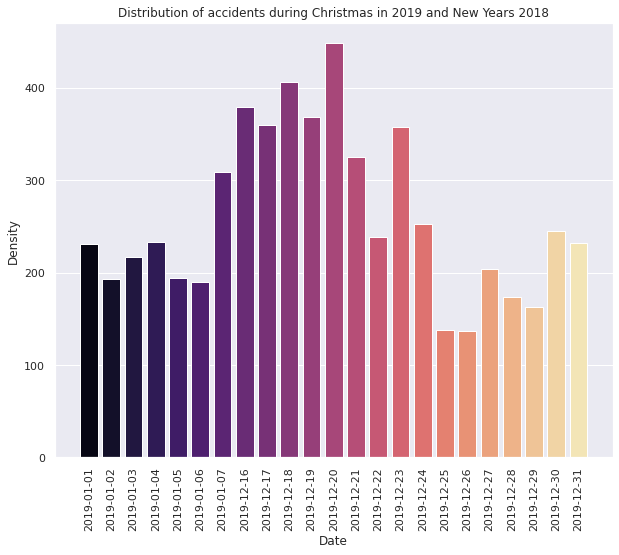

In [ ]:
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

subset = accident.groupby(['Date']).size().reset_index()
subset =subset[(subset['Date']>'2019-12-15') | (subset['Date']<'2019-1-8')]
subset['Date'] = subset['Date'].dt.date

barplt(10,8, subset, 'Date', 0, 'magma', 'Distribution of accidents during Christmas in 2019 and New Years 2018', 'Date', 'Density', 90,None, None)

##### accidents during black friday

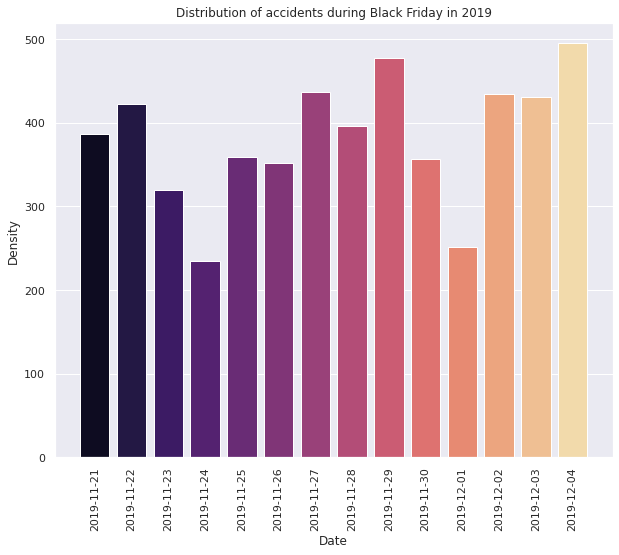

In [ ]:
subset = accident.groupby(['Date']).size().reset_index()
subset =subset[(subset['Date']>'2019-11-20') & (subset['Date']<'2019-12-5')]
subset['Date'] = subset['Date'].dt.date

barplt(10,8, subset, 'Date', 0, 'magma', 'Distribution of accidents during Black Friday in 2019', 'Date', 'Density', 90,None, None)

In [ ]:
def barplt(fig_x, fig_y, df, col_x, col_y, pal, title, xlabel, ylabel, rotate, bins, hue):
  sns.set_theme()
  plt.figure(figsize = (fig_x,fig_y))
  plt.xticks(rotation=rotate)
  sns.barplot(data = df, x=col_x, y =col_y, palette = pal)
  plt.locator_params(axis='x', nbins=bins)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)




##### Accidents by Weekday

###### Accidents on every Friday in 2019

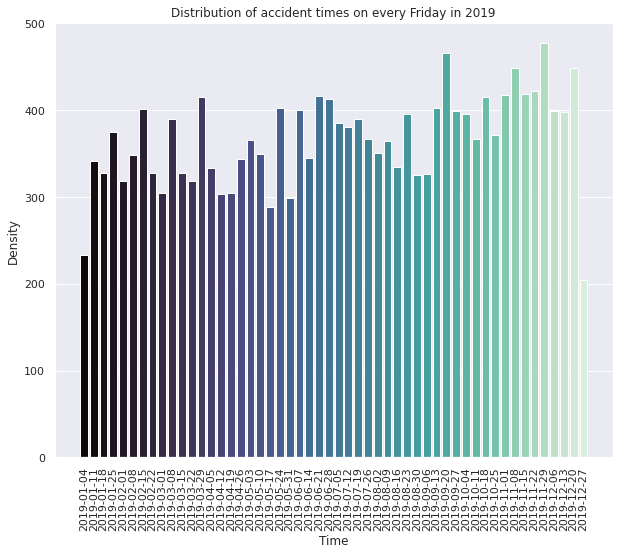

In [ ]:
subset = accident[accident['Day_of_Week']==6].groupby(['Date']).size().reset_index()
subset['Date'] = subset['Date'].dt.date
barplt(10,8, subset, 'Date', 0, 'mako', 'Distribution of accident times on every Friday in 2019', 'Time', 'Density', 90, None, None)

###### Accidents every Saturday

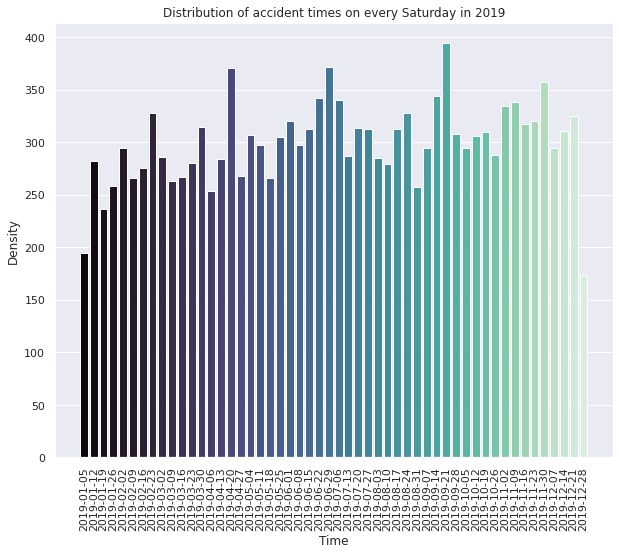

In [ ]:
subset = accident[accident['Day_of_Week']==7].groupby(['Date']).size().reset_index()
subset['Date'] = subset['Date'].dt.date
barplt(10,8, subset, 'Date', 0, 'mako', 'Distribution of accident times on every Saturday in 2019', 'Time', 'Density', 90, None, None)

###### Accidents every Thursday

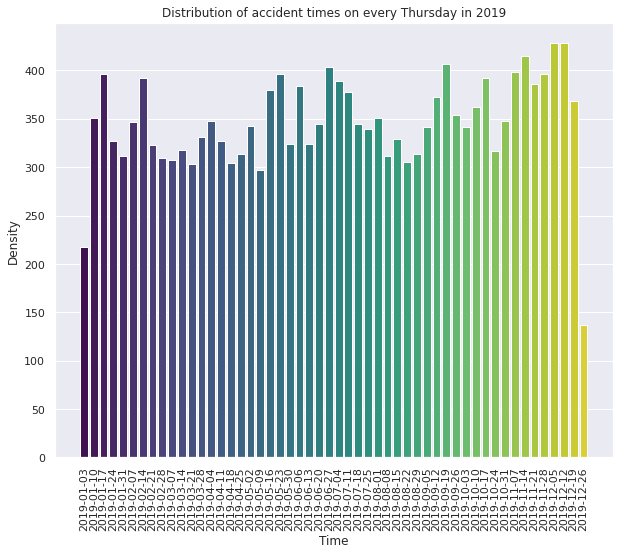

In [ ]:
subset = accident[accident['Day_of_Week']==5].groupby(['Date']).size().reset_index()
subset['Date'] = subset['Date'].dt.date
barplt(10,8, subset, 'Date', 0, 'viridis', 'Distribution of accident times on every Thursday in 2019', 'Time', 'Density', 90, None, None)

###### accidents every sunday

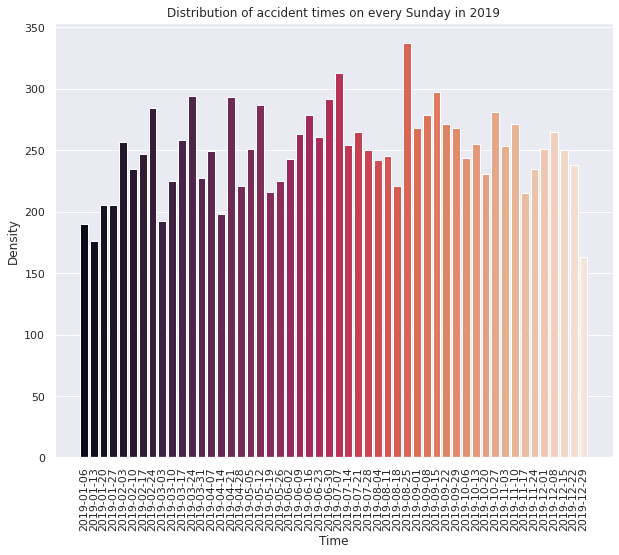

In [ ]:
subset = accident[accident['Day_of_Week']==1].groupby(['Date']).size().reset_index()
subset['Date'] = subset['Date'].dt.date
barplt(10,8, subset, 'Date', 0, 'rocket', 'Distribution of accident times on every Sunday in 2019', 'Time', 'Density', 90, None, None)

###### accidents every monday

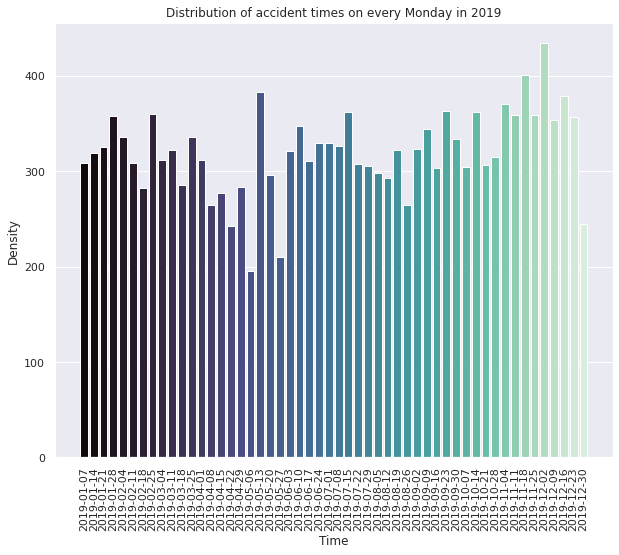

In [ ]:
subset = accident[accident['Day_of_Week']==2].groupby(['Date']).size().reset_index()
subset['Date'] = subset['Date'].dt.date
barplt(10,8, subset, 'Date', 0, 'mako', 'Distribution of accident times on every Monday in 2019', 'Time', 'Density', 90, None, None)

###### On all days of the week

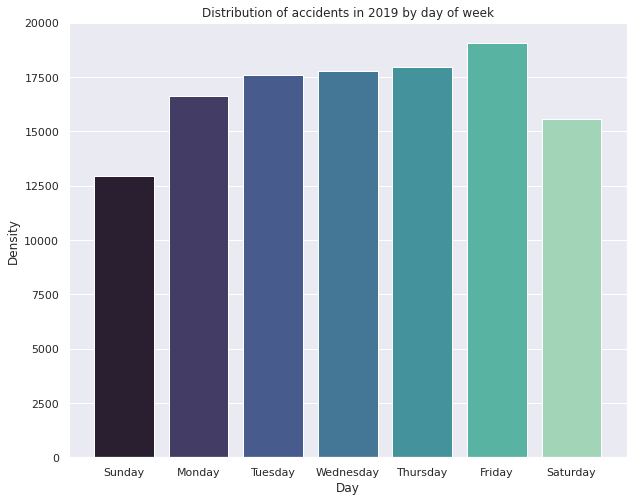

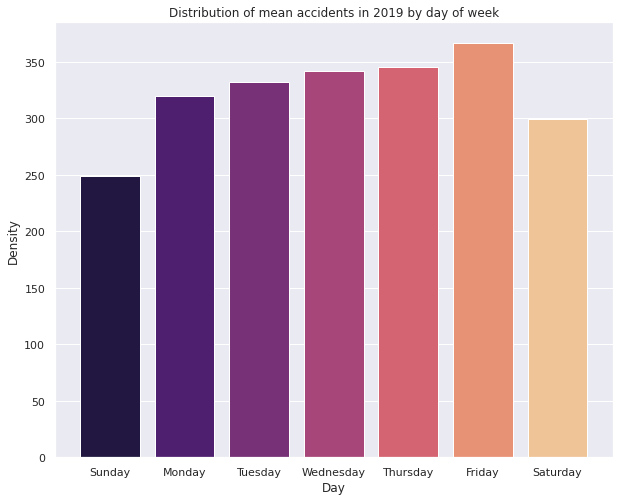

In [ ]:
subset = accident.groupby(['Day_of_Week','Day_Label']).size().reset_index()
barplt(10,8, subset, 'Day_Label', 0, 'mako', 'Distribution of accidents in 2019 by day of week', 'Day', 'Density', None, None, None)
subset = accident.groupby(['Date', 'Day_of_Week', 'Day_Label']).size().reset_index()
subset.drop('Date', axis=1, inplace=True)
mean_accs_weekday = subset.groupby(['Day_of_Week','Day_Label']).mean().reset_index()
barplt(10,8, mean_accs_weekday, 'Day_Label', 0, 'magma', 'Distribution of mean accidents in 2019 by day of week', 'Day', 'Density', None, None, None)


##### Accidents by Month

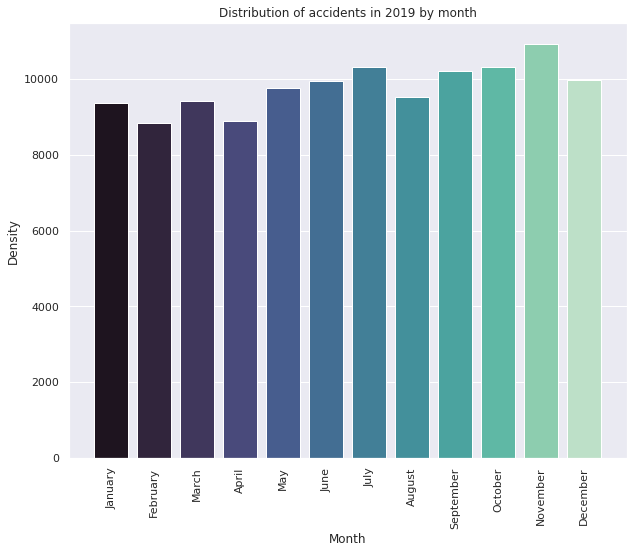

In [ ]:
subset = accident.groupby(['Month','Month_Label']).size().reset_index()
barplt(10,8, subset, 'Month_Label', 0, 'mako', 'Distribution of accidents in 2019 by month', 'Month', 'Density', 90, None, None)


##### Time

<Figure size 1440x1080 with 0 Axes>

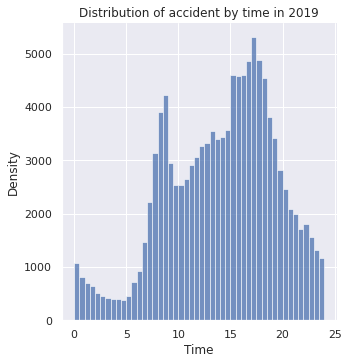

In [ ]:
#accidents every hour
displt(20, 15, accident, 'converted_time', .5, 'mako', 'Distribution of accident by time in 2019', 'Time', 'Density', None, None, None)

In [ ]:
subset = accident.groupby(['converted_time_classes']).size().reset_index()

In [ ]:
subset = accident.groupby(['Day_of_Week', 'converted_time_classes']).size().reset_index()

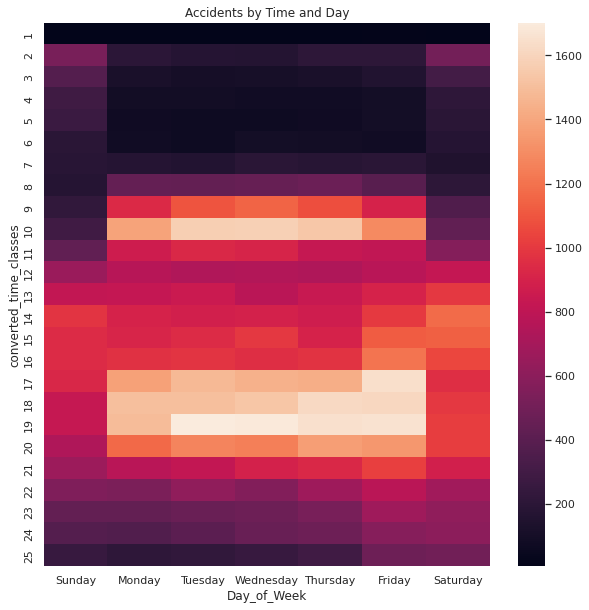

In [ ]:
#Accidents by time and day

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.figure(figsize = (10,10))
plt.title('Accidents by Time and Day')
heatplot = sns.heatmap(subset.pivot(index='converted_time_classes', columns='Day_of_Week', values=0))
heatplot.set_xticklabels(days)

plt.show()

##### Frequency of accidents by vehicle type

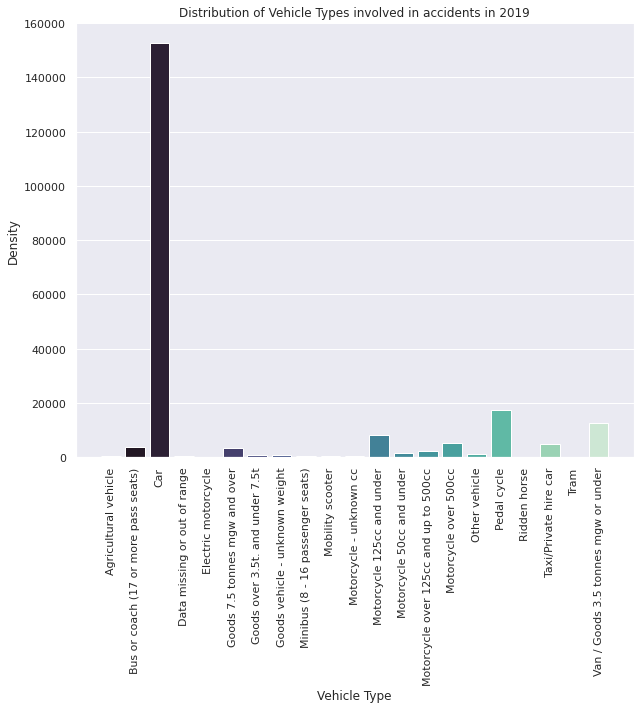

In [ ]:
subset = vehicle.groupby(['Label']).size().reset_index()
barplt(10,8, subset, 'Label', 0, 'mako', 'Distribution of Vehicle Types involved in accidents in 2019', 'Vehicle Type', 'Density', 90, None, None)
#locs, labels = plt.xticks()
#plt.xticks(locs, types, rotation = 90)


###### Car

<Figure size 1080x720 with 0 Axes>

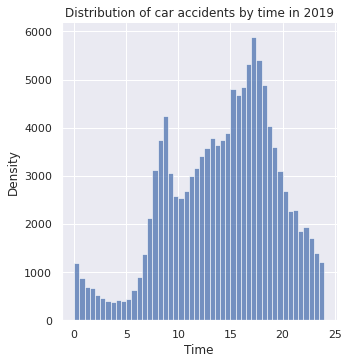

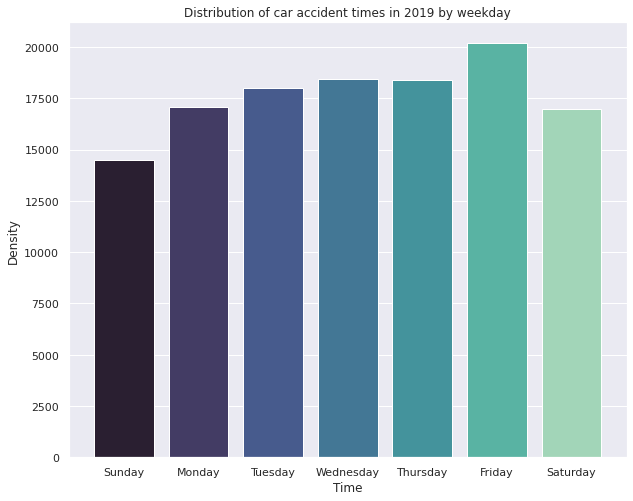

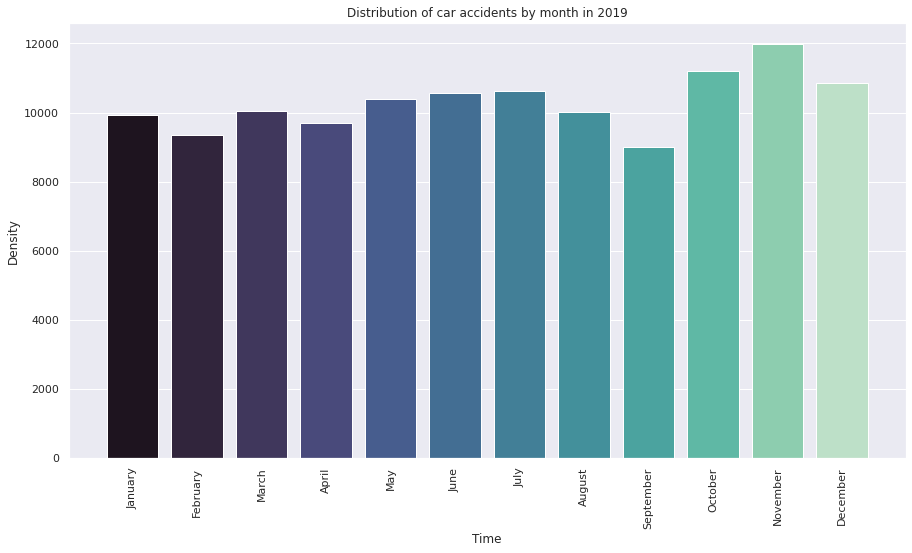

In [ ]:
displt(15, 10, v_acc[v_acc['Vehicle_Type']==9], 'converted_time', .5, 'mako', 'Distribution of car accidents by time in 2019', 'Time', 'Density',None, None, None)
barplt(10,8, v_acc[v_acc['Vehicle_Type']==9].groupby(['Day_of_Week', 'Day_Label']).size().reset_index(), 'Day_Label', 0, 'mako', 'Distribution of car accident times in 2019 by weekday', 'Time', 'Density', None, None, None)
barplt(15,8, v_acc[v_acc['Vehicle_Type']==9].groupby(['Month', 'Month_Label']).size().reset_index(), 'Month_Label', 0, 'mako', 'Distribution of car accidents by month in 2019', 'Time', 'Density', 90, 365, None)


###### Bike accidents by time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


<Figure size 1080x720 with 0 Axes>

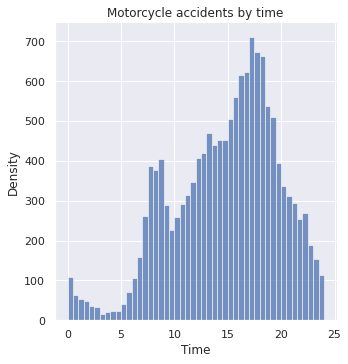

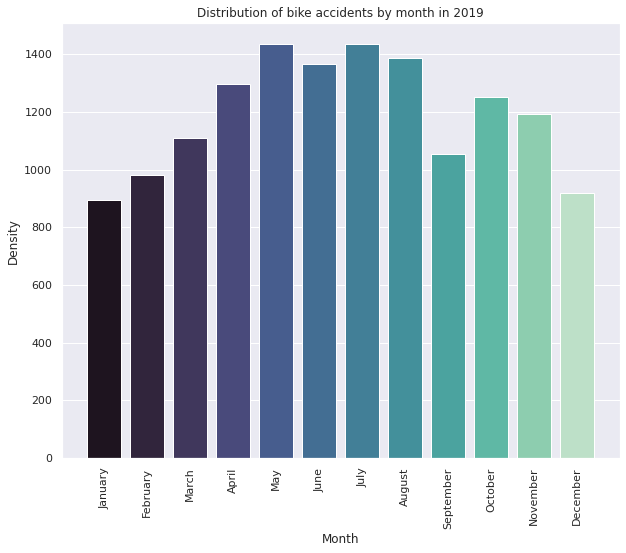

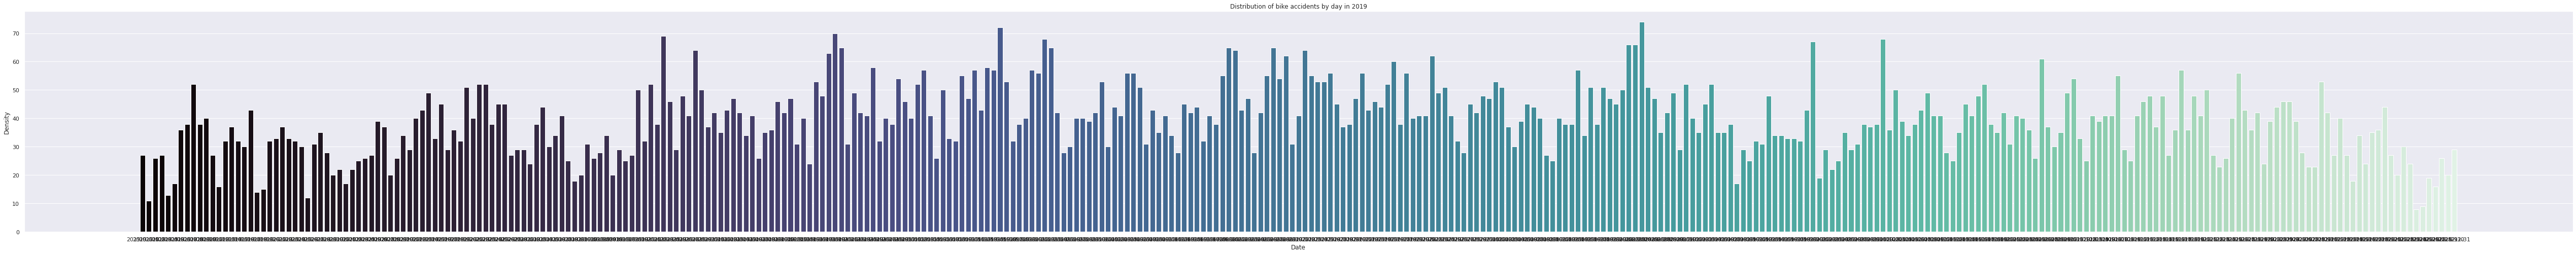

In [ ]:
bikes =  (v_acc[((v_acc['Vehicle_Type']>=2) & (v_acc['Vehicle_Type']<=5)) | (v_acc['Vehicle_Type']==97) | (v_acc['Vehicle_Type']==23)])

#number of accidents by different cc's of motorbikes according to time of day
displt(15, 10, bikes, 'converted_time', .5, 'mako', 'Motorcycle accidents by time', 'Time', 'Density',None,None, None)

#number of accidents by all motorbikes according to month
barplt(10,8, bikes.groupby(['Month', 'Month_Label']).size().reset_index(), 'Month_Label', 0, 'mako', 'Distribution of bike accidents by month in 2019', 'Month', 'Density', 90, None, None)

#number of accidents by all motorbikes according to month
bikes['Date'] = bikes['Date'].dt.date
barplt(90,8, bikes.groupby(['Date']).size().reset_index(), 'Date', 0, 'mako', 'Distribution of bike accidents by day in 2019', 'Date', 'Density', None, None, None)

Text(0.5, 1.0, 'Motorcycle accidents by time')

<Figure size 1080x720 with 0 Axes>

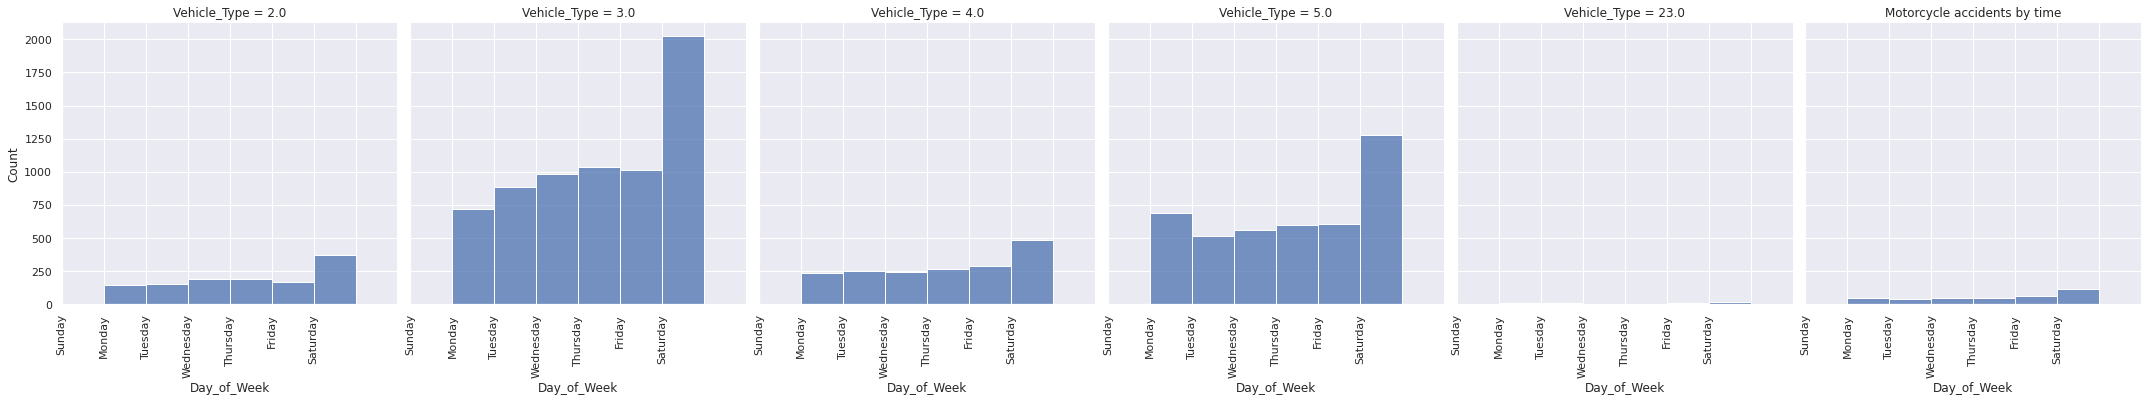

In [ ]:
#number of accidents by all motorbikes according to weekday
sns.set_theme()
plt.figure(figsize = (15,10))
x = sns.displot(bikes, x='Day_of_Week', binwidth=1, palette = 'viridis', col = 'Vehicle_Type')
x.set_xticklabels(day_labels, rotation =90)
plt.title('Motorcycle accidents by time')


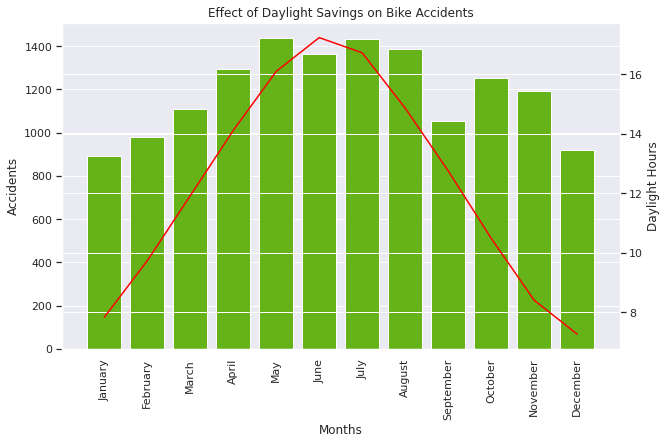

In [ ]:
daylight_chart(bikes, 'Effect of Daylight Savings on Bike Accidents', '#66CC00', 'Months', 'Accidents', 'Daylight Hours', 'Month_Label', 'converted_time_Day length')

<Figure size 1080x720 with 0 Axes>

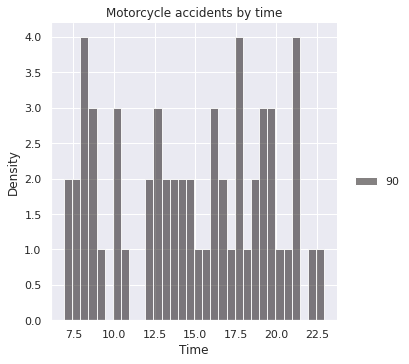

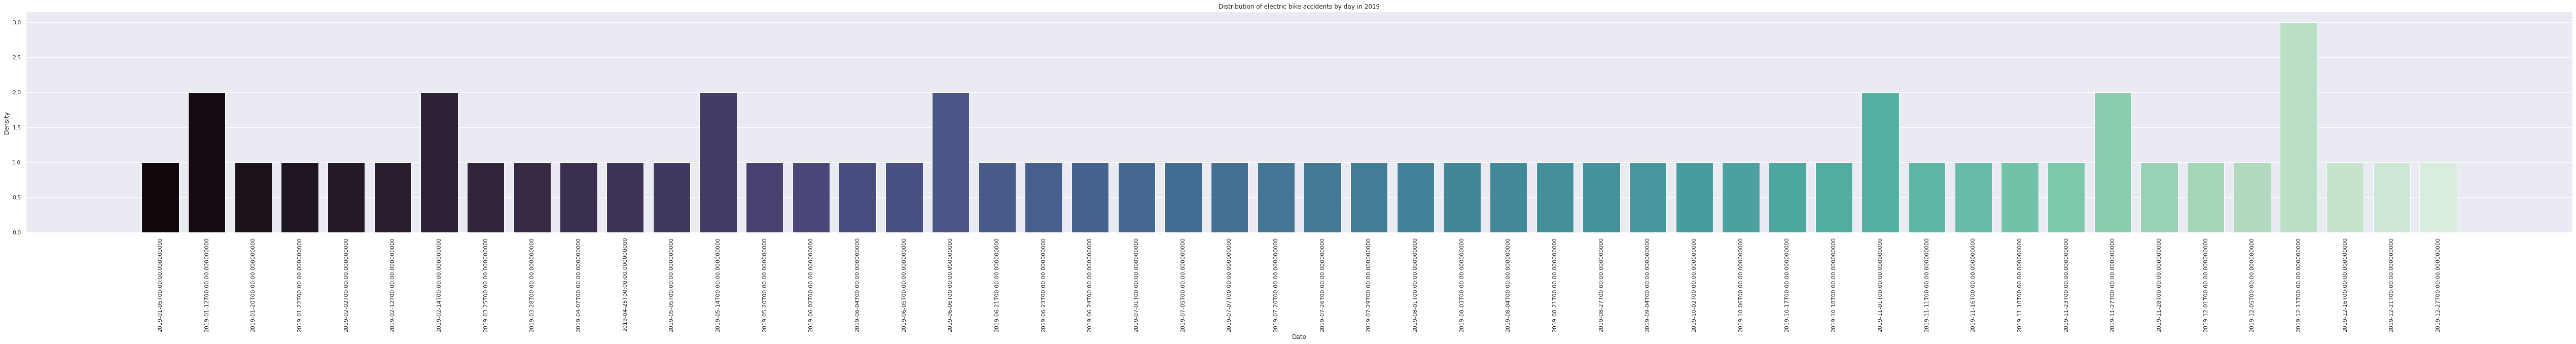

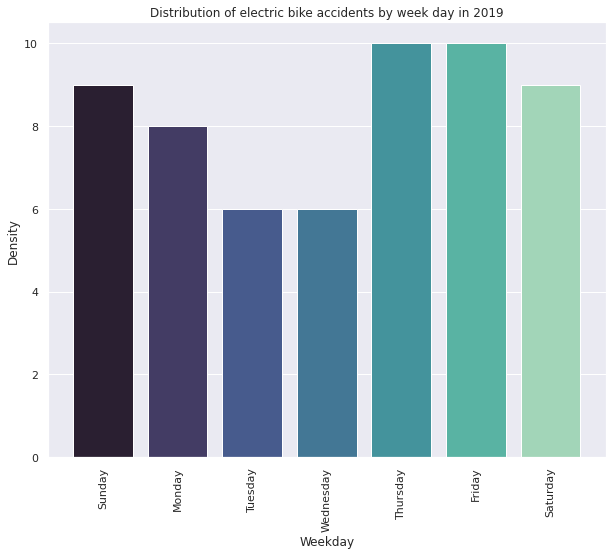

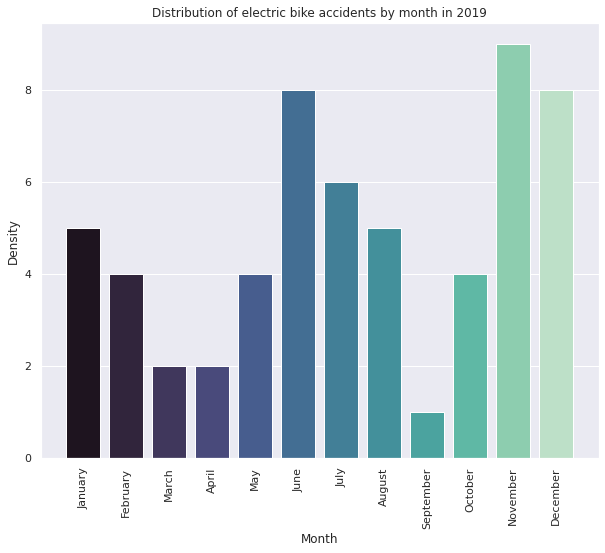

In [ ]:
bikes =  (v_acc[v_acc['Vehicle_Type']==23])

#number of accidents by different cc's of motorbikes according to time of day
displt(15, 10, bikes, 'converted_time', .5, 'mako', 'Motorcycle accidents by time', 'Time', 'Density',90,None, None)

#number of accidents by all motorbikes according to month
barplt(90,8, bikes.groupby(['Date']).size().reset_index(), 'Date', 0, 'mako', 'Distribution of electric bike accidents by day in 2019', 'Date', 'Density', 90, None, None)

#number of accidents by all motorbikes according to weekday
barplt(10,8, bikes.groupby(['Day_of_Week', 'Day_Label']).size().reset_index(), 'Day_Label', 0, 'mako', 'Distribution of electric bike accidents by week day in 2019', 'Weekday', 'Density', 90, None, None)

#number of accidents by all motorbikes according to month
barplt(10,8, bikes.groupby(['Month', 'Month_Label']).size().reset_index(), 'Month_Label', 0, 'mako', 'Distribution of electric bike accidents by month in 2019', 'Month', 'Density', 90, None, None)



###### Cycle accidents by time

<Figure size 1080x720 with 0 Axes>

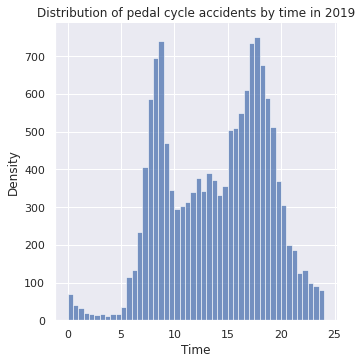

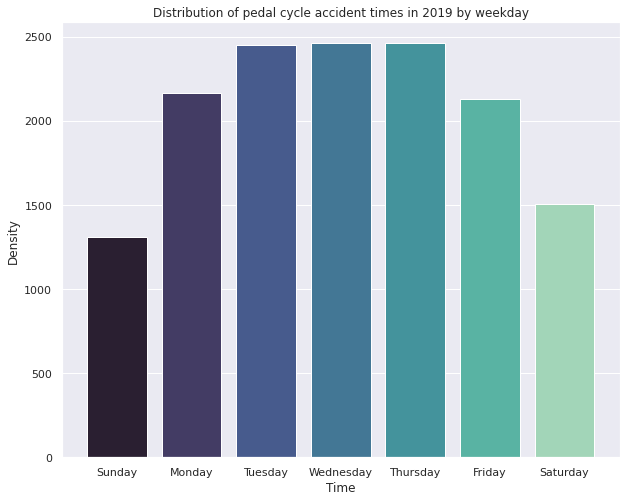

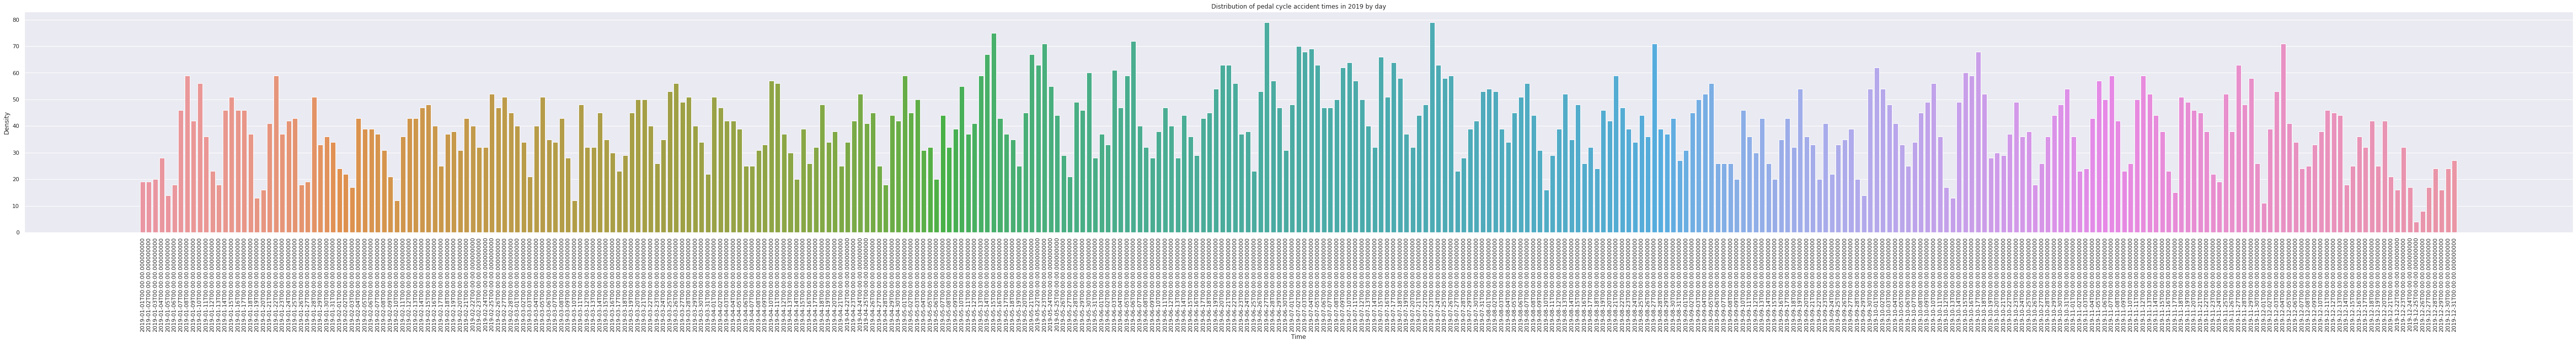

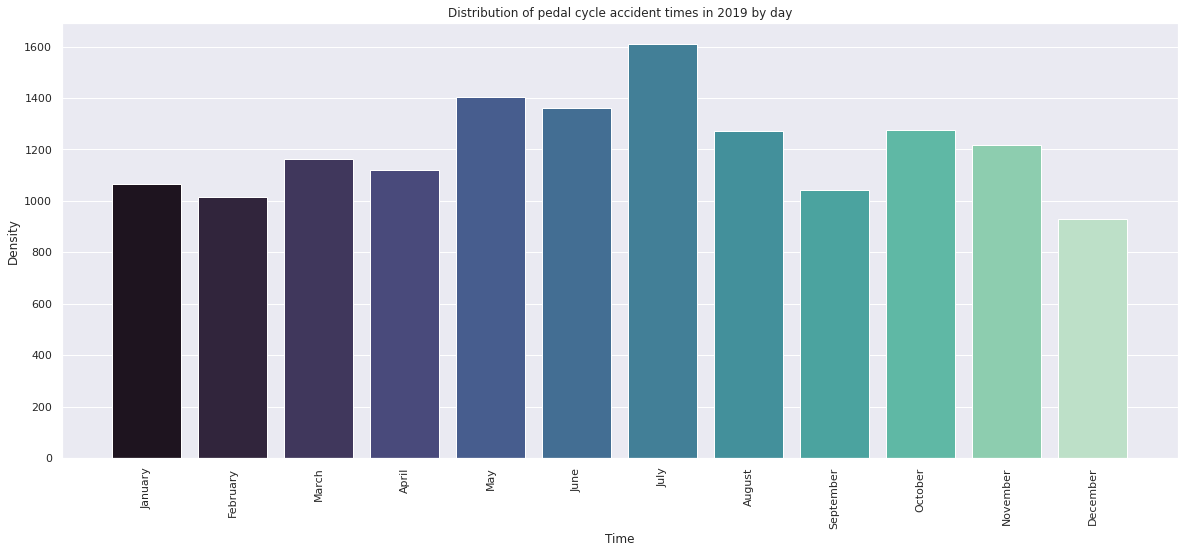

In [ ]:
displt(15, 10, v_acc[v_acc['Vehicle_Type']==1], 'converted_time', .5, 'mako', 'Distribution of pedal cycle accidents by time in 2019', 'Time', 'Density',None, None, None)
barplt(10,8, v_acc[v_acc['Vehicle_Type']==1].groupby(['Day_of_Week', 'Day_Label']).size().reset_index(), 'Day_Label', 0, 'mako', 'Distribution of pedal cycle accident times in 2019 by weekday', 'Time', 'Density', None, None, None)
barplt(90,8, v_acc[v_acc['Vehicle_Type']==1].groupby(['Date']).size().reset_index(), 'Date', 0, None, 'Distribution of pedal cycle accident times in 2019 by day', 'Time', 'Density', 90, 365, None)
barplt(20,8, v_acc[v_acc['Vehicle_Type']==1].groupby(['Month', 'Month_Label']).size().reset_index(), 'Month_Label', 0, 'mako', 'Distribution of pedal cycle accident times in 2019 by day', 'Time', 'Density', 90, 365, None)



<Figure size 1080x720 with 0 Axes>

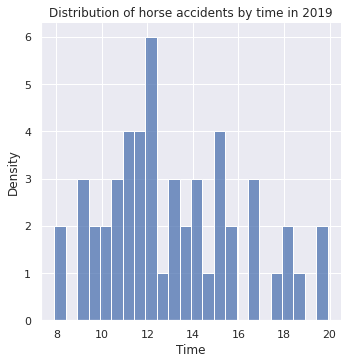

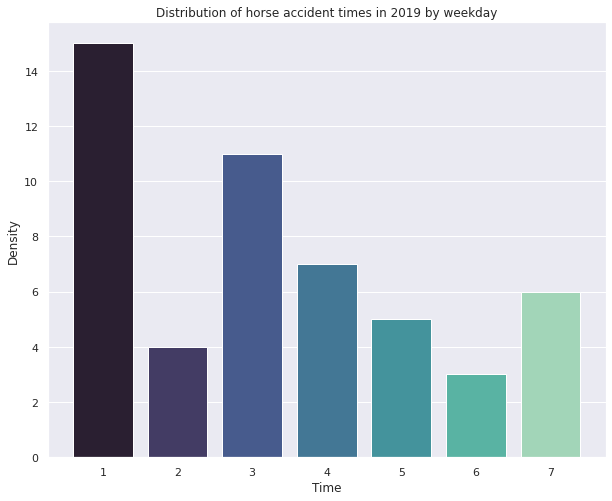

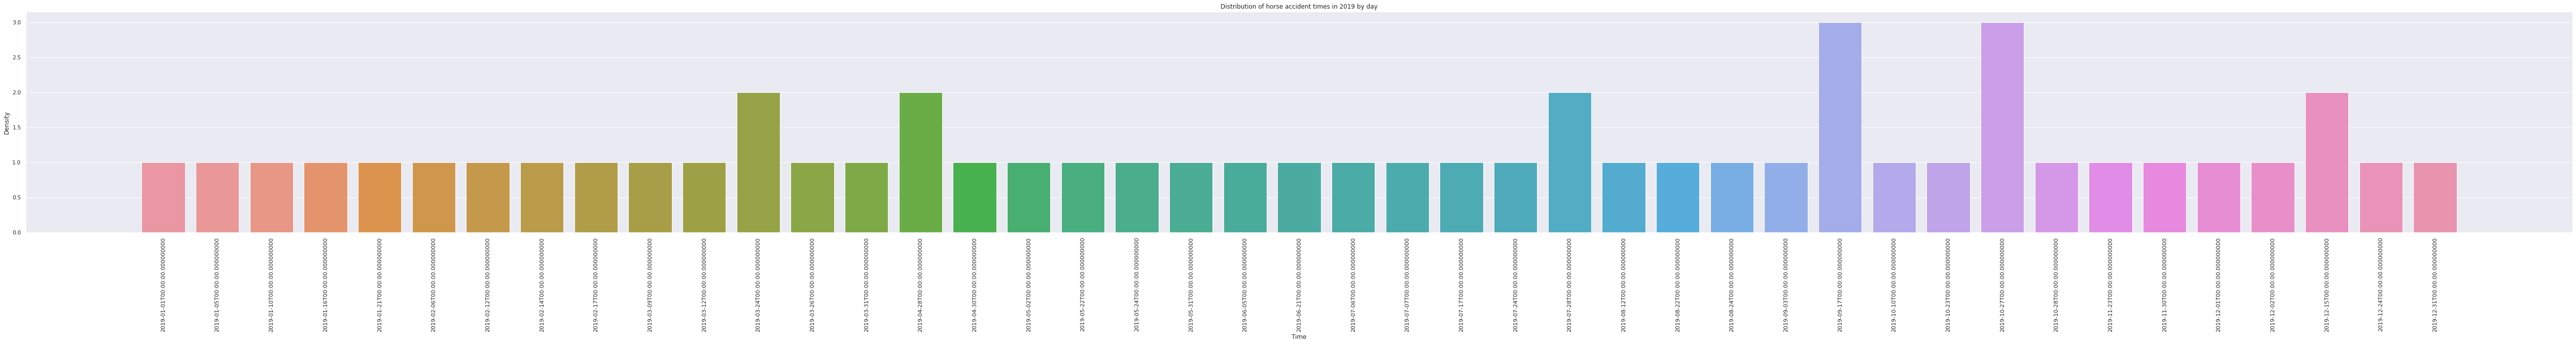

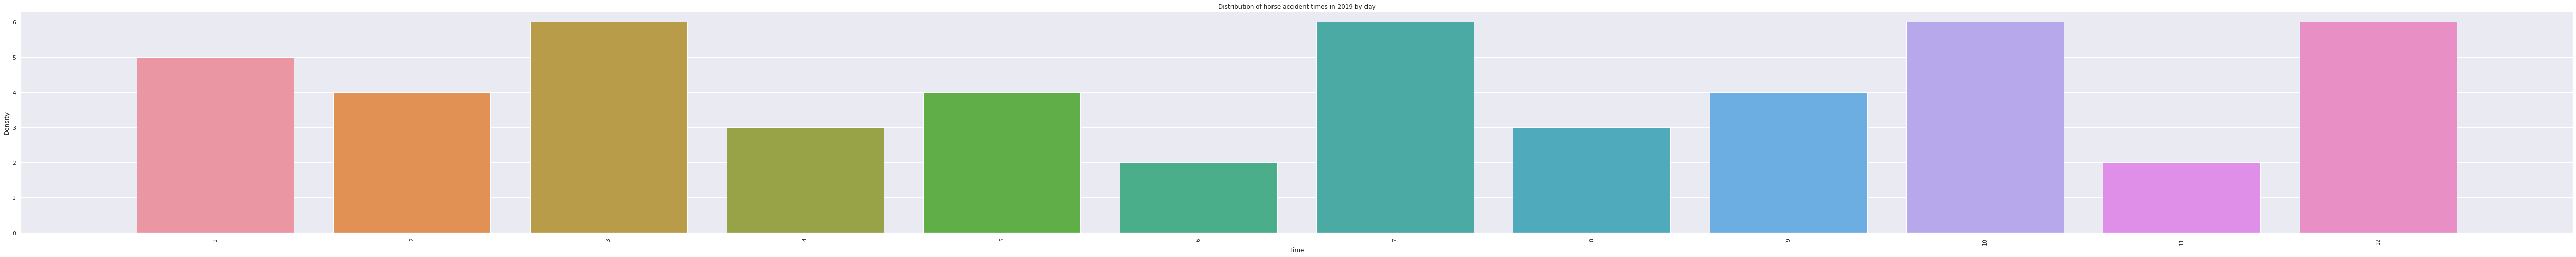

In [ ]:
displt(15, 10, v_acc[v_acc['Vehicle_Type']==16], 'converted_time', .5, 'mako', 'Distribution of horse accidents by time in 2019', 'Time', 'Density',None, None, None)
barplt(10,8, v_acc[v_acc['Vehicle_Type']==16].groupby(['Day_of_Week']).size().reset_index(), 'Day_of_Week', 0, 'mako', 'Distribution of horse accident times in 2019 by weekday', 'Time', 'Density', None, None, None)
barplt(90,8, v_acc[v_acc['Vehicle_Type']==16].groupby(['Date']).size().reset_index(), 'Date', 0, None, 'Distribution of horse accident times in 2019 by day', 'Time', 'Density', 90, 365, None)
barplt(90,8, v_acc[v_acc['Vehicle_Type']==16].groupby(['Month']).size().reset_index(), 'Month', 0, None, 'Distribution of horse accident times in 2019 by day', 'Time', 'Density', 90, 365, None)



##### Frequency of each casualty class in accidents

([<matplotlib.axis.XTick at 0x7fd3dbdd6510>,
 [Text(0, 0, 'Driver or Rider'),
  Text(0, 0, 'Passenger'),
  Text(0, 0, 'Pedestrian')])

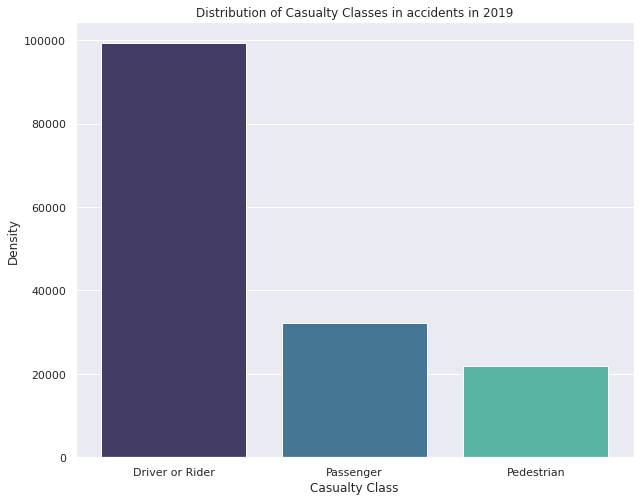

In [ ]:
subset = casualty.groupby(['Casualty_Class']).size().reset_index()
barplt(10,8, subset, 'Casualty_Class', 0, 'mako', 'Distribution of Casualty Classes in accidents in 2019', 'Casualty Class', 'Density', None, None, None)
locs, labels = plt.xticks()
plt.xticks(locs, ['Driver or Rider', 'Passenger', 'Pedestrian' ])


##### Pedestrian casualties by time

<Figure size 1080x720 with 0 Axes>

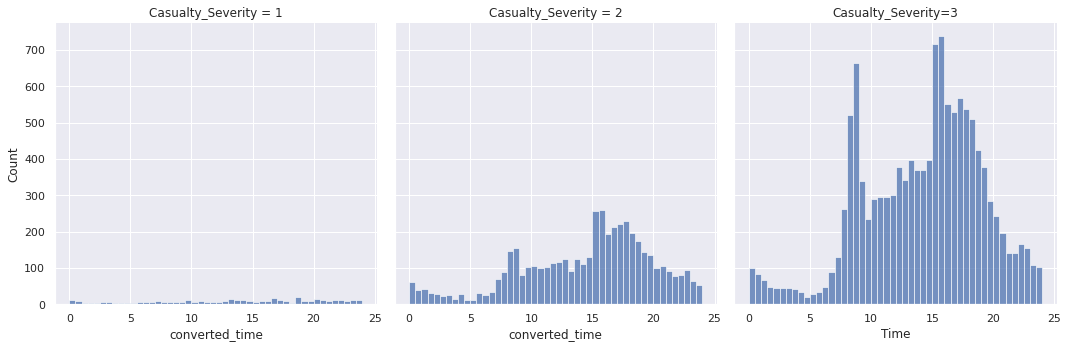

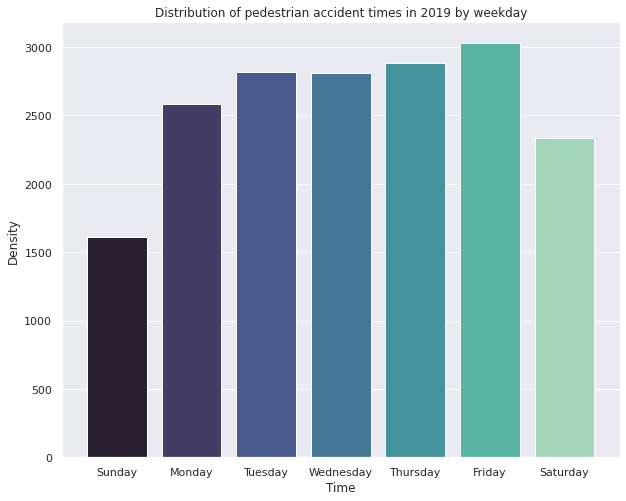

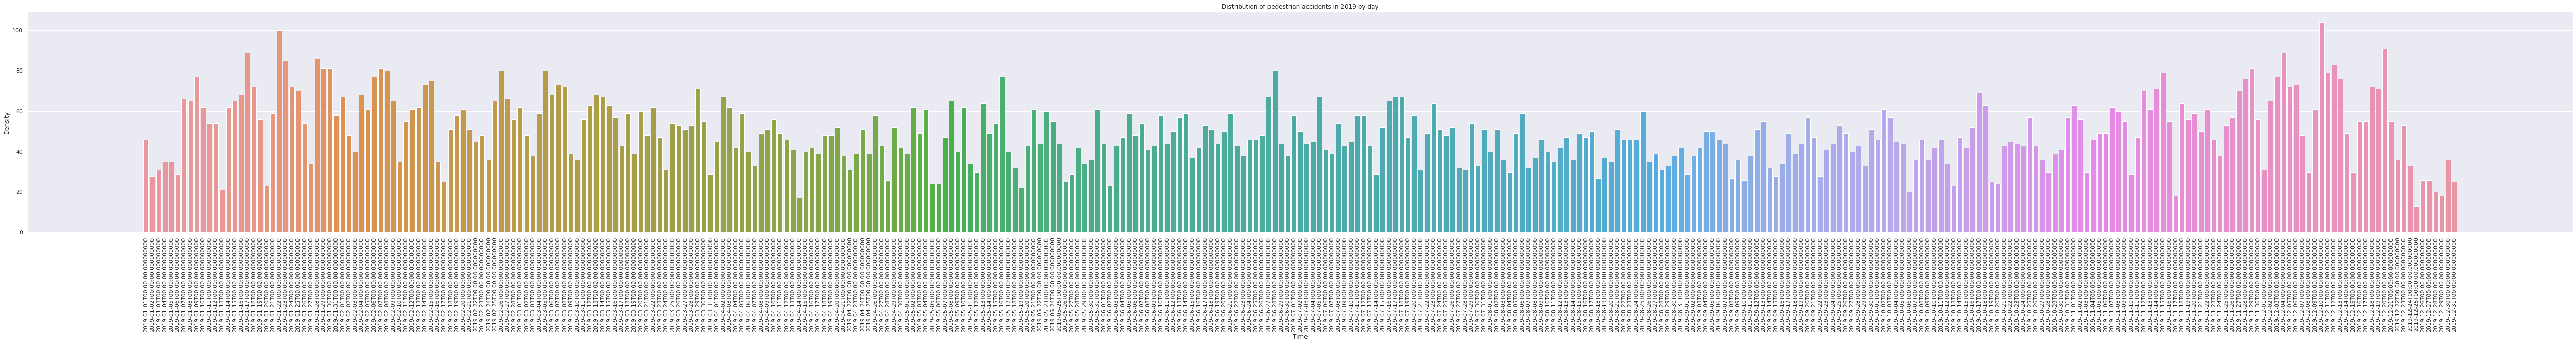

In [ ]:

displt(15, 10, c_acc[c_acc['Casualty_Class']==3], 'converted_time', .5, 'mako','Casualty_Severity=3', 'Time', 'Density',None, 'Casualty_Severity', None)
barplt(10,8, c_acc[c_acc['Casualty_Class']==3].groupby(['Day_of_Week', 'Day_Label']).size().reset_index(), 'Day_Label', 0, 'mako', 'Distribution of pedestrian accident times in 2019 by weekday', 'Time', 'Density', None, None, None)
barplt(90,8, c_acc[c_acc['Casualty_Class']==3].groupby(['Date']).size().reset_index(), 'Date', 0, None, 'Distribution of pedestrian accidents in 2019 by day', 'Time', 'Density', 90, 365, None)



In [ ]:
c_acc.columns

Index(['Accident_Index', 'Vehicle_Reference', 'Casualty_Reference',
       'Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty',
       'Age_Band_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location',
       'Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger',
       'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type',
       'Casualty_Home_Area_Type', 'Casualty_IMD_Decile', 'Month_Label',
       'Day_Label', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity',
       'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week',
       'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)',
       '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit',
       'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions',

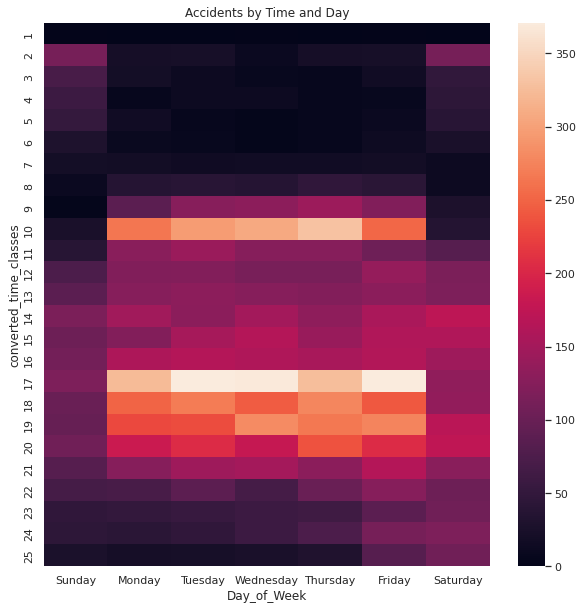

In [ ]:
subset = c_acc[c_acc['Casualty_Class']==3].groupby(['Day_of_Week', 'converted_time_classes']).size().reset_index()
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
plt.figure(figsize = (10,10))
plt.title('Accidents by Time and Day')
heatplot = sns.heatmap(subset.pivot(index='converted_time_classes', columns='Day_of_Week', values=0))
heatplot.set_xticklabels(days)

plt.show()

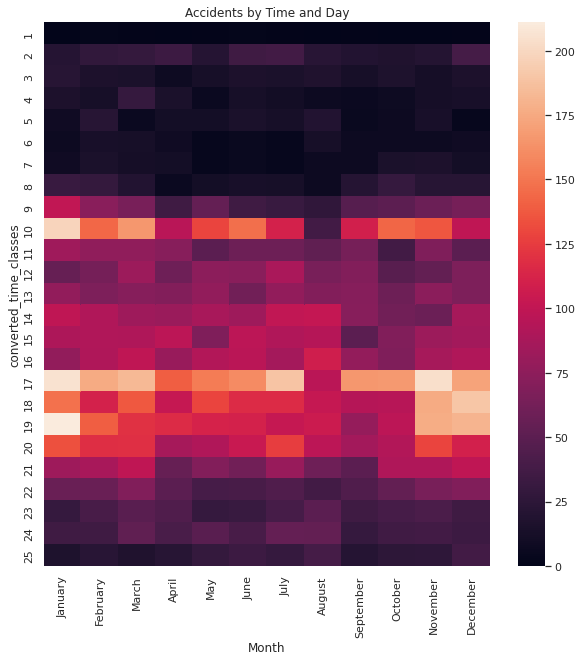

In [ ]:
subset = c_acc[c_acc['Casualty_Class']==3].groupby(['Month', 'converted_time_classes']).size().reset_index()
plt.figure(figsize = (10,10))
plt.title('Accidents by Time and Day')
heatplot = sns.heatmap(subset.pivot(index='converted_time_classes', columns='Month', values=0))
heatplot.set_xticklabels(month_labels, rotation=90)

plt.show()

##### The effect of daylight savings

Daylight savings started on the **31st of March at 1am** and ended on the **27th of October at 2am** in 2019

In [ ]:
print('There were',len(week_extractor(c_acc, '2019-3-31', 13, 'Date', 'converted_time_classes').groupby(['Accident_Index'])), 'accidents and', len(week_extractor(c_acc, '2019-3-31', 13, 'Date', 'converted_time_classes')), 'casualties in the week after daylight savings began.')
print('There were',len(week_extractor(c_acc, '2019-10-27', 14, 'Date', 'converted_time_classes').groupby(['Accident_Index'])), 'accidents and', len(week_extractor(c_acc, '2019-10-27', 14, 'Date', 'converted_time_classes')), 'casualties in the week after daylight savings ended.')

There were 1956 accidents and 2531 casualties in the week after daylight savings began.
There were 1653 accidents and 2243 casualties in the week after daylight savings ended.


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


This function returns a list of dates (the first day in each week). It is useful for **extracting the same date range of a week, from every single month**, after taking into account that *not all months have the same number of days.*

In [ ]:
#This returns a list of weeks
df_parts = []
for d in week_extractor_every_month('2019-1-27'):
  df_parts.append(week_extractor(vac_merged,d, 13, 'Date', 'converted_time'))

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#Returns a list of weeks in the same time period as the week after saylight times started/ended

df_daylight_start = df_parts[0]
df_daylight_start['Week_Number'] = (week_extractor_every_month('2019-1-27'))[0]
for i in range(1,len(df_parts)):
  temp  = df_parts[i]
  temp['Week_Number'] = (week_extractor_every_month('2019-1-27'))[i]
  df_daylight_start = pd.concat([df_daylight_start, temp])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(array([737119., 737180., 737241., 737303., 737364., 737425.]),
 <a list of 6 Text major ticklabel objects>)

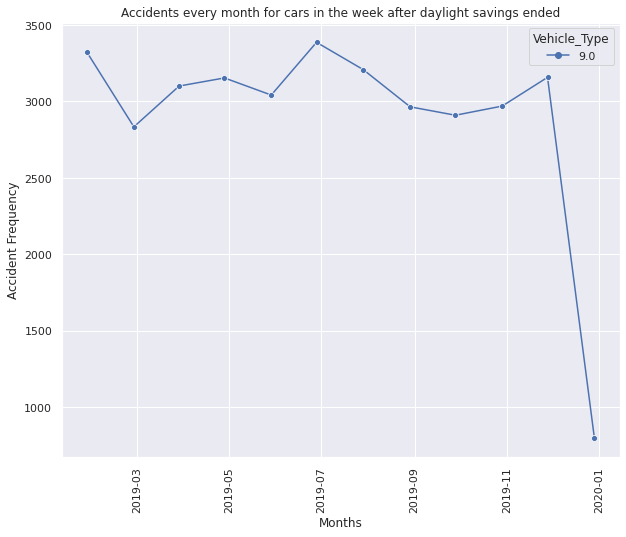

In [ ]:
colours = ['pastel', 'Paired', 'flare']
vehicle_num =  [9,1, 19]
cars = df_daylight_start[(df_daylight_start['Vehicle_Type']==9)]
cars = cars.groupby(['Vehicle_Type', 'Week_Number']).size().reset_index()
#barplt(10,8, df_daylight_start[df_daylight_start['Vehicle_Type']==vehicle_num[i]].groupby(['Week_Number']).size().reset_index(), 'Week_Number', 0,colours[i], 'Distribution of accidents in the week after daylight savings starts, in every month', 'Time', 'Density', 90, None,'Casualty_Severity')

lineplt(cars, 'Week_Number', 'Vehicle_Type', 0, 10, 8, 'Accidents every month for cars in the week after daylight savings ended', 'Months', 'Accident Frequency', True)
plt.xticks(rotation=90)




##### Sunrise and Sunset Times

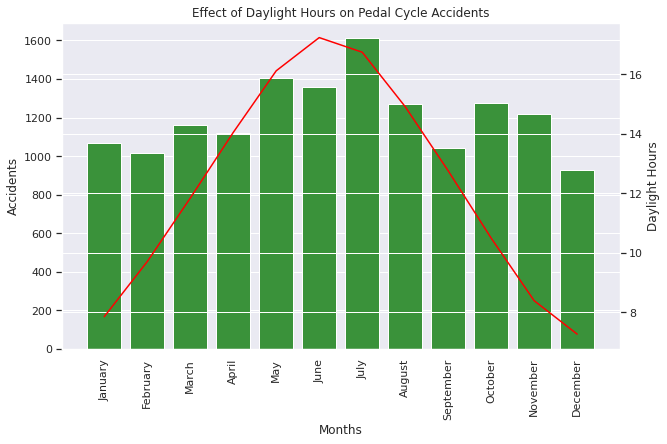

In [ ]:
#for pedal cycles
daylight_chart(v_acc[v_acc['Vehicle_Type']==1], 'Effect of Daylight Hours on Pedal Cycle Accidents', 'tab:green', 'Months', 'Accidents', 'Daylight Hours', 'Month_Label', 'converted_time_Day length')

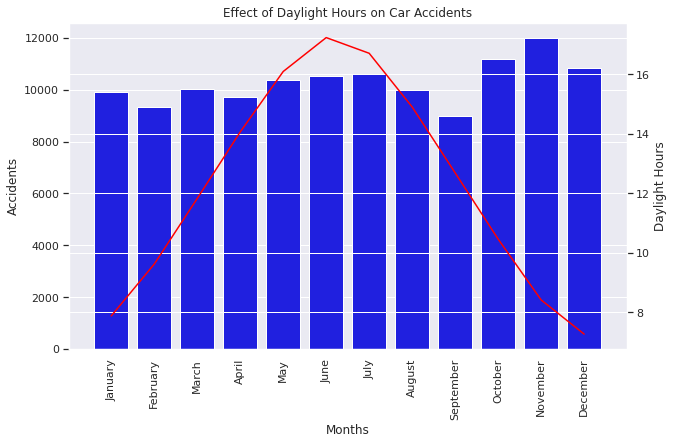

In [ ]:
#for cars
daylight_chart(v_acc[v_acc['Vehicle_Type']==9], 'Effect of Daylight Hours on Car Accidents', 'blue', 'Months', 'Accidents', 'Daylight Hours', 'Month_Label', 'converted_time_Day length')

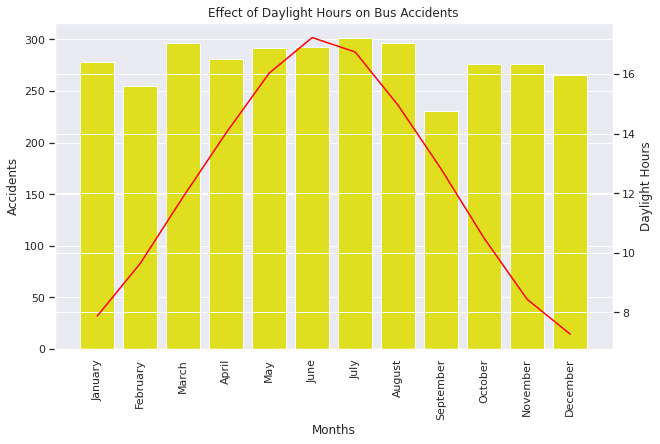

In [ ]:
#for buses
daylight_chart(v_acc[v_acc['Vehicle_Type']==11], 'Effect of Daylight Hours on Bus Accidents', 'yellow', 'Months', 'Accidents', 'Daylight Hours', 'Month_Label', 'converted_time_Day length')

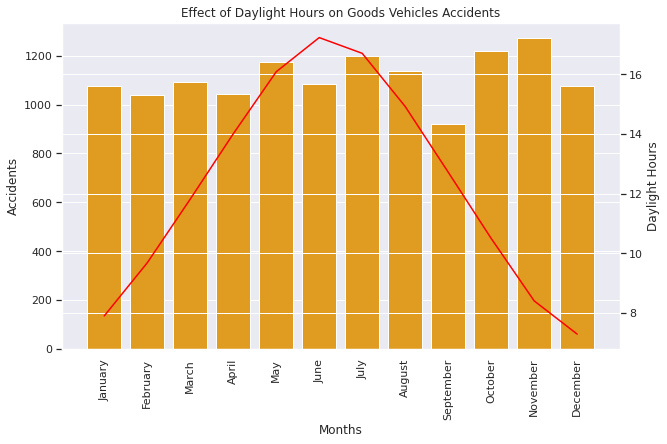

In [ ]:
#for goods vehicles
goods = v_acc[(v_acc['Vehicle_Type']==19) | (v_acc['Vehicle_Type']==20) | (v_acc['Vehicle_Type']==21)]
daylight_chart(goods, 'Effect of Daylight Hours on Goods Vehicles Accidents', 'orange', 'Months', 'Accidents', 'Daylight Hours', 'Month_Label', 'converted_time_Day length')

## Feature Analysis

##### Geographic Clustering

In [ ]:
subset = accident[['Longitude', 'Latitude']]

This function plots the cluster map of accidents

In [ ]:
def plot_map(labels):
  fig = plt.figure(figsize = (10,10))
  colors = map(lambda x: colmap[x+1], labels)
  plt.scatter(subset['Longitude'], subset['Latitude'], color = 'blue', s=1)
  plt.xlim(-10,5)
  plt.ylim(48,62)
  plt.scatter(centroids[:,0], centroids[:,1], color = 'orange')
  plt.show()

This function implements kmeans

In [ ]:
def accident_kmeans(data):
  Sum_of_squared_distances = []
  clusters = range(1,40)
  for c in clusters:
    kmeans = KMeans(n_clusters = c)
    kmeans.fit(data)
    Sum_of_squared_distances.append(kmeans.inertia_)

  plt.plot(clusters, Sum_of_squared_distances, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Sum_of_squared_distances')
  plt.title('Elbow Method For Optimal k')
  plt.show()

In [ ]:
subset = accident[['Longitude', 'Latitude']]

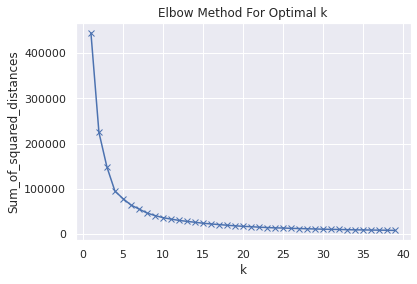

In [ ]:
accident_kmeans(subset)

###### drawing the cluster map

The inertia is 46416.38960451997 for 8 centroids


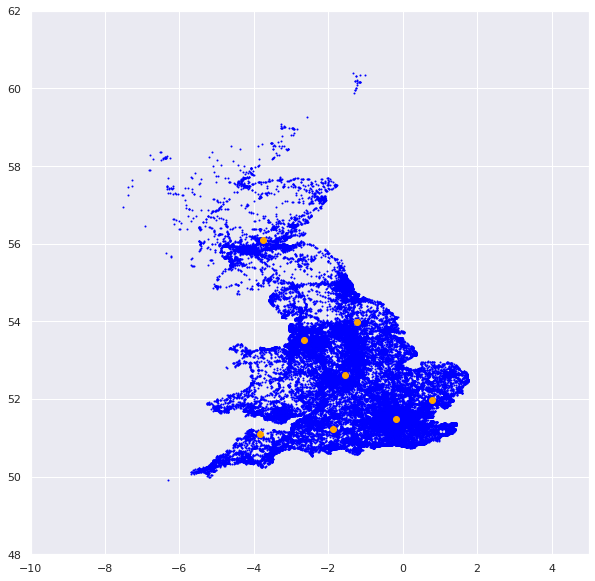

In [ ]:
kmeans = KMeans(n_clusters =8)
kmeans.fit(subset)
labels = kmeans.predict(subset)
centroids = kmeans.cluster_centers_
print('The inertia is', kmeans.inertia_, 'for 8 centroids')
plot_map(labels)

In [ ]:
#making a dataframe of centroid coordinates

centroids = pd.DataFrame(kmeans.cluster_centers_.ravel())
centroids
lat = []
long = []
for c in centroids[0]:
  if c>50:
    lat.append(c)
  else:
    long.append(c)

locations = pd.DataFrame(list(zip(lat,long)))


In [ ]:
locations

0         1
0  53.518204 -2.663804
1  51.486549 -0.179681
2  51.104317 -3.823197
3  56.101396 -3.764280
4  52.612250 -1.564291
5  51.985573  0.783318
6  51.239423 -1.867621
7  53.986365 -1.235533

In [ ]:
# this library finds locations from coordinates

from geopy.geocoders import Nominatim
geolocator = Nominatim()
for i in range(len(locations)):

  l = geolocator.reverse((locations.iloc[i,0]).astype(str)+',' +(locations.iloc[i,1]).astype(str))
  print(l.address)
  print('\n')



/usr/local/lib/python3.7/dist-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


Bembridge Court, Marus Bridge, Wigan, Greater Manchester, England, WN3 6JX, United Kingdom


2, Callow Street, The Boltons, World's End, London, Royal Borough of Kensington and Chelsea, Greater London, England, SW3 6BG, United Kingdom


North Molton, North Devon, Devon, South West England, England, EX36 3EU, United Kingdom


Clackmannan, Clackmannanshire, Alba / Scotland, FK10 4JZ, United Kingdom


Atherstone Solar Farm Substation, Grendon Road, Grendon CP, North Warwickshire, Warwickshire, West Midlands, England, CV9 3DU, United Kingdom


Bures Green, Bures St. Mary, Bures, Babergh, Suffolk, East of England, England, CO8 5JY, United Kingdom


Enford, Wiltshire, South West England, England, United Kingdom


A59, Wilstrop, Harrogate, North Yorkshire, Yorkshire and the Humber, England, YO26 8EZ, United Kingdom




In [ ]:
cat_selector = mcs(dtype_include=object)
num_selector = mcs(dtype_include=np.number)

scaler = make_pipeline(StandardScaler())

#for feature selection, it's more practical to use ordinal encoder
ordinal_encoder = make_pipeline(OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999))

#I one hot encoded after selecting features
one_hot_encoder = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

scaled_num_features = make_column_transformer((scaler, num_selector))
encoded_cat_features = make_column_transformer((encoder, cat_selector))





In [ ]:
'''
since this transformer is applied to the final dataframe (after feature selection) it uses one hot encoding and label encoding
I specify the columns that will be one hot encoded and those that will be ordinally encoded
'''

def preprocess_final(one_hot_features, ordinal_features):
  all_features = make_column_transformer((scaler, num_selector), (one_hot_encoder, one_hot_features ), (encoder, ordinal_features ))
  return all_features

This function makes rules between the features

##### rule making function

In [ ]:
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

def make_rules (df, ms, mt):
  frequent_itemsets = apriori(df, min_support=ms, use_colnames=True)
  rules = association_rules(frequent_itemsets, metric='lift', min_threshold = mt)
  return rules

##### function for selecting columns

In [ ]:
def select_cols(df, col_list):
  subset = df[col_list]
  print(col_list)
  for col in subset.columns:
    subset = pd.concat([subset, pd.get_dummies(subset[col], prefix=col)], axis=1, ignore_index=False)
    final_subset = subset.drop(col_list, axis=1)
  return subset, final_subset

In [ ]:
#selecting the input features
clist =  ['Speed_limit', 'Accident_Severity', 'Road_Type', 'Police_Force', '1st_Road_Class', '2nd_Road_Class', 'Day_of_Week', 'Weather_Conditions', 'Light_Conditions']
sub, fsub = select_cols(accident, clist)

['Speed_limit', 'Accident_Severity', 'Road_Type', 'Police_Force', '1st_Road_Class', '2nd_Road_Class', 'Day_of_Week', 'Weather_Conditions', 'Light_Conditions']


In [ ]:
#making the rules
rule_index = make_rules(fsub, 0.3, 0.2)

In [ ]:
#rule_index[rule_index['itemsets'] == {'Accident_Severity'} ]
for i in range(len(rule_index)):
  if (rule_index.iloc[i,1].issuperset({'Accident_Severity_1'})) | (rule_index.iloc[i,1].issuperset({'Accident_Severity_2'}))| (rule_index.iloc[i,1].issuperset({'Accident_Severity_3'})):
    print(tabulate(pd.DataFrame(rule_index.iloc[i,:]), headers='keys', tablefmt='psql'))

+--------------------+------------------------------------+
|                    | 1                                  |
|--------------------+------------------------------------|
| antecedents        | frozenset({'Speed_limit_30.0'})    |
| consequents        | frozenset({'Accident_Severity_3'}) |
| antecedent support | 0.5901851347672202                 |
| consequent support | 0.7866185679281241                 |
| support            | 0.4749608630547237                 |
| confidence         | 0.8047658862876255                 |
| lift               | 1.0230700355920908                 |
| leverage           | 0.01071027753166598                |
| conviction         | 1.0929515749805723                 |
+--------------------+------------------------------------+
+--------------------+------------------------------------+
|                    | 9                                  |
|--------------------+------------------------------------|
| antecedents        | frozenset({'Road_

##### Speed Limit and Accident Severity

In [ ]:
#making labels for speed limit
codes = [1,2,3]
acc_sev = ['fatal', 'serious', 'slight']
acc_labels = pd.DataFrame(list(zip(codes,acc_sev)), columns = ['code', 'severity'])

In [ ]:
subset = accident.groupby(['Speed_limit', 'Accident_Severity']).size().reset_index()
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

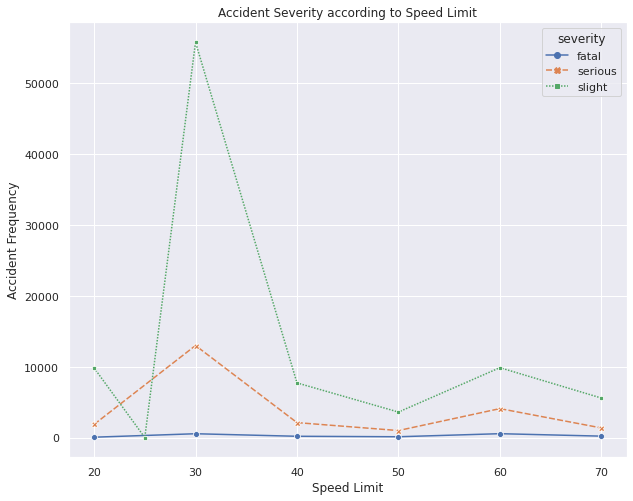

In [ ]:
lineplt(subset, 'Speed_limit', 'severity', 0, 10, 8, 'Accident Severity according to Speed Limit', 'Speed Limit',
        'Accident Frequency', True)


In [ ]:
#making labels for weekdays
day_codes = [1,2,3,4,5,6,7]
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_labels = pd.DataFrame(list(zip(codes,days)), columns = ['code', 'day'])


##### Light and Day of Week

In [ ]:
#making labels for light conditions
light_codes = [1,4,5,6,7]
lights = ['daylight', 'darkness-light lit', 'darkness - light unlit', 'darkness - no lighting', 'darkness - light unknown']
light_labels = pd.DataFrame(list(zip(light_codes,lights)), columns = ['light_code', 'light_label'])

In [ ]:
subset = accident.groupby(['Light_Conditions', 'Day_of_Week']).size().reset_index()
subset=subset.merge(light_labels, how = 'inner', left_on= 'Light_Conditions', right_on='light_code')
subset=subset.merge(day_labels, how = 'inner', left_on= 'Day_of_Week', right_on='code')

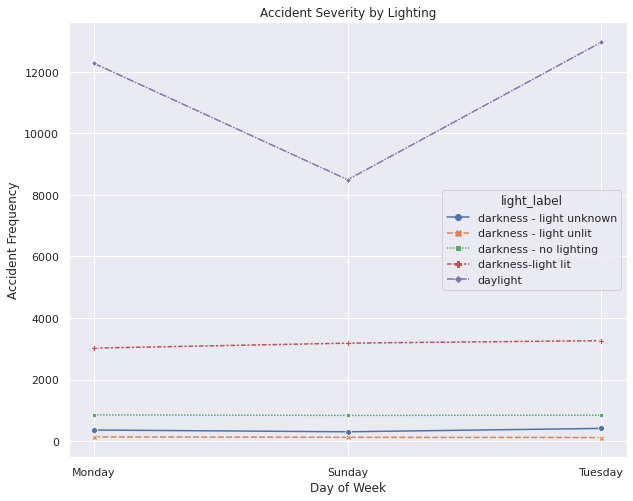

In [ ]:
lineplt(subset, 'day', 'light_label', 0, 10, 8, 'Accident Severity by Lighting', 'Day of Week', 'Accident Frequency', True)

##### Weather and Day of Week

In [ ]:
#making labels for weather conditions

codes = [1,2,3,4,5,6,7,8,9]
weather = ['fine, no high winds', 'rain, no high winds','snow, no high winds', 
       'fine, high winds', 'rain, high winds', 'snow, high winds', 'fog or mist', 'other', 'unknown']
weather_labels = pd.DataFrame(list(zip(codes,weather)), columns = ['code', 'weather_label'])

In [ ]:
subset = accident.groupby(['Weather_Conditions', 'Day_of_Week']).size().reset_index()
subset=subset.merge(weather_labels, how = 'inner', left_on= 'Weather_Conditions', right_on='code')
subset=subset.merge(day_labels, how = 'inner', left_on= 'Day_of_Week', right_on='code')

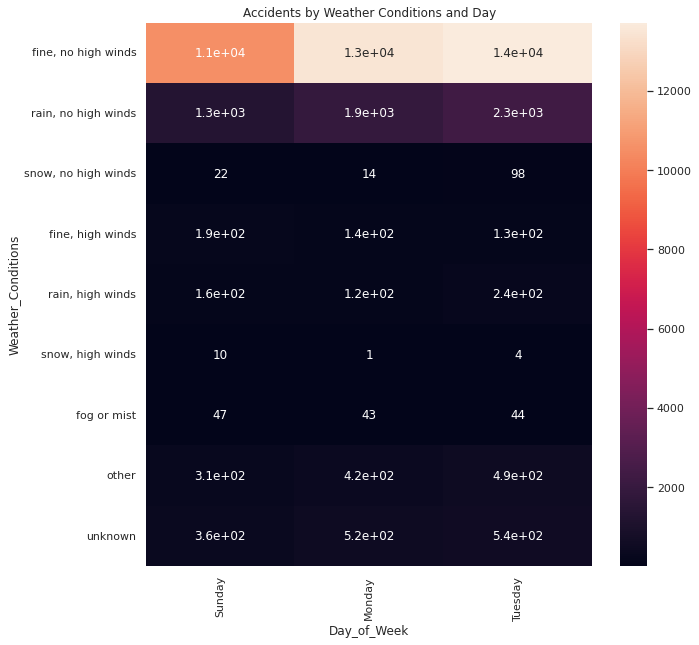

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Accidents by Weather Conditions and Day')
heatplot = sns.heatmap(subset.pivot(index='Weather_Conditions', columns='Day_of_Week', values=0,), annot=True)
heatplot.set_xticklabels(days, rotation=90)
heatplot.set_yticklabels(weather, rotation= 360)

plt.show()

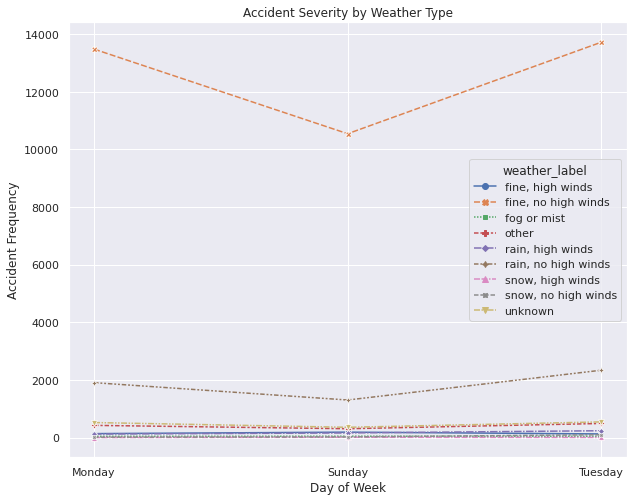

In [ ]:
lineplt(subset, 'day', 'weather_label', 0, 10, 8, 'Accident Severity by Weather Type', 'Day of Week', 'Accident Frequency', True)


##### Weather Conditions and Light Conditions

In [ ]:
subset = accident.groupby(['Weather_Conditions', 'Light_Conditions']).size().reset_index()
subset=subset.merge(weather_labels, how = 'inner', left_on= 'Weather_Conditions', right_on='code')
#subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

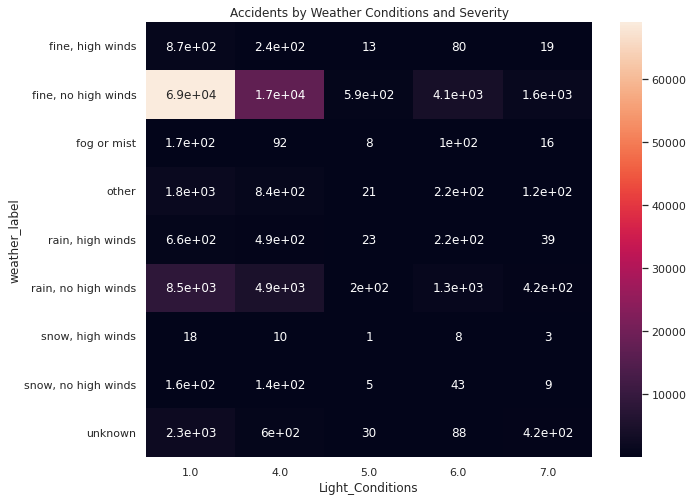

In [ ]:
plt.figure(figsize = (10,8))
plt.title('Accidents by Weather Conditions and Severity')
heatplot = sns.heatmap(subset.pivot(index='weather_label', columns='Light_Conditions', values=0), annot=True)
plt.show()

##### Weather Conditions and Severity

In [ ]:
subset = accident.groupby(['Weather_Conditions', 'Accident_Severity']).size().reset_index()
subset=subset.merge(weather_labels, how = 'inner', left_on= 'Weather_Conditions', right_on='code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

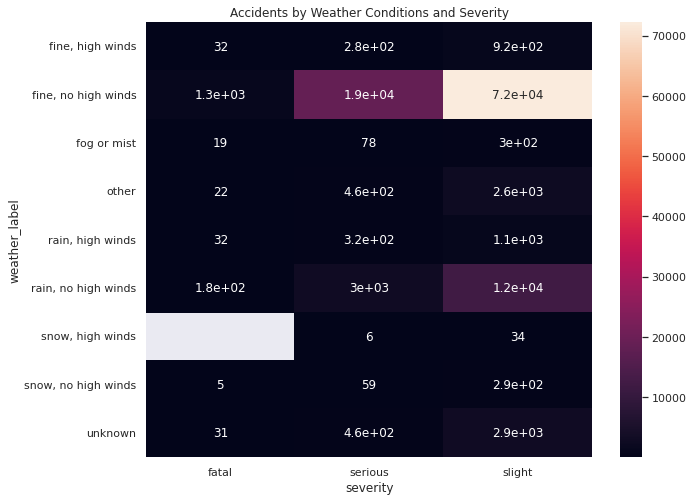

In [ ]:
plt.figure(figsize = (10,8))
plt.title('Accidents by Weather Conditions and Severity')
heatplot = sns.heatmap(subset.pivot(index='weather_label', columns='severity', values=0), annot=True)
plt.show()

##### Road conditions and weather conditions

In [ ]:
#making labels for road conditions

codes = [1,2,3,4,5,6,7]
road_surface = ['dry', 'wet or damp', 'snow', 'frost or ice', 'snow over 3cm deep', 'oil or diesel', 'mud' ]
road_surface_labels = pd.DataFrame(list(zip(codes,road_surface)), columns = ['code', 'road_surface'])


In [ ]:
subset = accident.groupby(['Road_Surface_Conditions', 'Weather_Conditions']).size().reset_index()
subset=subset.merge(weather_labels, how = 'inner', left_on= 'Weather_Conditions', right_on='code')
subset=subset.merge(road_surface_labels, how = 'inner', left_on= 'Road_Surface_Conditions', right_on='code')


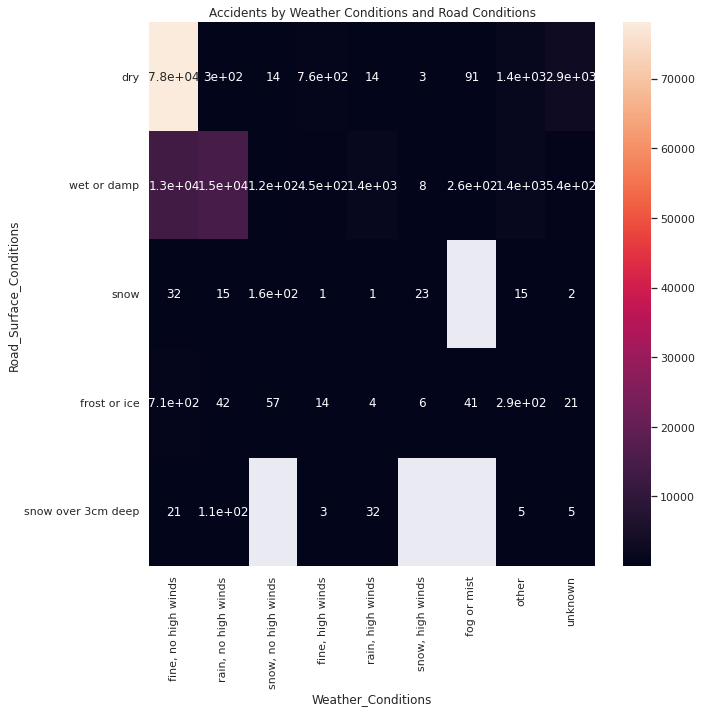

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Accidents by Weather Conditions and Road Conditions')
heatplot = sns.heatmap(subset.pivot(index='Road_Surface_Conditions', columns='Weather_Conditions', values=0), annot=True)
heatplot.set_xticklabels(weather, rotation=90)
heatplot.set_yticklabels(road_surface, rotation= 360)

plt.show()

##### Road Surface Conditions and Day of Week

In [ ]:
subset = accident.groupby(['Road_Surface_Conditions', 'Day_of_Week']).size().reset_index()
subset=subset.merge(road_surface_labels, how = 'inner', left_on= 'Road_Surface_Conditions', right_on='code')
subset=subset.merge(day_labels, how = 'inner', left_on= 'Day_of_Week', right_on='code')

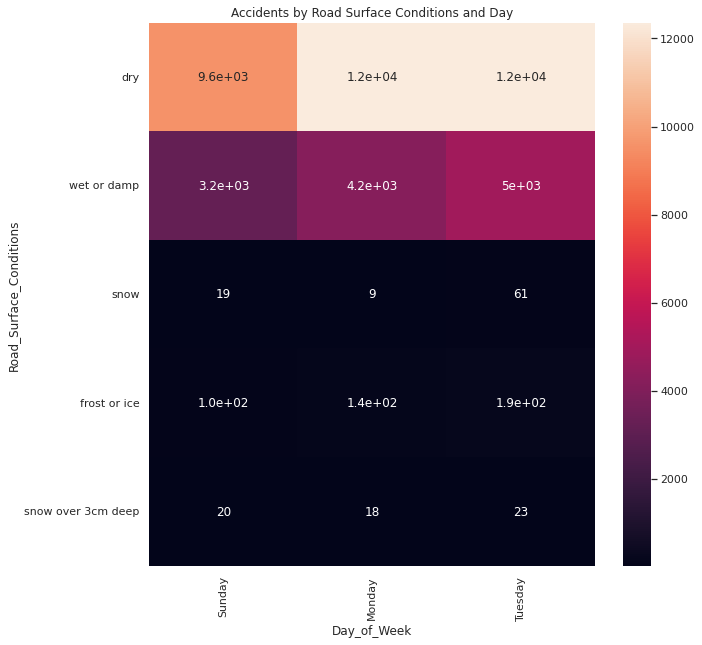

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Accidents by Road Surface Conditions and Day')
heatplot = sns.heatmap(subset.pivot(index='Road_Surface_Conditions', columns='Day_of_Week', values=0), annot=True)
heatplot.set_xticklabels(days, rotation=90)
heatplot.set_yticklabels(road_surface, rotation= 360)

plt.show()

##### Road Surface Conditions and Severity

In [ ]:
subset = accident.groupby(['Road_Surface_Conditions', 'Accident_Severity']).size().reset_index()
subset=subset.merge(road_surface_labels, how = 'inner', left_on= 'Road_Surface_Conditions', right_on='code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

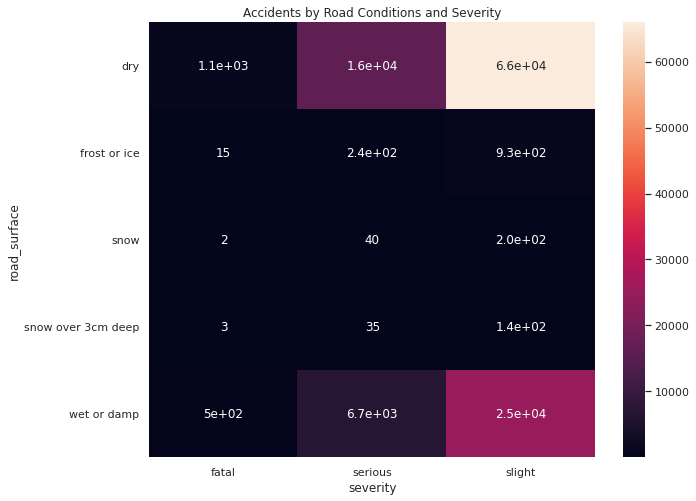

In [ ]:
plt.figure(figsize = (10,8))
plt.title('Accidents by Road Conditions and Severity')
heatplot = sns.heatmap(subset.pivot(index='road_surface', columns='severity', values=0), annot=True)
plt.show()

##### Junction Location and Accident Severity

In [ ]:
#making labels for junction conditions

jdetail = ['not at junction or within 20 meters', 'roundabout', 'mini roundabout', 't or staggered', 'slip road', 'crossroads',
           'more than 4 arms', 'private drive or entrance', 'other junction']
jcodes = [0,1,2,3,5,6,7,8,9]
junction_labels = pd.DataFrame(list(zip(jcodes,jdetail)), columns = ['code', 'junction'])


In [ ]:
subset = accident.groupby(['Junction_Detail', 'Accident_Severity']).size().reset_index()
#subset=subset.merge(weather_labels, how = 'inner', left_on= 'Weather_Conditions', right_on='code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')
subset=subset.merge(junction_labels, how = 'inner', left_on= 'Junction_Detail', right_on='code')


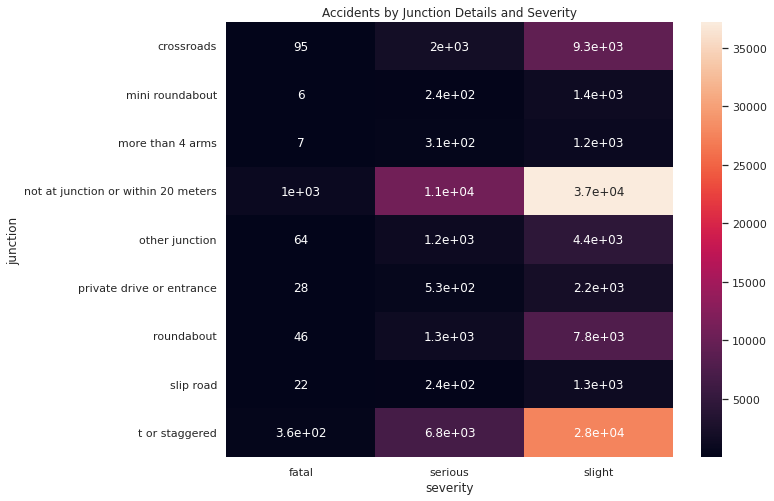

In [ ]:
plt.figure(figsize = (10,8))
plt.title('Accidents by Junction Details and Severity')
heatplot = sns.heatmap(subset.pivot(index='junction', columns='severity', values=0), annot=True)
plt.show()

##### Pedestrian Crossing and Accident Severity

In [ ]:
subset=accident.groupby(['Pedestrian_Crossing-Physical_Facilities', 'Accident_Severity']).size().reset_index()


In [ ]:
ped = ['no physical crossing within 50 meters', 'zebra', 'pelican,puffin,toucan etc.', 'pedestrian phase at traffic signal junction',
       'footbridge or subway', 'central refuge']
ped_codes = [0,1,4,5,7,8]
ped_df = pd.DataFrame(list(zip(ped_codes, ped)), columns = ['ped_code', 'ped_label'])
subset['Pedestrian_Crossing-Physical_Facilities'] = subset['Pedestrian_Crossing-Physical_Facilities'].astype(float)
subset= subset.merge(ped_df, how='inner', left_on='Pedestrian_Crossing-Physical_Facilities', right_on='ped_code')

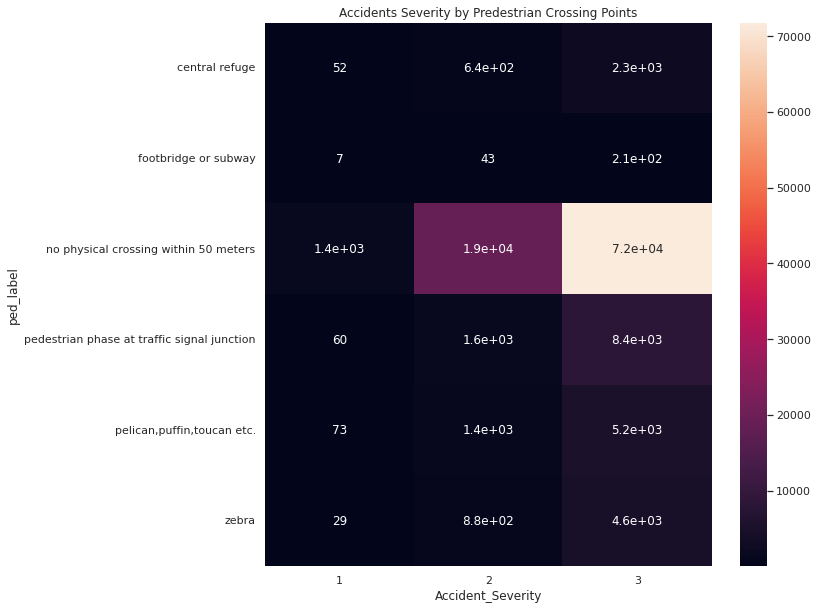

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Accidents Severity by Predestrian Crossing Points')
heatplot = sns.heatmap(subset.pivot(index='ped_label', columns='Accident_Severity', values=0), annot=True)


plt.show()

#### Vehicles

##### Journey Purpose of Driver and Day of Week

In [ ]:
journey_codes = [1,2,3,4,5,6, 15]
journey = ['Journey as Part of Work', 'Commuting to/from work', 'Taking Student to/from School', 
          'Pupil Riding to/from school', 'Other', 'Not known', 'Other from before']
journey_labels = pd.DataFrame(list(zip(journey_codes,journey)), columns = ['journey_code', 'journey_label'])

In [ ]:
subset = v_acc[v_acc['Journey_Purpose_of_Driver']!=6]
subset = subset.groupby(['Journey_Purpose_of_Driver', 'Day_of_Week']).size().reset_index()
subset=subset.merge(journey_labels, how = 'inner', left_on= 'Journey_Purpose_of_Driver', right_on='journey_code')
subset=subset.merge(day_labels, how = 'inner', left_on= 'Day_of_Week', right_on='code')

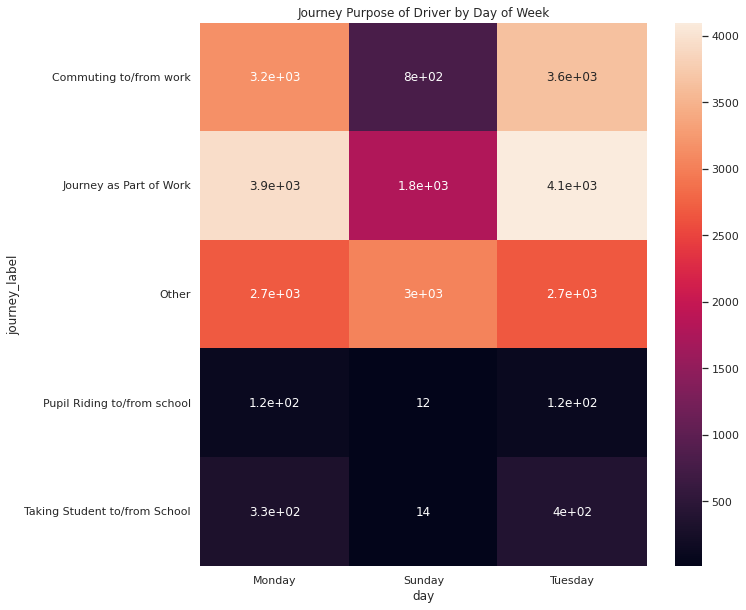

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Journey Purpose of Driver by Day of Week')
heatplot = sns.heatmap(subset.pivot(index='journey_label', columns='day', values=0), annot=True)
plt.show()


##### Journey Purpose of Driver and Accident Severity

In [ ]:
subset = v_acc[v_acc['Journey_Purpose_of_Driver']!=6]
subset = subset.groupby(['Journey_Purpose_of_Driver', 'Accident_Severity']).size().reset_index()
subset=subset.merge(journey_labels, how = 'inner', left_on= 'Journey_Purpose_of_Driver', right_on='journey_code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

In [ ]:
subset.columns

Index(['Journey_Purpose_of_Driver',         'Accident_Severity',
                                 0,              'journey_code',
                   'journey_label',                      'code',
                        'severity'],
      dtype='object')

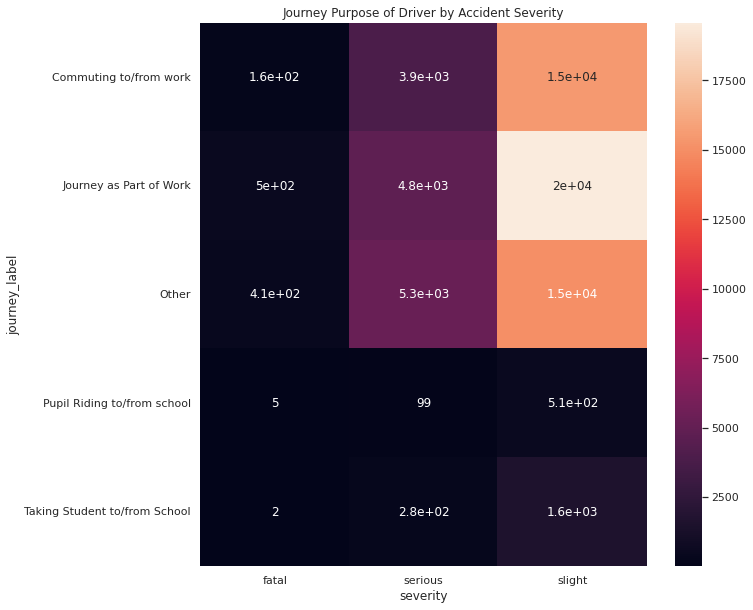

In [ ]:
#lineplt(subset, 'Accident_Severity', 'journey_label', 0, 10, 8, 'Accident Severity by Lighting', 'Day of Week', 'Accident Frequency', True)
plt.figure(figsize = (10,10))
plt.title('Journey Purpose of Driver by Accident Severity')
heatplot = sns.heatmap(subset.pivot(index='journey_label', columns='severity', values=0), annot=True)





##### Engine Capacity and Weather Conditions

In [ ]:
engine_labels = ['<500','<1000','<1500', '<2000','<2500','<3000','<5000', '<7000', '<20000']
engine_codes = [1,2,3,4,5,6,7,8,9]
engine_labels_df = pd.DataFrame(list(zip(engine_codes,engine_labels)), columns = ['engine_code', 'engine_label'])

In [ ]:
subset = v_acc.groupby(['Band_of_Engine_Capacity', 'Weather_Conditions']).size().reset_index()
subset=subset.merge(engine_labels_df, how = 'inner', left_on= 'Band_of_Engine_Capacity', right_on='engine_code')
subset=subset.merge(weather_labels, how = 'inner', left_on= 'Weather_Conditions', right_on='code')


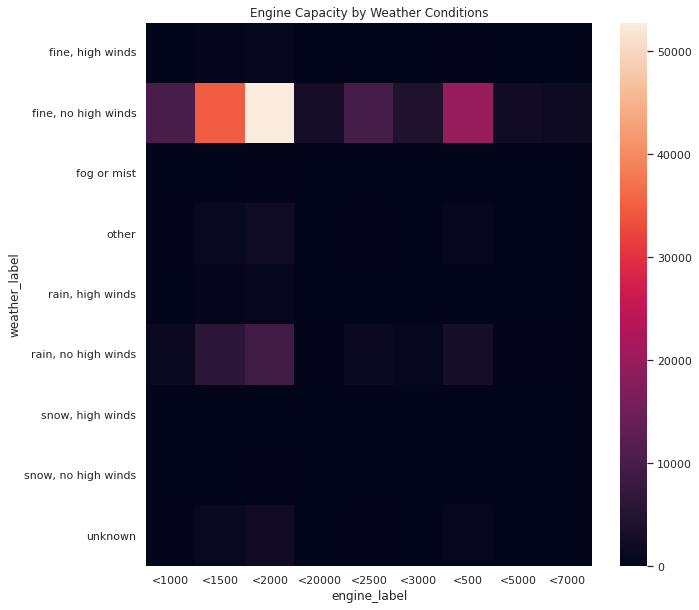

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Engine Capacity by Weather Conditions')
heatplot = sns.heatmap(subset.pivot(index='weather_label', columns='engine_label', values=0))
plt.show()


##### Engine Capacity and Light Conditions

In [ ]:
subset = v_acc.groupby(['Band_of_Engine_Capacity', 'Light_Conditions']).size().reset_index()
subset=subset.merge(engine_labels_df, how = 'inner', left_on= 'Band_of_Engine_Capacity', right_on='engine_code')
subset=subset.merge(light_labels, how = 'inner', left_on= 'Light_Conditions', right_on='light_code')


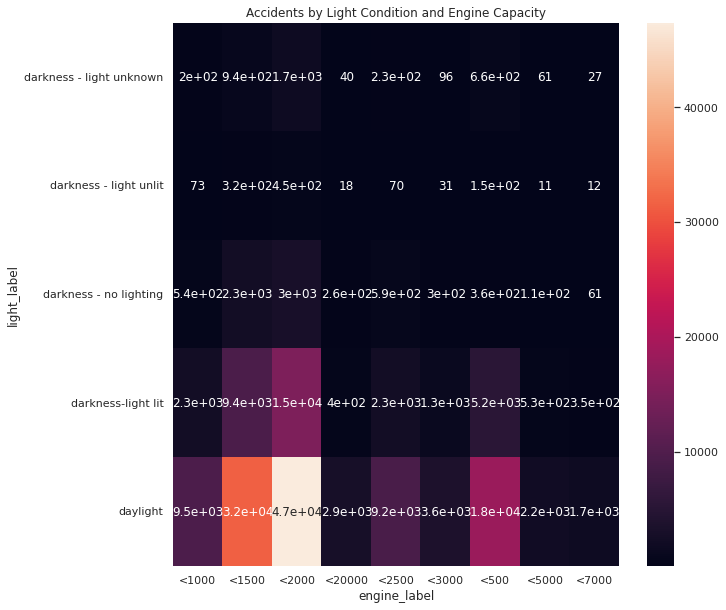

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Accidents by Light Condition and Engine Capacity')
heatplot = sns.heatmap(subset.pivot(index='light_label', columns='engine_label', values=0), annot=True)
plt.show()


##### Engine Capacity and Severity

In [ ]:
subset = v_acc.groupby(['Band_of_Engine_Capacity', 'Accident_Severity']).size().reset_index()
subset=subset.merge(engine_labels_df, how = 'inner', left_on= 'Band_of_Engine_Capacity', right_on='engine_code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

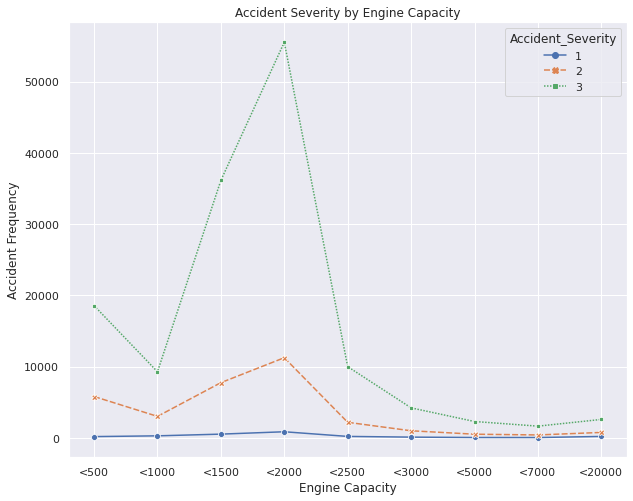

In [ ]:
lineplt(subset, 'Band_of_Engine_Capacity', 'Accident_Severity', 0, 10, 8, 'Accident Severity by Engine Capacity', 'Engine Capacity', 'Accident Frequency', True, engine_labels, engine_codes )


##### Sex of Driver 

In [ ]:
gender = ['male', 'female']
gender_code = [1,2]
gender_df = pd.DataFrame(list(zip(gender_code, gender)), columns = ['gender_code', 'gender'])

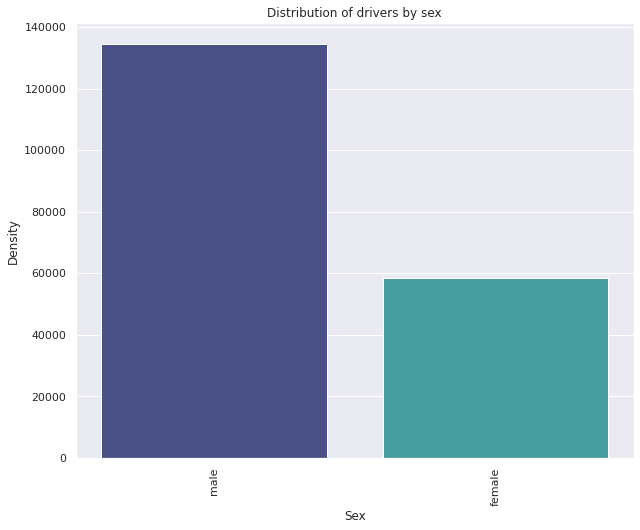

In [ ]:
subset = vehicle.groupby(['Sex_of_Driver']).size().reset_index()
subset = subset.merge(gender_df, how ='inner', left_on = 'Sex_of_Driver', right_on = 'gender_code')
barplt(10,8, subset, 'gender', 0, 'mako', 'Distribution of drivers by sex', 'Sex', 'Density', 90, None, None)


##### Sex of Driver and Accident Severity

In [ ]:
subset = v_acc.groupby(['Sex_of_Driver', 'Accident_Severity']).size().reset_index()
subset = subset.merge(gender_df, how ='inner', left_on = 'Sex_of_Driver', right_on = 'gender_code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

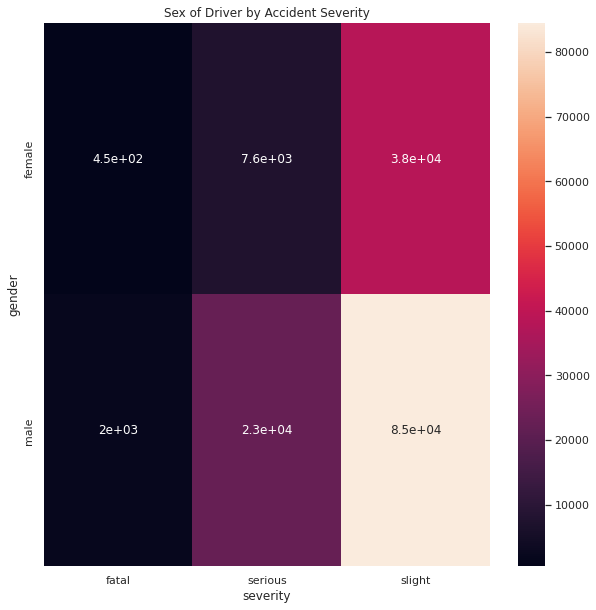

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Sex of Driver by Accident Severity')
heatplot = sns.heatmap(subset.pivot(index='gender', columns='severity', values=0), annot=True)
plt.show()


##### Age of Driver and Severity

In [ ]:
age_bands = ['0-5', '5-10', '10-15' , '15-20', '20-25', '25-35', '35-45', '45-55', '55-65', '65-75',  '75-120']
age_codes = [1,2,3,4,5,6,7,8,9,10,11]
age_labels = pd.DataFrame(list(zip(age_codes, age_bands)), columns = ['age_code', 'age_band'])

In [ ]:
subset = v_acc.groupby(['Accident_Severity', 'Age_Band_of_Driver']).size().reset_index()
subset=subset.merge(age_labels, how = 'inner', left_on= 'Age_Band_of_Driver', right_on='age_code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

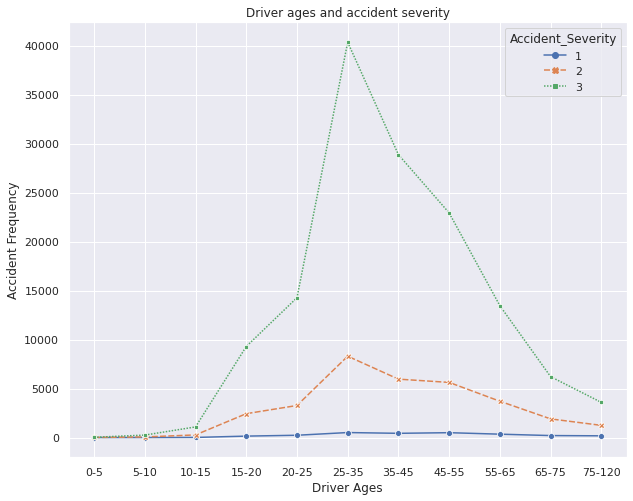

In [ ]:
lineplt(subset, 'Age_Band_of_Driver', 'Accident_Severity', 0, 10, 8, 'Driver ages and accident severity', 'Driver Ages', 'Accident Frequency', True, age_bands, age_codes)




##### Age of Vehicle and Severity

In [ ]:
vehicle_age_bands = ['0-5','5-10','10-15','15-20','>20']
vehicle_age_codes = [1,2,3,4,5]
vehicle_age_labels = pd.DataFrame(list(zip(vehicle_age_codes, vehicle_age_bands)), columns = ['vehicle_age_code', 'vehicle_age_band'])

In [ ]:
subset = v_acc.groupby(['Accident_Severity', 'Age_Band_of_Vehicle']).size().reset_index()
subset=subset.merge(vehicle_age_labels, how = 'inner', left_on= 'Age_Band_of_Vehicle', right_on='vehicle_age_code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

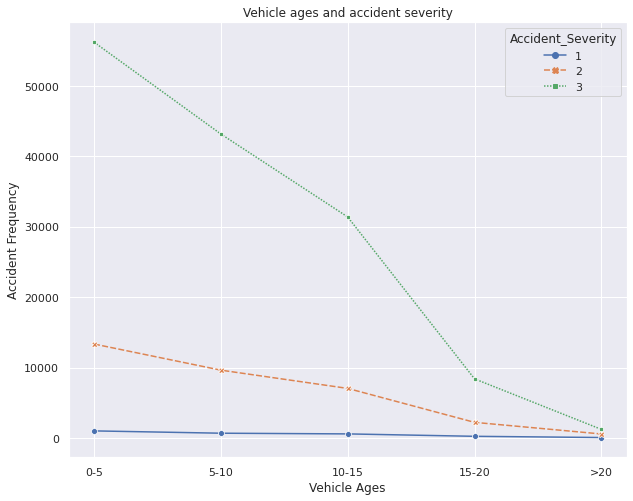

In [ ]:
lineplt(subset, 'Age_Band_of_Vehicle', 'Accident_Severity', 0, 10, 8, 'Vehicle ages and accident severity', 'Vehicle Ages', 'Accident Frequency', True, vehicle_age_bands, vehicle_age_codes)




In [ ]:
subset = v_acc[v_acc['Journey_Purpose_of_Driver']!=6]
subset = subset.groupby(['Journey_Purpose_of_Driver', 'Accident_Severity']).size().reset_index()
subset=subset.merge(journey_labels, how = 'inner', left_on= 'Journey_Purpose_of_Driver', right_on='journey_code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

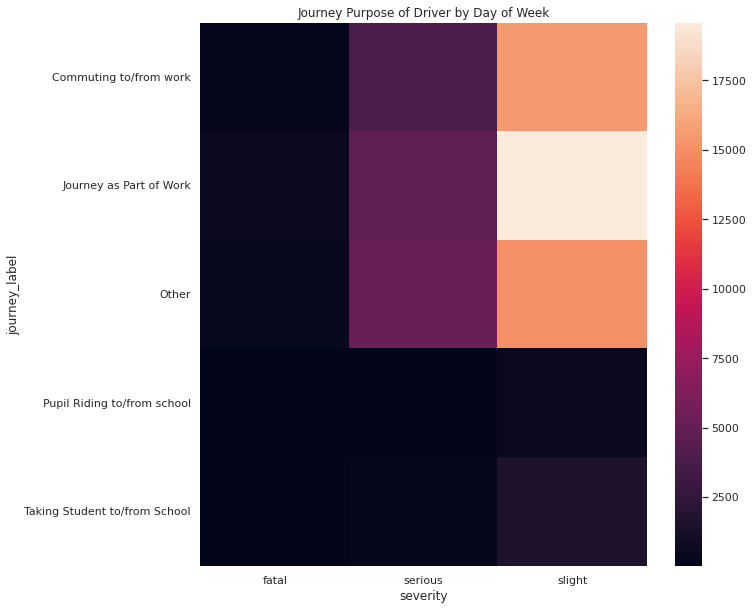

In [ ]:
#lineplt(subset, 'Accident_Severity', 'journey_label', 0, 10, 8, 'Accident Severity by Lighting', 'Day of Week', 'Accident Frequency', True)
plt.figure(figsize = (10,10))
plt.title('Journey Purpose of Driver by Day of Week')
heatplot = sns.heatmap(subset.pivot(index='journey_label', columns='severity', values=0))





#### Casualties

##### Distribution of Casualty Types

In [ ]:
casualty_code = [0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 16, 17, 18, 19, 20, 21, 22, 23, 90, 97, 98]
casualty_label = ['Pedestrian',
 'Cyclist',
 'Motorcycle 50cc and under rider or passenger',
 'Motorcycle 125cc and under rider or passenger',
 'Motorcycle over 125cc and up to 500cc rider or  passenger',
 'Motorcycle over 500cc rider or passenger',
 'Taxi/Private hire car occupant',
 'Car occupant',
 'Minibus (8 - 16 passenger seats) occupant',
 'Bus or coach occupant (17 or more pass seats)',
 'Horse rider',
 'Agricultural vehicle occupant',
 'Tram occupant',
 'Van / Goods vehicle (3.5 tonnes mgw or under) occupant',
 'Goods vehicle (over 3.5t. and under 7.5t.) occupant',
 'Goods vehicle (7.5 tonnes mgw and over) occupant',
 'Mobility scooter rider',
 'Electric motorcycle rider or passenger',
 'Other vehicle occupant',
 'Motorcycle - unknown cc rider or passenger',
 'Goods vehicle (unknown weight) occupant']

casualty_types = pd.DataFrame(list(zip(casualty_code, casualty_label)), columns = ['casualty_code', 'casualty_label'])

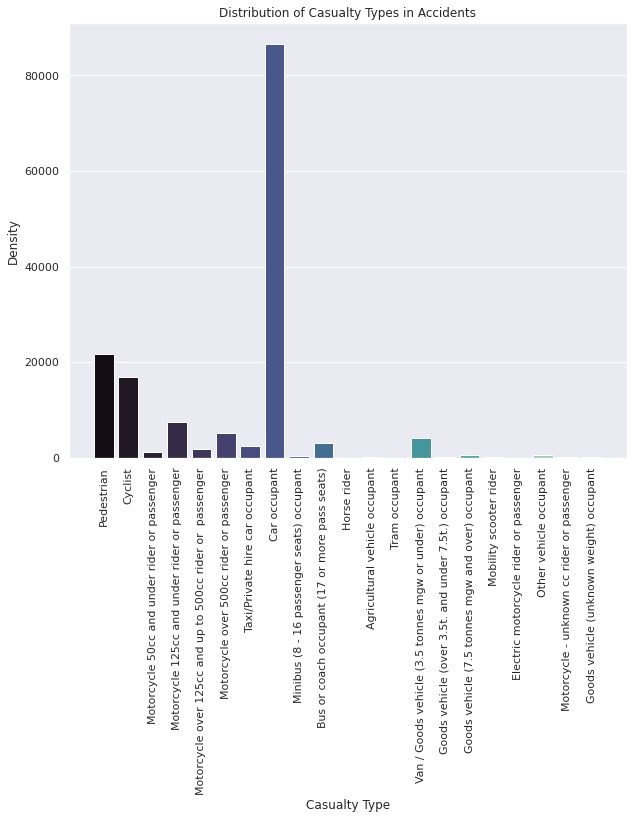

In [ ]:
subset = casualty.groupby(['Casualty_Type']).size().reset_index()
subset = subset.merge(casualty_types, how='inner', left_on ='Casualty_Type', right_on='casualty_code')
barplt(10,8, subset, 'casualty_label', 0, 'mako', 'Distribution of Casualty Types in Accidents', 'Casualty Type', 'Density', 90, None, None)


##### Age Band with accident Severity

In [ ]:
subset = c_acc.groupby(['Accident_Severity', 'Age_Band_of_Casualty']).size().reset_index()
subset=subset.merge(age_labels, how = 'inner', left_on= 'Age_Band_of_Casualty', right_on='age_code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

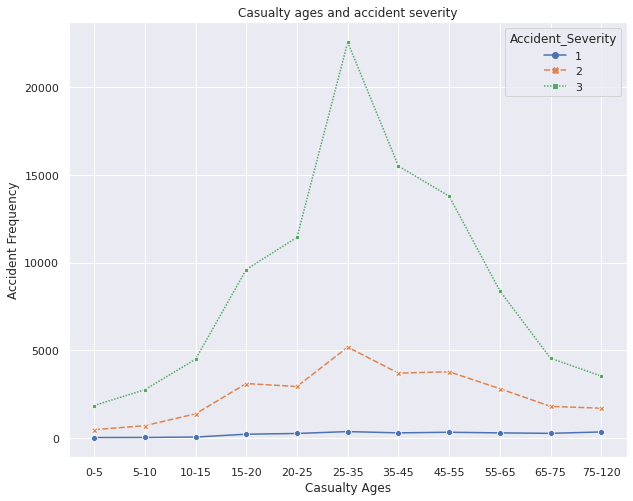

In [ ]:
lineplt(subset, 'Age_Band_of_Casualty', 'Accident_Severity', 0, 10, 8, 'Casualty ages and accident severity', 'Casualty Ages', 'Accident Frequency', True, age_bands, age_codes)




##### Sex of Casualty

In [ ]:
gender = ['male', 'female']
gender_code = [1,2]
gender_df = pd.DataFrame(list(zip(gender_code, gender)), columns = ['gender_code', 'gender'])

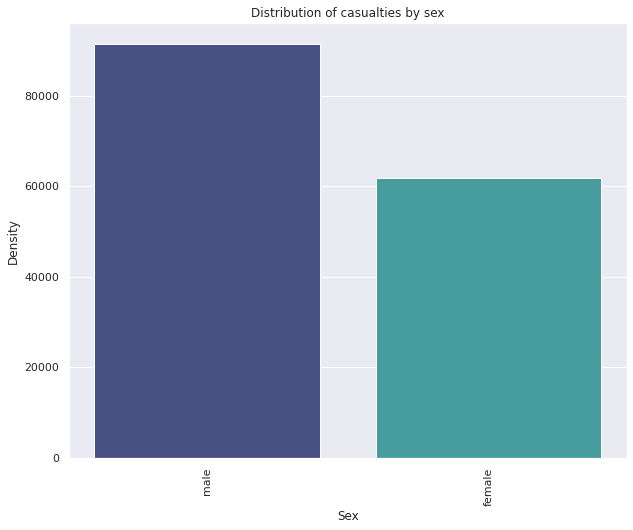

In [ ]:
subset = casualty.groupby(['Sex_of_Casualty']).size().reset_index()
subset = subset.merge(gender_df, how ='inner', left_on = 'Sex_of_Casualty', right_on = 'gender_code')
barplt(10,8, subset, 'gender', 0, 'mako', 'Distribution of casualties by sex', 'Sex', 'Density', 90, None, None)


##### Sex of Casualty by Accident Severity

In [ ]:
subset = c_acc.groupby(['Sex_of_Casualty', 'Accident_Severity']).size().reset_index()
subset = subset.merge(gender_df, how ='inner', left_on = 'Sex_of_Casualty', right_on = 'gender_code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

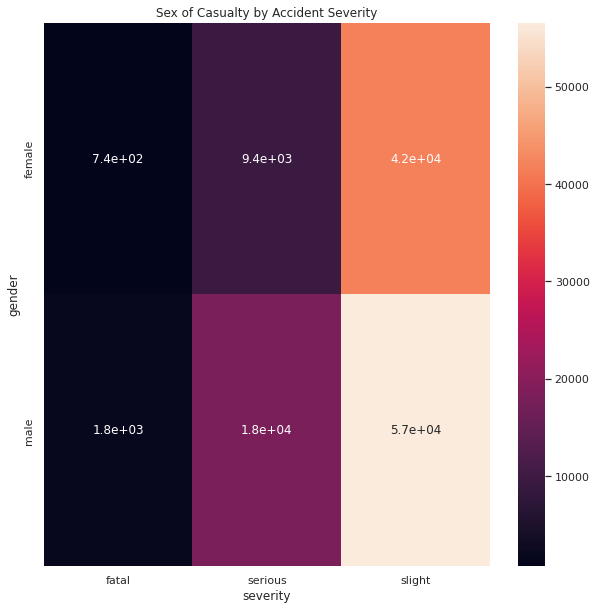

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Sex of Casualty by Accident Severity')
heatplot = sns.heatmap(subset.pivot(index='gender', columns='severity', values=0), annot=True)
plt.show()


##### Home Area Types with Accident Severity

In [ ]:
home =['urban_area', 'small_town', 'rural']
home_code = [1,2,3]
home_df = pd.DataFrame(list(zip(home_code, home)), columns = ['home_code', 'home'])

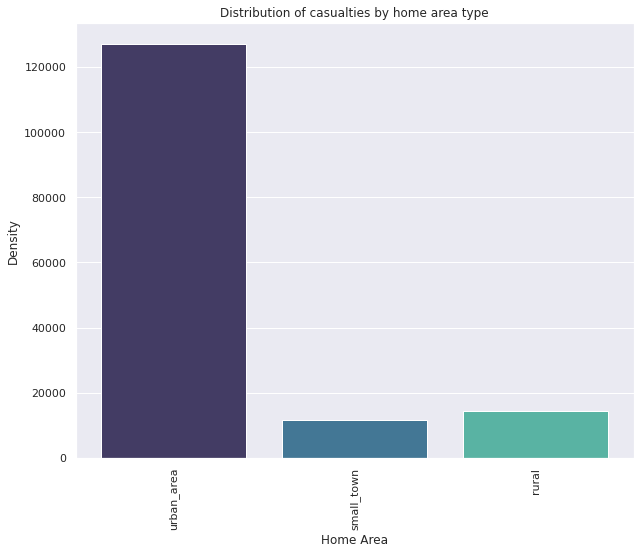

In [ ]:
subset = casualty.groupby(['Casualty_Home_Area_Type']).size().reset_index()
subset = subset.merge(home_df, how ='inner', left_on = 'Casualty_Home_Area_Type', right_on = 'home_code')
barplt(10,8, subset, 'home', 0, 'mako', 'Distribution of casualties by home area type', 'Home Area', 'Density', 90, None, None)


In [ ]:
subset = c_acc.groupby(['Casualty_Home_Area_Type', 'Accident_Severity']).size().reset_index()
subset = subset.merge(home_df, how ='inner', left_on = 'Casualty_Home_Area_Type', right_on = 'home_code')
subset=subset.merge(acc_labels, how = 'inner', left_on= 'Accident_Severity', right_on='code')

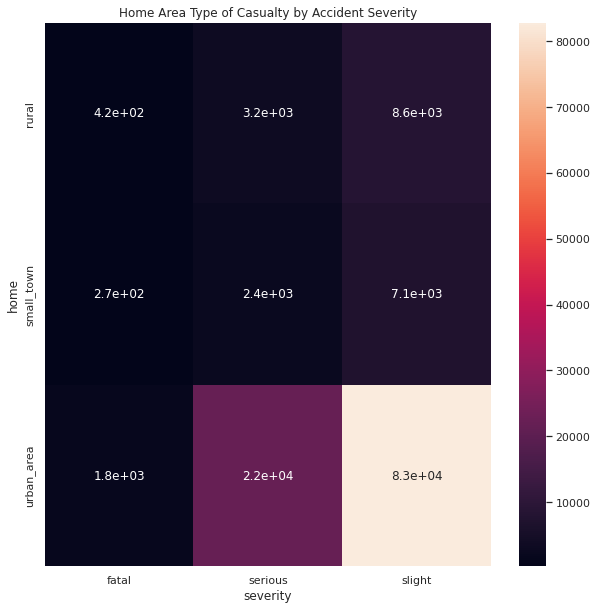

In [ ]:
plt.figure(figsize = (10,10))
plt.title('Home Area Type of Casualty by Accident Severity')
heatplot = sns.heatmap(subset.pivot(index='home', columns='severity', values=0), annot=True)
plt.show()


## Prediction Begins

In [ ]:
accident.columns

Index(['Month_Label', 'Day_Label', 'Accident_Index', 'Location_Easting_OSGR',
       'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force',
       'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
       'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)',
       'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number',
       'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control',
       '2nd_Road_Class', '2nd_Road_Number',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'converted_time', 'Month',
       'converted_time_classes', 'converted_time_Sunset',
       'converted_time_Sunrise', 'converted_time_Day length',
       'converted_time_Su

##### Extracting Categorical Columns

In [ ]:
# extracting the categorical columns for accidents

acc_cols = list(accident.columns)
num_cols = ['Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Number_of_Vehicles', 'Number_of_Casualties',
            'converted_time', 'converted_time_Sunset','converted_time_Sunrise', 'converted_time_Day length']
for col in num_cols:
  acc_cols.remove(col)

# extracting the categorical columns for vehicles

veh_cols = list(vehicle.columns)
num_cols = ['Age_of_Driver', 'Age_of_Vehicle', 'Engine_Capacity_(CC)']
for col in num_cols:
  veh_cols.remove(col)

# extracting the categorical columns for casualty

cas_cols = list(casualty.columns)
cas_cols.remove('Age_of_Casualty')

##### Making Categorical Columns String Type

In [ ]:
#Making the categorical columns string (object type)

accident[acc_cols] = accident[acc_cols].astype(str)
#making the last column accident severity
accident = replace_y(accident, 'Accident_Severity')
vehicle[veh_cols] = vehicle[veh_cols].astype(str)
casualty[cas_cols] = casualty[cas_cols].astype(str)


##### merging vehicle and casualty dataframes

In [ ]:
# dropping the columns that won't be used during training

accident.drop(['Local_Authority_(Highway)', 'LSOA_of_Accident_Location', 'Date', 'Time', 'Number_of_Vehicles',
       'Number_of_Casualties','1st_Road_Number','2nd_Road_Number','Did_Police_Officer_Attend_Scene_of_Accident'], axis=1, inplace = True)
vehicle.drop([ 'Label', 'Towing_and_Articulation', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway',
              'Hit_Object_off_Carriageway','1st_Point_of_Impact', 'Hit_Object', 'Towed?', 'Skid_or_Overturn?',], axis=1, inplace = True)
casualty.drop(['Casualty_Reference', 'Casualty_Severity'], axis=1, inplace = True)

In [ ]:
v_acc = vehicle.merge(accident, how='inner', on='Accident_Index')
c_acc = casualty.merge(accident, how='inner', on='Accident_Index')

##### merging all three dataframes

In [ ]:
vac_merged = c_acc.merge(vehicle, how='inner', on=['Accident_Index', 'Vehicle_Reference'])
vac_merged_copy = vac_merged.copy()

In [ ]:
# dropping the columns that won't be used during training

accident.drop(['Accident_Index'], axis=1, inplace = True)
vehicle.drop(['Accident_Index', 'Vehicle_Reference'], axis=1, inplace = True)
casualty.drop(['Accident_Index', 'Vehicle_Reference'], axis=1, inplace = True)

In [ ]:
# dropping the columns that won't be used during training

v_acc.drop(['Accident_Index', 'Vehicle_Reference'], axis=1, inplace=True)
c_acc.drop(['Accident_Index', 'Vehicle_Reference'], axis=1, inplace=True)
vac_merged.drop(['Accident_Index', 'Vehicle_Reference'], axis=1, inplace=True)

vac_merged= replace_y(vac_merged, 'Accident_Severity')
c_acc = replace_y(c_acc, 'Accident_Severity')

In [ ]:
#these selectors return categorical and numerical column names as lists
cat_selector = mcs(dtype_include=object)
num_selector = mcs(dtype_include=np.number)

In [ ]:
scaler = make_pipeline(StandardScaler())

#for feature selection, it's more practical to use ordinal encoder
encoder = make_pipeline(OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=99999))

#I one hot encoded after selecting features
one_hot_encoder = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

#returns standard scaled columns
scaled_num_features = make_column_transformer((scaler, num_selector))
#returns ordinal encoded columns
encoded_cat_features = make_column_transformer((encoder, cat_selector))


##### function for preprocessing selected columns as one hot, ordinal, or scaled

In [ ]:
'''
since this transformer is applied to the final dataframe (after feature selection) it uses one hot encoding and label encoding
I specify the columns that will be one hot encoded and those that will be ordinally encoded
'''

def preprocess_final(one_hot_features, ordinal_features):
  all_features = make_column_transformer((scaler, num_selector), (one_hot_encoder, one_hot_features ), (encoder, ordinal_features ))
  return all_features

##### returns bar graph of features for training using kbest

In [ ]:
#model training feature selector
def feature_pipeline(features, selector, score_function, kvalue, X_train, y_train, X_test):
  feature_pipeline = make_pipeline(features, SelectKBest(score_func=score_function, k=kvalue))
  features = feature_pipeline.fit(X_train, y_train)
  score_plot(features.named_steps['selectkbest'], selector(X_train))
  
  for i in list(features.named_steps['selectkbest'].get_support(1)):
    print(selector(X_train)[i])

In [ ]:
vac_merged.columns

Index(['Casualty_Class', 'Sex_of_Casualty', 'Age_of_Casualty',
       'Age_Band_of_Casualty', 'Pedestrian_Location', 'Pedestrian_Movement',
       'Car_Passenger', 'Bus_or_Coach_Passenger',
       'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type',
       'Casualty_Home_Area_Type', 'Casualty_IMD_Decile', 'Month_Label',
       'Day_Label', 'Location_Easting_OSGR', 'Location_Northing_OSGR',
       'Longitude', 'Latitude', 'Police_Force', 'Day_of_Week',
       'Local_Authority_(District)', '1st_Road_Class', 'Road_Type',
       'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class',
       'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'converted_time', 'Month',
       'converted_time_classes', 'converted_time_Sunset',
       'converted_time_Sunrise', 'converted_time_D

Train (107210, 65) (107210,)
Test (45948, 65) (45948,)

 new frame


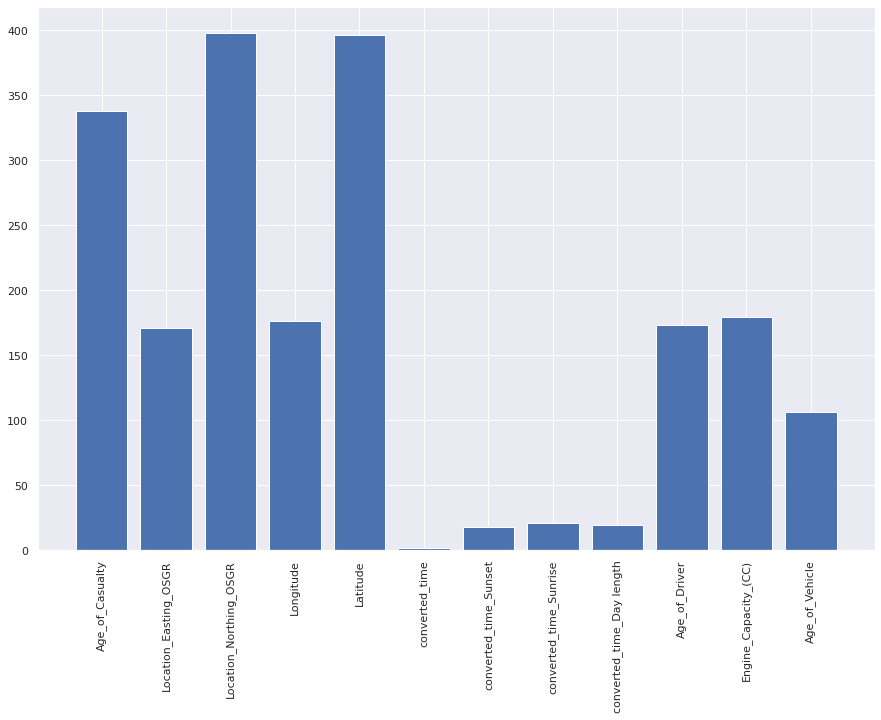

Age_of_Casualty
Location_Northing_OSGR
Latitude
Engine_Capacity_(CC)


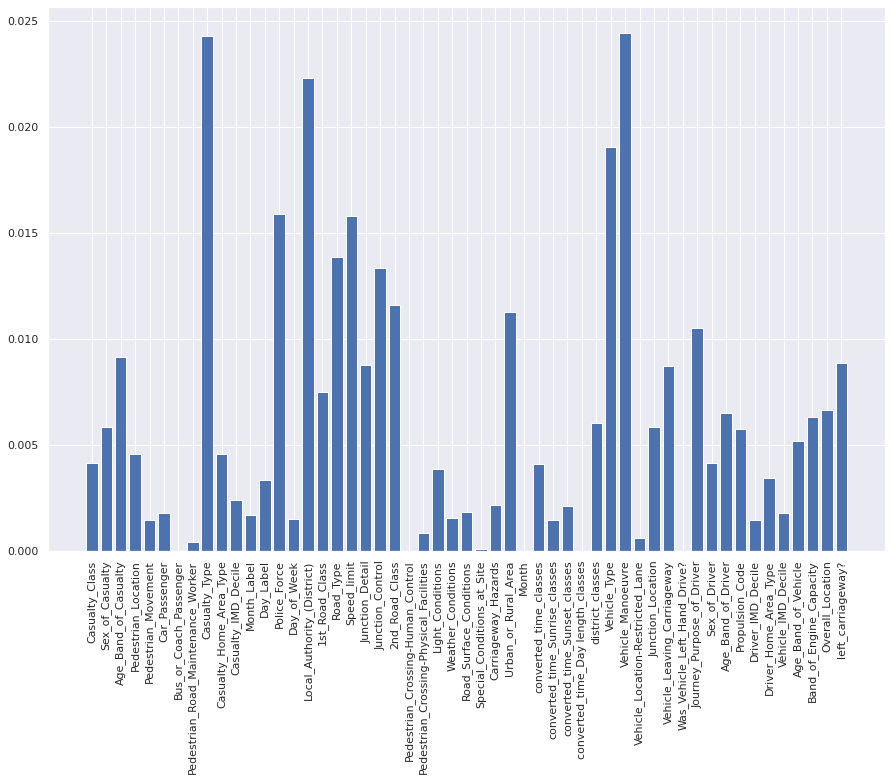

Sex_of_Casualty
Age_Band_of_Casualty
Pedestrian_Location
Casualty_Type
Casualty_Home_Area_Type
Police_Force
Local_Authority_(District)
1st_Road_Class
Road_Type
Speed_limit
Junction_Detail
Junction_Control
2nd_Road_Class
Urban_or_Rural_Area
district_classes
Vehicle_Type
Vehicle_Manoeuvre
Junction_Location
Vehicle_Leaving_Carriageway
Journey_Purpose_of_Driver
Age_Band_of_Driver
Propulsion_Code
Age_Band_of_Vehicle
Band_of_Engine_Capacity
Overall_Location
left_carriageway?


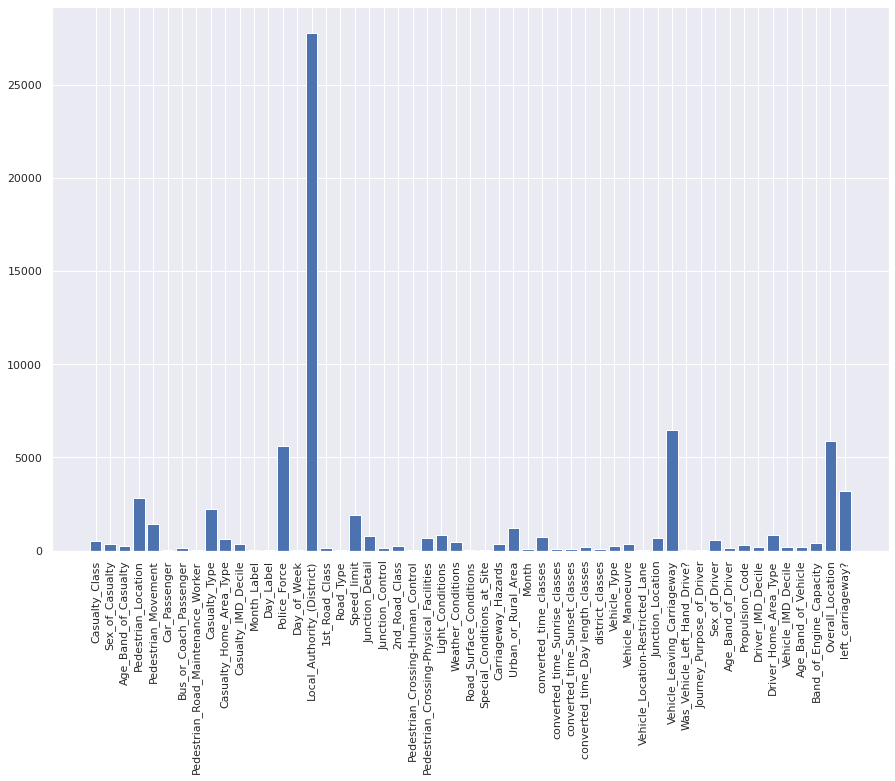

Casualty_Class
Sex_of_Casualty
Pedestrian_Location
Pedestrian_Movement
Casualty_Type
Casualty_Home_Area_Type
Casualty_IMD_Decile
Police_Force
Local_Authority_(District)
Speed_limit
Junction_Detail
Pedestrian_Crossing-Physical_Facilities
Light_Conditions
Weather_Conditions
Carriageway_Hazards
Urban_or_Rural_Area
converted_time_classes
Vehicle_Manoeuvre
Junction_Location
Vehicle_Leaving_Carriageway
Sex_of_Driver
Propulsion_Code
Driver_Home_Area_Type
Band_of_Engine_Capacity
Overall_Location
left_carriageway?
Train (82275, 33) (82275,)
Test (35261, 33) (35261,)

 new frame


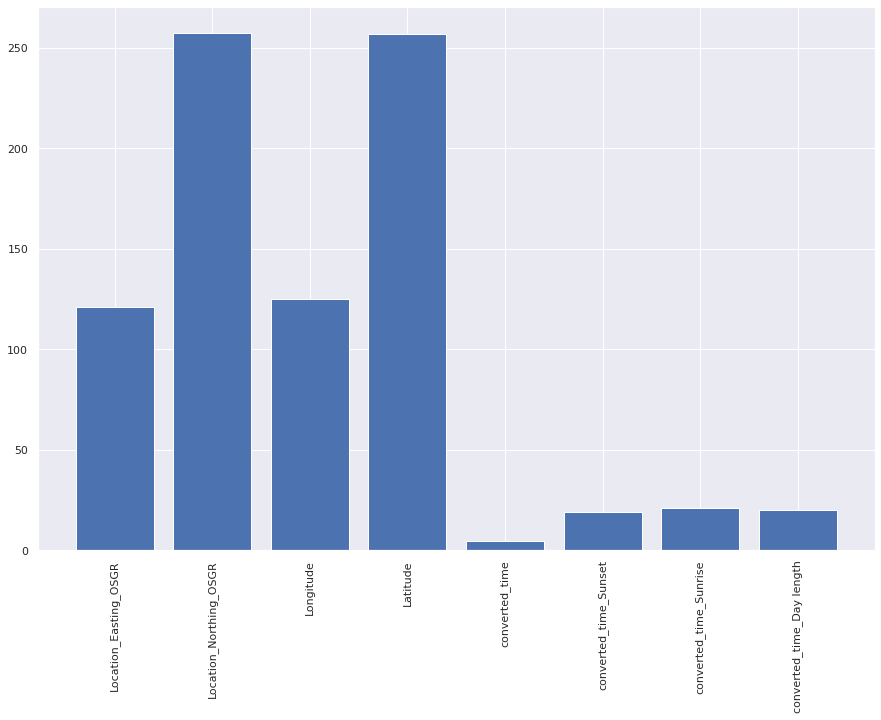

Location_Northing_OSGR
Latitude


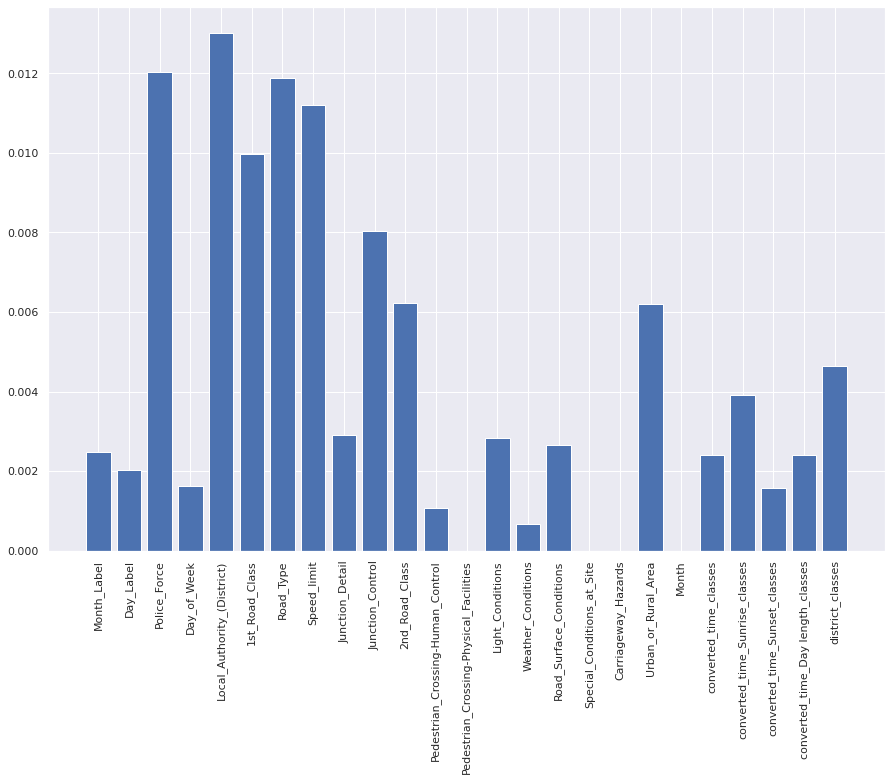

Police_Force
Local_Authority_(District)
1st_Road_Class
Road_Type
Speed_limit
Junction_Detail
Junction_Control
2nd_Road_Class
Light_Conditions
Urban_or_Rural_Area
converted_time_Sunrise_classes
district_classes


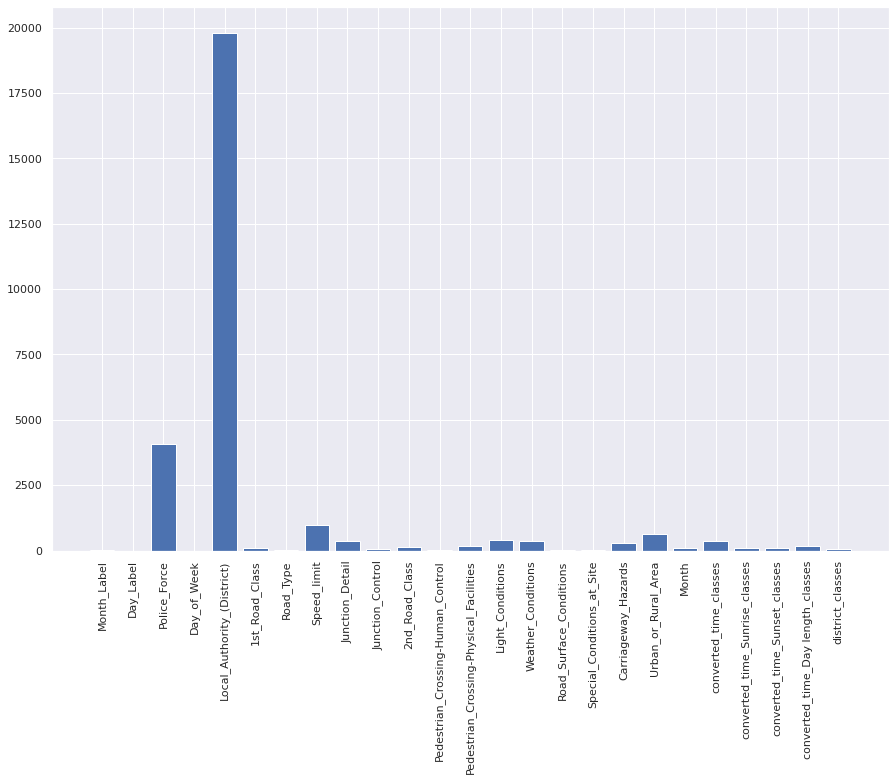

Police_Force
Local_Authority_(District)
Speed_limit
Junction_Detail
2nd_Road_Class
Pedestrian_Crossing-Physical_Facilities
Light_Conditions
Weather_Conditions
Carriageway_Hazards
Urban_or_Rural_Area
converted_time_classes
converted_time_Day length_classes
Train (151466, 53) (151466,)
Test (64915, 53) (64915,)

 new frame


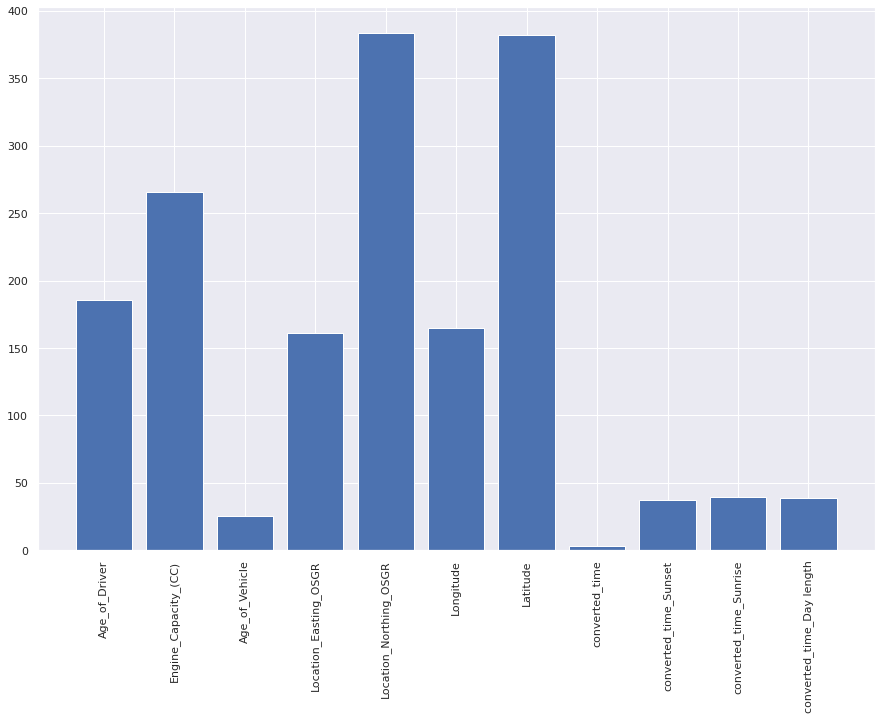

Engine_Capacity_(CC)
Location_Northing_OSGR
Latitude


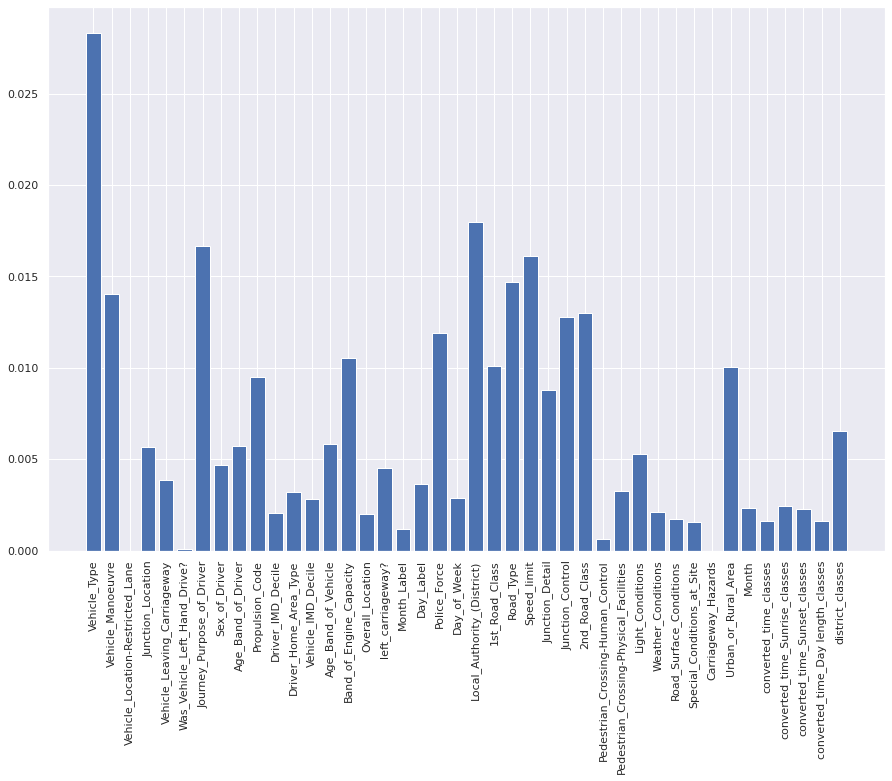

Vehicle_Type
Vehicle_Manoeuvre
Junction_Location
Journey_Purpose_of_Driver
Sex_of_Driver
Age_Band_of_Driver
Propulsion_Code
Age_Band_of_Vehicle
Band_of_Engine_Capacity
left_carriageway?
Police_Force
Local_Authority_(District)
1st_Road_Class
Road_Type
Speed_limit
Junction_Detail
Junction_Control
2nd_Road_Class
Light_Conditions
Urban_or_Rural_Area
district_classes


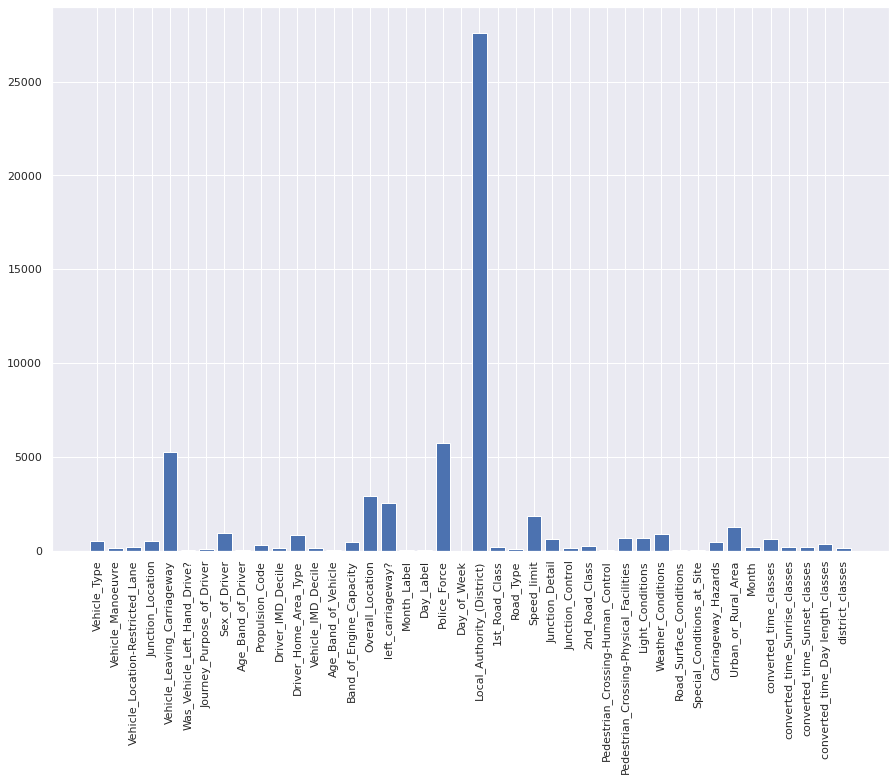

Vehicle_Type
Junction_Location
Vehicle_Leaving_Carriageway
Sex_of_Driver
Propulsion_Code
Driver_Home_Area_Type
Band_of_Engine_Capacity
Overall_Location
left_carriageway?
Police_Force
Local_Authority_(District)
Speed_limit
Junction_Detail
2nd_Road_Class
Pedestrian_Crossing-Physical_Facilities
Light_Conditions
Weather_Conditions
Carriageway_Hazards
Urban_or_Rural_Area
converted_time_classes
converted_time_Day length_classes
Train (107210, 45) (107210,)
Test (45948, 45) (45948,)

 new frame


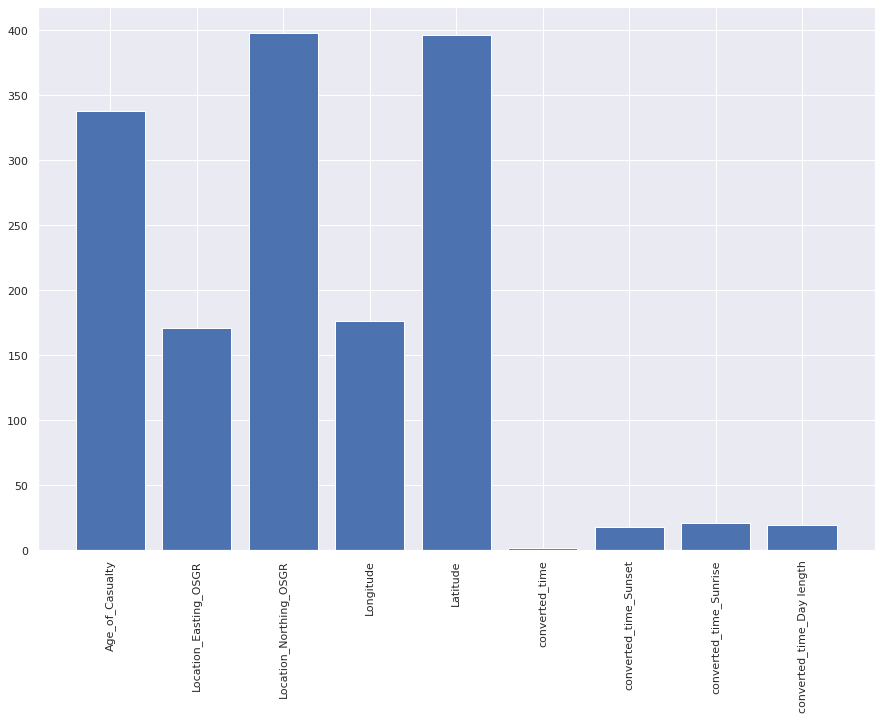

Age_of_Casualty
Location_Northing_OSGR
Latitude


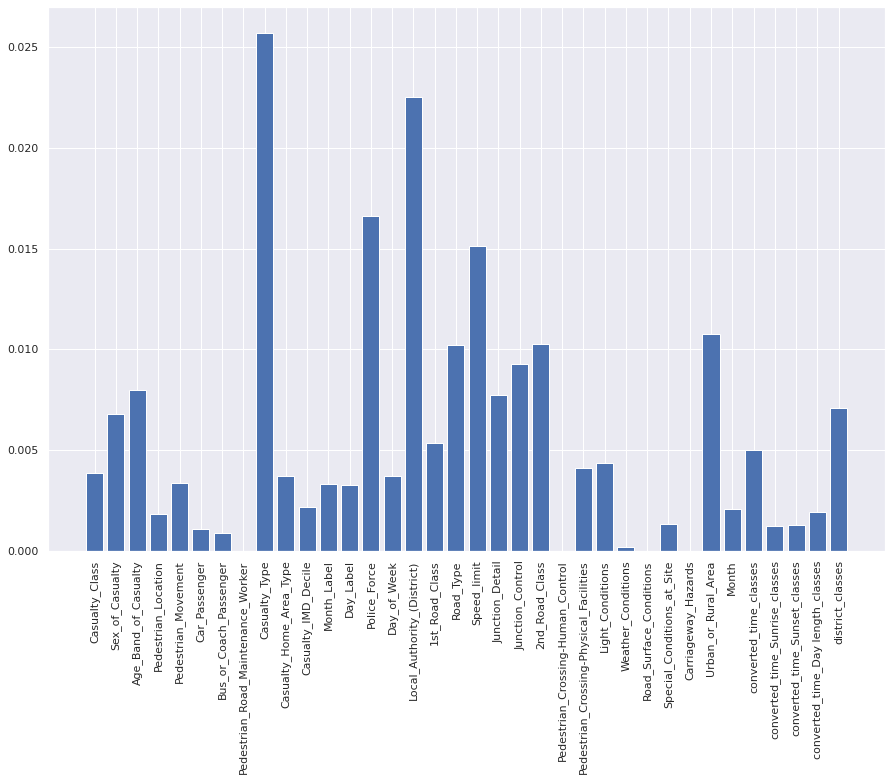

Casualty_Class
Sex_of_Casualty
Age_Band_of_Casualty
Casualty_Type
Casualty_Home_Area_Type
Police_Force
Local_Authority_(District)
1st_Road_Class
Road_Type
Speed_limit
Junction_Detail
Junction_Control
2nd_Road_Class
Pedestrian_Crossing-Physical_Facilities
Light_Conditions
Urban_or_Rural_Area
converted_time_classes
district_classes


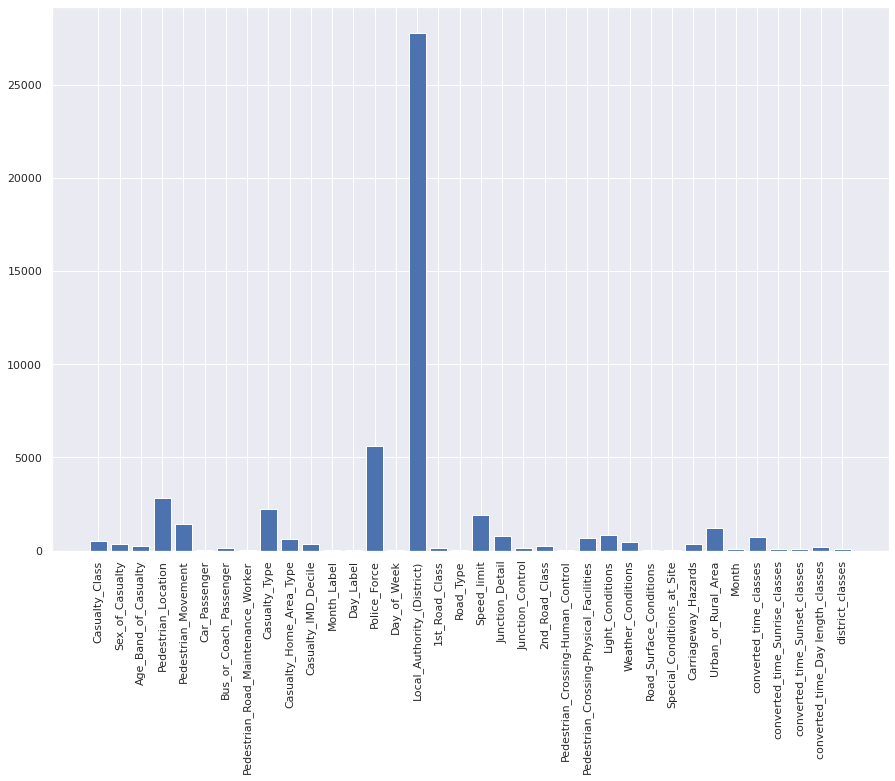

Casualty_Class
Sex_of_Casualty
Age_Band_of_Casualty
Pedestrian_Location
Pedestrian_Movement
Casualty_Type
Casualty_Home_Area_Type
Casualty_IMD_Decile
Police_Force
Local_Authority_(District)
Speed_limit
Junction_Detail
Pedestrian_Crossing-Physical_Facilities
Light_Conditions
Weather_Conditions
Carriageway_Hazards
Urban_or_Rural_Area
converted_time_classes


In [ ]:
#feature selecting for all three input dataframes
for df in [vac_merged, accident, v_acc, c_acc]:
  X_train, X_test, y_train, y_test = split(df, 0.3,42,None)
  print('\n new frame')

  #using anova
  fclassif = feature_pipeline(scaled_num_features, num_selector, f_classif, int(len(num_selector(X_train))/3), X_train, y_train, X_test)
  #using mutual info
  mutual = feature_pipeline(encoded_cat_features, cat_selector, mutual_info_classif, int(len(cat_selector(X_train))/2), X_train, y_train, X_test)
  #using chi square
  chi = feature_pipeline(encoded_cat_features, cat_selector, chi2, int(len(cat_selector(X_train))/2), X_train, y_train, X_test)

## Implementing ML models to predict accident severity

##### function for implementing neural network

In [ ]:
def deep_model(X_train, X_test, y_train, y_test):

  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  # determine the number of input features
  n_features = X_train.shape[1]
  # define model
  model = Sequential()
  model.add(Dense(10, activation='relu', input_shape=(n_features,)))
  model.add(Dense(3, activation='softmax'))
  # compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  # fit the model
  model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
  # evaluate the model
  loss, acc = model.evaluate(X_test, y_test, verbose=0)
  print('Test Accuracy: %.3f' % acc)
  ypred = model.predict(X_test)
  ConfusionMatrixDisplay.from_predictions(y_test, ypred)
  plt.show()
  print(metrics.classification_report(y_test, ypred))



##### function of machine learning pipelines (models)

In [ ]:
#machine learning pipelines

def ml_pipelines(one_hot, ordinal, lr_param_grid,dt_param_grid, rf_param_grid, knn_param_grid, xg_param_grid):

  #defining all of the ml pipelines
  
  pipe_lr = Pipeline([('preprocess',preprocess_final(one_hot, ordinal)),
                    ('LR', LogisticRegression(random_state=1, multi_class='multinomial', solver='saga', max_iter=10000))])
  pipe_dt = Pipeline([('preprocess',preprocess_final(one_hot, ordinal)),
                    ('DT',DecisionTreeClassifier(random_state=1))])
  pipe_rf = Pipeline([('preprocess',preprocess_final(one_hot, ordinal)),
          ('RF',RandomForestClassifier(random_state=1))])
  pipe_knn = Pipeline([('preprocess',preprocess_final(one_hot, ordinal)),
                    ('KNN', KNeighborsClassifier())])
  pipe_xg = Pipeline([('preprocess',preprocess_final(one_hot, ordinal)),
                    ('XG', XGBClassifier())])
  
  
  # Grid searches for each ml model

  lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid,
        scoring='accuracy'
      )
  dt_grid_search = GridSearchCV(estimator=pipe_dt,
        param_grid=dt_param_grid,
        scoring='accuracy'
        )

  rf_grid_search = GridSearchCV(estimator=pipe_rf,

        param_grid=rf_param_grid,
        scoring='accuracy'
      )
  
  knn_grid_search = GridSearchCV(estimator=pipe_knn,
        param_grid=knn_param_grid,
        scoring='accuracy'
        )
  xg_grid_search = GridSearchCV(estimator=pipe_xg,
        param_grid=xg_param_grid,
        scoring='accuracy'
        )

  return [lr_grid_search, dt_grid_search, rf_grid_search, knn_grid_search, xg_grid_search]
  

##### function to implement grid search

In [ ]:

def grid_search(X_train, X_test, y_train, y_test,one_hot, ordinal, lr_param_grid,dt_param_grid, rf_param_grid, knn_param_grid, xg_param_grid):
  grids= ml_pipelines(one_hot, ordinal,lr_param_grid, dt_param_grid, rf_param_grid, knn_param_grid, xg_param_grid)
  grid_dict = {0: 'LGR', 1:'Decision Trees', 
              2: 'Random Forest', 3: 'K Nearest Neighbours', 4: 'XG Boost'}
#printing the confusion matrix for each search

  for pipe in grids:
        pipe.fit(X_train,y_train)
        print(pipe.score(X_test,y_test))
        y_pred = pipe.predict(X_test)
        ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
        plt.show()
        print(pipe.best_params_)



#### function for stacking models

In [ ]:
def stack_models(X_train, X_test, y_train, y_test, one_hot, ordinal, lr_c, dt_crit, dt_depth, dt_leaf,
                 dt_sample, rf_sample, rf_depth, rf_split, knn_metric, knn_neighbours, knn_weight, xg_depth, xg_estimate):
  #getting the ml pipelines
  ml_pipes = ml_pipelines_separate(one_hot, ordinal, lr_c, dt_crit, dt_depth, dt_leaf,
                 dt_sample, rf_sample, rf_depth, rf_split, knn_metric,knn_neighbours, knn_weight, xg_depth, xg_estimate)
  #to be stacked
  estimators = [
    ("logistics", ml_pipes[0]),          
    ("Decision Tree", ml_pipes[1]),
    ("Random Forest", ml_pipes[2]),
    ('knn',ml_pipes[3]),
    ('xg', ml_pipes[4])

    ]
    
  stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42, C= 0.1, 
                                                                                                     multi_class='multinomial', 
                                                                                                     solver='saga', max_iter=10000))
  
  #printing the cfusion matrix for the classification
  stacking_classifier.fit(X_train, y_train)
  print(stacking_classifier.score(X_test,y_test))
  y_pred = stacking_classifier.predict(X_test)
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  print(metrics.classification_report(y_test, y_pred))
  plt.show()
  return stacking_classifier.predict_proba(X_test)

##### range of possible parameters

In [ ]:
#defining all possible parameters for grid search

param_range = [1, 2, 3, 4, 5,6,7]
param_range_fl = [1.0, 0.5, 0.1]
n_estimators = [50,100,150]
learning_rates = [.1,.2,.3]
gamma_values = [1, 0.1, 0.01, 0.001]
lr_param_grid = [{'LR__C': param_range_fl}]
dt_param_grid = [{'DT__criterion': ['gini', 'entropy'],
                   'DT__min_samples_leaf': param_range,
                   'DT__max_depth': param_range,
                   'DT__min_samples_split': param_range[1:]}]
rf_param_grid = [{'RF__min_samples_leaf': param_range,
                   'RF__max_depth': param_range,
                   'RF__min_samples_split': param_range[1:]}]
knn_param_grid = [{'KNN__n_neighbors': param_range,
                   'KNN__weights': ['uniform', 'distance'],
                   'KNN__metric': ['euclidean', 'manhattan']}]
xg_param_grid = {
    'XG__max_depth': param_range,
    'XG__n_estimators': n_estimators,
}

svm_param_grid = [{'SVM__kernel': ['linear', 'rbf'], 
                    'SVM__C': param_range,
                   'SVM__gamma': gamma_values}]


##### machine learning pipelines without grid search

In [ ]:
def ml_pipelines_separate(one_hot, ordinal, lr_c, dt_crit, dt_depth, dt_leaf,
                 dt_sample, rf_sample, rf_depth, rf_split, knn_metric, knn_neighbours, knn_weight, xg_depth, xg_estimate):
  pipe_lr = Pipeline([('preprocess',preprocess_final(one_hot, ordinal)),
                    ('LR', LogisticRegression(random_state=1, C= lr_c, multi_class='multinomial', solver='saga', max_iter=10000))])
  pipe_dt = Pipeline([('preprocess',preprocess_final(one_hot, ordinal)),
                    ('DT',DecisionTreeClassifier(random_state=1, criterion = dt_crit, max_depth=dt_depth, min_samples_leaf= dt_leaf, 
                                                 min_samples_split= dt_sample))])
  pipe_rf = Pipeline([('preprocess',preprocess_final(one_hot, ordinal)),
                    ('RF',RandomForestClassifier(random_state=1, max_depth= rf_depth, 
                                                 min_samples_leaf= rf_sample, min_samples_split= rf_split))])

  pipe_knn = Pipeline([('preprocess',preprocess_final(one_hot, ordinal)),
                    ('KNN', KNeighborsClassifier(metric = knn_metric, n_neighbors = knn_neighbours, weights = knn_weight))])
  pipe_xg = Pipeline([('preprocess',preprocess_final(one_hot, ordinal)),
                    ('XG', XGBClassifier(max_depth = xg_depth, n_estimators =  xg_estimate))])
  return [pipe_lr, pipe_dt, pipe_rf, pipe_knn, pipe_xg]


  

##### fitting the ml pipelines

In [ ]:
def model_fit(X_train, X_test, y_train, y_test, one_hot, ordinal, lr_c, dt_crit, dt_depth, dt_leaf,
                 dt_sample, rf_sample, rf_depth, rf_split, knn_metric, knn_neighbours, knn_weight, xg_depth, xg_estimate):
  
  ml_pipes = ml_pipelines_separate(one_hot, ordinal, lr_c, dt_crit, dt_depth, dt_leaf,
                 dt_sample, rf_sample, rf_depth, rf_split, knn_metric, knn_neighbours, knn_weight, xg_depth, xg_estimate)
  names = {0: 'Logistic Regression', 1: 'Decision Trees', 
          2: 'Random Forest', 3: 'KNN', 4: 'XG Boost'}
  i=0
  probs = []
  for pipe in ml_pipes:
    pipe.fit(X_train, y_train)
    print('{} Test Accuracy: {}'.format(names[i],
          pipe.score(X_test,y_test)))
    y_pred = pipe.predict(X_test)
    probs.append(pipe.predict_proba(X_test))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    print(metrics.classification_report(y_test, y_pred))
    plt.figure(figsize = (10,10))
    plt.show()
    i=i+1
  return probs


In [ ]:
sub_accident = vac_merged.sample(frac=.1, random_state=1)
#columns to be one hot encoded
one_hot = ['left_carriageway?', '1st_Road_Class', 'Road_Type', 'Journey_Purpose_of_Driver', 'Junction_Location','Casualty_Class']
#columns to be ordinal encoded
ordinal = ['Speed_limit','Age_Band_of_Driver', 'Band_of_Engine_Capacity', 'Age_Band_of_Casualty']
sub_accident = sub_accident[one_hot +ordinal +['Accident_Severity']]
X_train, X_test, y_train, y_test = split(sub_accident, 0.4,42, None)
Counter(y_train)

Train (9189, 10) (9189,)
Test (6127, 10) (6127,)


Counter({'1': 178, '2': 1930, '3': 7081})

### Grid search for merged accidents, vehicles, casualty to predict Accident Severity

In [ ]:
sns.set_style("whitegrid", {'axes.grid' : False})

Train (9189, 10) (9189,)
Test (6127, 10) (6127,)
0.017137261302431858


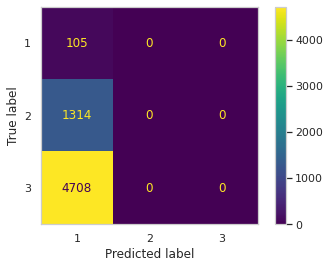

{'LR__C': 1.0}
0.017137261302431858


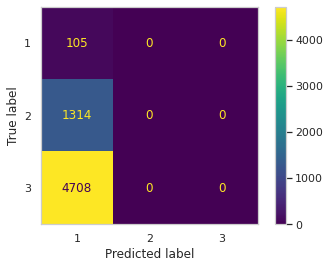

{'DT__criterion': 'gini', 'DT__max_depth': 6, 'DT__min_samples_leaf': 7, 'DT__min_samples_split': 2}
0.7684021543985637


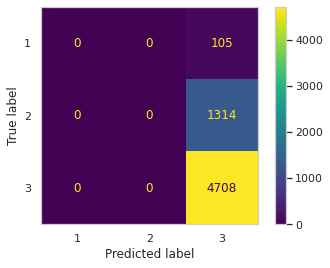

{'RF__max_depth': 1, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}
0.7684021543985637


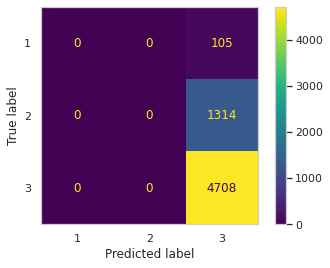

{'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7, 'KNN__weights': 'uniform'}
0.017137261302431858


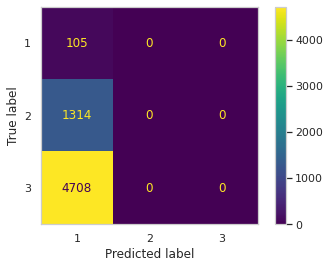

{'XG__max_depth': 4, 'XG__n_estimators': 100}


In [ ]:
#extracting a sample of the dataframe to avoid computation costs
sub_accident = vac_merged.sample(frac=.1, random_state=1)
#columns to be one hot encoded
one_hot = ['left_carriageway?', '1st_Road_Class', 'Road_Type', 'Journey_Purpose_of_Driver', 'Junction_Location','Casualty_Class']
#columns to be ordinal encoded
ordinal = ['Speed_limit','Age_Band_of_Driver', 'Band_of_Engine_Capacity', 'Age_Band_of_Casualty']
sub_accident = sub_accident[one_hot +ordinal +['Accident_Severity']]
X_train, X_test, y_train, y_test = split(sub_accident, 0.4,42, None)
#using smote and imbalance to oversample/undersample
X_train_balanced, y_train_balanced = balance(X_train, y_train, {'1': 300, '2': 2000}, {'3': 7000})

#grid search

grid_search(X_train_balanced, X_test, y_train_balanced, y_test, one_hot, ordinal,lr_param_grid, dt_param_grid, rf_param_grid, knn_param_grid, xg_param_grid)

### Implementing the models on the whole dataset

Train (91894, 67) (91894,)
Test (61264, 67) (61264,)
Counter({'3': 70843, '2': 19342, '1': 1709})
Counter({'3': 70000, '2': 20000, '1': 2000})
Logistic Regression Test Accuracy: 0.018493732044920344


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.02      1.00      0.04      1133
           2       0.00      0.00      0.00     13048
           3       0.00      0.00      0.00     47083

    accuracy                           0.02     61264
   macro avg       0.01      0.33      0.01     61264
weighted avg       0.00      0.02      0.00     61264



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


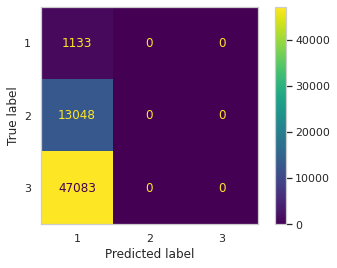

<Figure size 720x720 with 0 Axes>

Decision Trees Test Accuracy: 0.2129798903107861


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1133
           2       0.21      1.00      0.35     13048
           3       0.00      0.00      0.00     47083

    accuracy                           0.21     61264
   macro avg       0.07      0.33      0.12     61264
weighted avg       0.05      0.21      0.07     61264



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


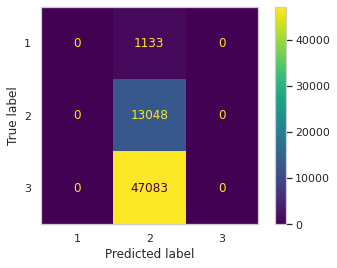

<Figure size 720x720 with 0 Axes>

Random Forest Test Accuracy: 0.7685263776442935


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1133
           2       0.00      0.00      0.00     13048
           3       0.77      1.00      0.87     47083

    accuracy                           0.77     61264
   macro avg       0.26      0.33      0.29     61264
weighted avg       0.59      0.77      0.67     61264



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


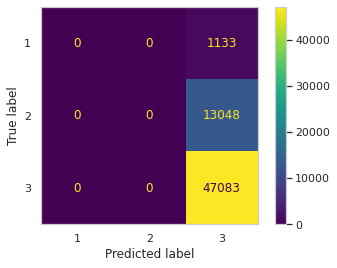

<Figure size 720x720 with 0 Axes>

KNN Test Accuracy: 0.7685263776442935


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1133
           2       0.00      0.00      0.00     13048
           3       0.77      1.00      0.87     47083

    accuracy                           0.77     61264
   macro avg       0.26      0.33      0.29     61264
weighted avg       0.59      0.77      0.67     61264



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


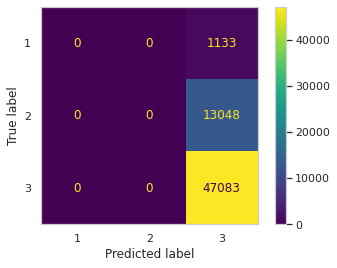

<Figure size 720x720 with 0 Axes>

XG Boost Test Accuracy: 0.2129798903107861


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      1133
           2       0.21      1.00      0.35     13048
           3       0.00      0.00      0.00     47083

    accuracy                           0.21     61264
   macro avg       0.07      0.33      0.12     61264
weighted avg       0.05      0.21      0.07     61264



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


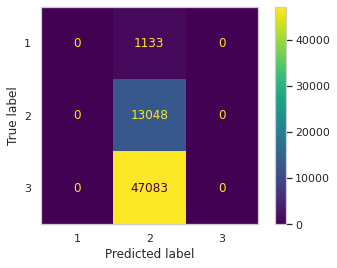

<Figure size 720x720 with 0 Axes>

In [ ]:
vac_merged_copy=replace_y(vac_merged_copy,'Accident_Severity')
#extracting columns
X_train, X_test, y_train, y_test = split(vac_merged_copy, 0.4,42, None)
X_test_copy = X_test.copy()
X_train = X_train[one_hot +ordinal]
X_test = X_test[one_hot+ordinal]
#Before over/undersampling
print(Counter(y_train))
X_train_balanced, y_train_balanced = balance(X_train, y_train, {'1':2000, '2': 20000}, {'3': 70000})
#after over/undersampling
print(Counter(y_train_balanced))

probs = model_fit(X_train_balanced, X_test, y_train_balanced, y_test, one_hot, ordinal,1, 'gini',6,7, 2, 1,1,2,'manhattan',7, 'uniform', 4, 100)

### stacked models output for accidents severity

0.018493732044920344


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.02      1.00      0.04      1133
           2       0.00      0.00      0.00     13048
           3       0.00      0.00      0.00     47083

    accuracy                           0.02     61264
   macro avg       0.01      0.33      0.01     61264
weighted avg       0.00      0.02      0.00     61264



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


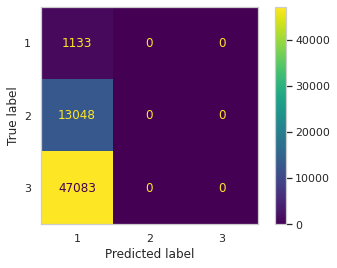

In [ ]:
#output of stacked model
from sklearn.ensemble import StackingClassifier

sev_probs_stacked= stack_models(X_train_balanced, X_test, y_train_balanced, y_test, one_hot, ordinal,1, 'gini',6,7, 2, 1,1,2,'manhattan',7, 'uniform', 4, 100)



### predicting time

In [ ]:
sub_accident = vac_merged.sample(frac=.1, random_state=1)
one_hot = ['left_carriageway?', '1st_Road_Class', 'Road_Type', 'Journey_Purpose_of_Driver', 'Junction_Location','Casualty_Class']
#columns to be ordinal encoded
ordinal = ['Speed_limit','Age_Band_of_Driver', 'Band_of_Engine_Capacity', 'Age_Band_of_Casualty']
sub_accident = sub_accident[one_hot +ordinal +['Day_of_Week']]
X_train, X_test, y_train, y_test = split(sub_accident, 0.4,42, None)

Train (9189, 10) (9189,)
Test (6127, 10) (6127,)


Train (10721, 11) (10721,)
Test (4595, 11) (4595,)
0.16104461371055495


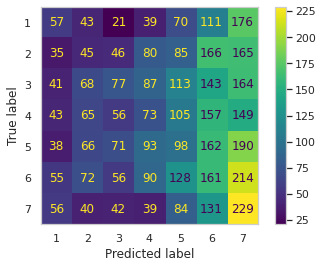

{'LR__C': 0.1}
0.17388465723612623


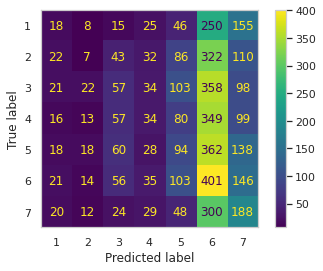

{'DT__criterion': 'gini', 'DT__max_depth': 6, 'DT__min_samples_leaf': 3, 'DT__min_samples_split': 2}
0.17671381936887923


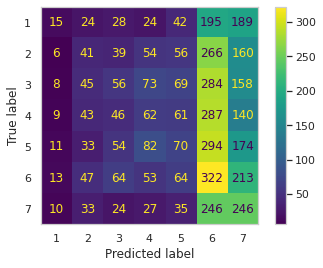

{'RF__max_depth': 7, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}
0.16213275299238303


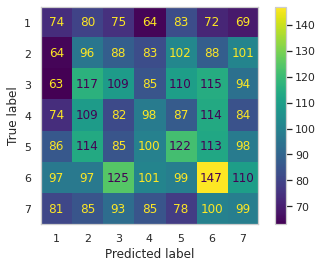

{'KNN__metric': 'manhattan', 'KNN__n_neighbors': 1, 'KNN__weights': 'uniform'}
0.1708378672470076


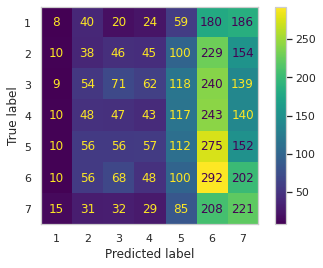

{'XG__max_depth': 1, 'XG__n_estimators': 150}


In [ ]:
#extracting a sample of the dataframe to avoid computation costs
sub_accident = vac_merged.sample(frac=.1, random_state=1)
#columns to be one hot encoded
one_hot = ['left_carriageway?', '1st_Road_Class', 'Road_Type', 'Journey_Purpose_of_Driver', 'Junction_Location','Casualty_Class', 'district_classes']
#columns to be ordinal encoded
ordinal = ['Speed_limit','Age_Band_of_Driver', 'Band_of_Engine_Capacity', 'Age_Band_of_Casualty']
sub_accident = sub_accident[one_hot +ordinal +['Day_of_Week']]
X_train, X_test, y_train, y_test = split(sub_accident, 0.3,42, None)
#grid search

grid_search(X_train, X_test, y_train, y_test, one_hot, ordinal,lr_param_grid, dt_param_grid, rf_param_grid, knn_param_grid, xg_param_grid)

Train (91894, 67) (91894,)
Test (61264, 67) (61264,)
Logistic Regression Test Accuracy: 0.17341342387046227
              precision    recall  f1-score   support

           1       0.19      0.08      0.12      7074
           2       0.14      0.00      0.01      8658
           3       0.18      0.08      0.11      8882
           4       0.17      0.11      0.13      9063
           5       0.17      0.17      0.17      9034
           6       0.17      0.34      0.22     10031
           7       0.18      0.39      0.25      8522

    accuracy                           0.17     61264
   macro avg       0.17      0.17      0.14     61264
weighted avg       0.17      0.17      0.15     61264



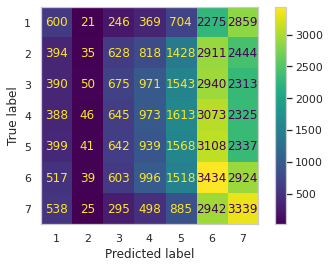

<Figure size 720x720 with 0 Axes>

Decision Trees Test Accuracy: 0.1736909114651345
              precision    recall  f1-score   support

           1       0.17      0.11      0.13      7074
           2       0.12      0.00      0.00      8658
           3       0.20      0.07      0.11      8882
           4       0.18      0.02      0.04      9063
           5       0.18      0.20      0.19      9034
           6       0.16      0.54      0.25     10031
           7       0.20      0.21      0.20      8522

    accuracy                           0.17     61264
   macro avg       0.17      0.17      0.13     61264
weighted avg       0.17      0.17      0.13     61264



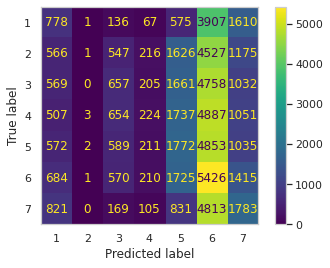

<Figure size 720x720 with 0 Axes>

Random Forest Test Accuracy: 0.16370135805693392


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      7074
           2       0.00      0.00      0.00      8658
           3       0.00      0.00      0.00      8882
           4       0.00      0.00      0.00      9063
           5       0.05      0.00      0.00      9034
           6       0.16      1.00      0.28     10031
           7       0.00      0.00      0.00      8522

    accuracy                           0.16     61264
   macro avg       0.03      0.14      0.04     61264
weighted avg       0.03      0.16      0.05     61264



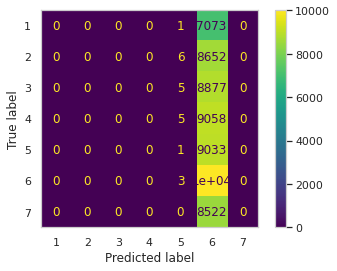

<Figure size 720x720 with 0 Axes>

KNN Test Accuracy: 0.19724471141290154
              precision    recall  f1-score   support

           1       0.19      0.19      0.19      7074
           2       0.18      0.18      0.18      8658
           3       0.20      0.20      0.20      8882
           4       0.20      0.19      0.20      9063
           5       0.19      0.20      0.19      9034
           6       0.21      0.21      0.21     10031
           7       0.21      0.21      0.21      8522

    accuracy                           0.20     61264
   macro avg       0.20      0.20      0.20     61264
weighted avg       0.20      0.20      0.20     61264



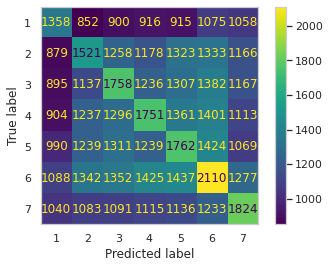

<Figure size 720x720 with 0 Axes>

XG Boost Test Accuracy: 0.17187908069992164


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      7074
           2       0.00      0.00      0.00      8658
           3       0.17      0.09      0.12      8882
           4       0.19      0.05      0.08      9063
           5       0.17      0.14      0.15      9034
           6       0.17      0.53      0.25     10031
           7       0.19      0.31      0.23      8522

    accuracy                           0.17     61264
   macro avg       0.13      0.16      0.12     61264
weighted avg       0.13      0.17      0.13     61264



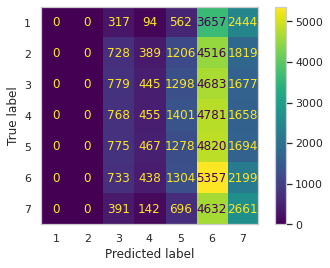

<Figure size 720x720 with 0 Axes>

In [ ]:
vac_merged_copy=replace_y(vac_merged_copy,'Day_of_Week')
#extracting columns
X_train, X_test, y_train, y_test = split(vac_merged_copy, 0.4,42, None)
X_test_copy = X_test.copy()
X_train = X_train[one_hot +ordinal]
X_test = X_test[one_hot+ordinal]

probs = model_fit(X_train, X_test, y_train, y_test, one_hot, ordinal,.1, 'entropy', 6, 3, 2, 7,1,2,'manhattan',1, 'uniform', 1, 150)

##### stacked models output for time

0.19071559153826065
              precision    recall  f1-score   support

           1       0.20      0.18      0.19      7074
           2       0.17      0.13      0.15      8658
           3       0.19      0.18      0.18      8882
           4       0.19      0.16      0.17      9063
           5       0.18      0.17      0.18      9034
           6       0.20      0.19      0.19     10031
           7       0.20      0.33      0.25      8522

    accuracy                           0.19     61264
   macro avg       0.19      0.19      0.19     61264
weighted avg       0.19      0.19      0.19     61264



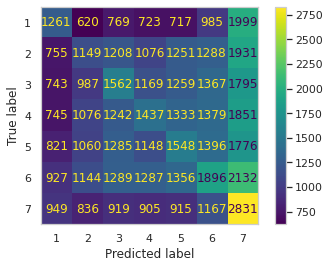

In [ ]:
#output of stacked model
from sklearn.ensemble import StackingClassifier

probs_stacked= stack_models(X_train, X_test, y_train, y_test, one_hot, ordinal,.1, 'entropy', 6, 3, 2, 7,1,2,'manhattan',1, 'uniform', 1, 150)



### Predicting Accident Location


In [ ]:
sub_accident = vac_merged.sample(frac=.1, random_state=1)
one_hot = ['left_carriageway?', '1st_Road_Class', 'Road_Type', 'Journey_Purpose_of_Driver', 'Junction_Location','Casualty_Class']
#columns to be ordinal encoded
ordinal = ['Speed_limit','Age_Band_of_Driver', 'Band_of_Engine_Capacity', 'Age_Band_of_Casualty', 'converted_time_classes', 'Day_of_Week']
sub_accident = sub_accident[one_hot +ordinal +['district_classes']]
X_train, X_test, y_train, y_test = split(sub_accident, 0.3,42, None)

Train (10721, 12) (10721,)
Test (4595, 12) (4595,)


Train (10721, 12) (10721,)
Test (4595, 12) (4595,)
0.31969532100108816


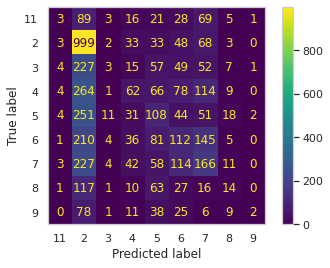

{'LR__C': 0.5}
0.31273122959738847


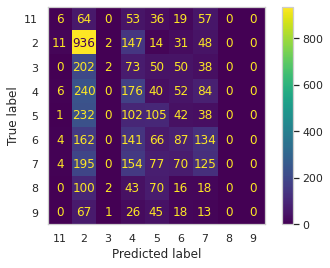

{'DT__criterion': 'gini', 'DT__max_depth': 6, 'DT__min_samples_leaf': 7, 'DT__min_samples_split': 2}
0.3057671381936888


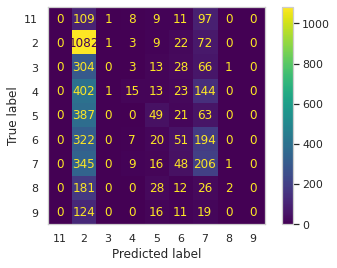

{'RF__max_depth': 7, 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 2}
0.27616974972796515


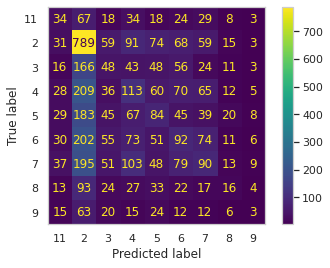

{'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7, 'KNN__weights': 'uniform'}


In [ ]:
#extracting a sample of the dataframe to avoid computation costs
sub_accident = vac_merged.sample(frac=.1, random_state=1)
#columns to be one hot encoded
one_hot = ['left_carriageway?', '1st_Road_Class', 'Road_Type', 'Journey_Purpose_of_Driver', 'Junction_Location','Casualty_Class']
#columns to be ordinal encoded
ordinal = ['Speed_limit','Age_Band_of_Driver', 'Band_of_Engine_Capacity', 'Age_Band_of_Casualty', 'converted_time_classes', 'Day_of_Week']
sub_accident = sub_accident[one_hot +ordinal +['district_classes']]
X_train, X_test, y_train, y_test = split(sub_accident, 0.3,42, None)
#grid search

grid_search(X_train, X_test, y_train, y_test, one_hot, ordinal,lr_param_grid, dt_param_grid, rf_param_grid, knn_param_grid, xg_param_grid)

Train (107210, 67) (107210,)
Test (45948, 67) (45948,)
Logistic Regression Test Accuracy: 0.320296857316967
              precision    recall  f1-score   support

          11       0.42      0.01      0.01      2266
           2       0.40      0.82      0.54     11771
           3       0.32      0.01      0.02      4097
           4       0.22      0.15      0.18      6083
           5       0.21      0.24      0.22      5101
           6       0.23      0.20      0.21      6120
           7       0.26      0.26      0.26      6237
           8       0.44      0.01      0.01      2535
           9       0.33      0.00      0.00      1738

    accuracy                           0.32     45948
   macro avg       0.31      0.19      0.16     45948
weighted avg       0.31      0.32      0.25     45948



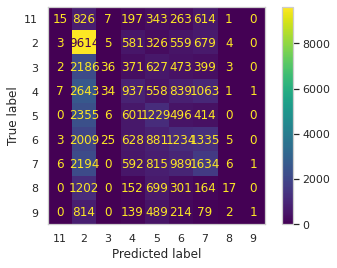

<Figure size 720x720 with 0 Axes>

Decision Trees Test Accuracy: 0.31681466005049186


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          11       0.27      0.00      0.01      2266
           2       0.44      0.76      0.56     11771
           3       0.10      0.00      0.00      4097
           4       0.21      0.32      0.25      6083
           5       0.19      0.19      0.19      5101
           6       0.22      0.19      0.20      6120
           7       0.26      0.24      0.25      6237
           8       0.41      0.00      0.01      2535
           9       0.00      0.00      0.00      1738

    accuracy                           0.32     45948
   macro avg       0.23      0.19      0.16     45948
weighted avg       0.27      0.32      0.26     45948



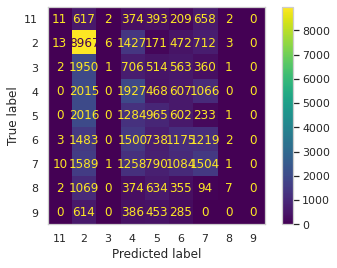

<Figure size 720x720 with 0 Axes>

Random Forest Test Accuracy: 0.2561809001479934


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          11       0.00      0.00      0.00      2266
           2       0.26      1.00      0.41     11771
           3       0.00      0.00      0.00      4097
           4       0.00      0.00      0.00      6083
           5       0.00      0.00      0.00      5101
           6       0.00      0.00      0.00      6120
           7       0.00      0.00      0.00      6237
           8       0.00      0.00      0.00      2535
           9       0.00      0.00      0.00      1738

    accuracy                           0.26     45948
   macro avg       0.03      0.11      0.05     45948
weighted avg       0.07      0.26      0.10     45948



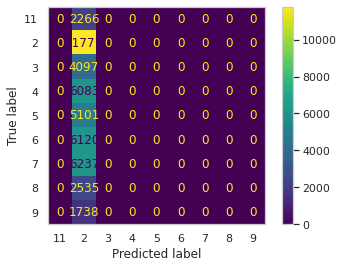

<Figure size 720x720 with 0 Axes>

KNN Test Accuracy: 0.3072386175676852
              precision    recall  f1-score   support

          11       0.18      0.17      0.17      2266
           2       0.44      0.68      0.53     11771
           3       0.17      0.16      0.16      4097
           4       0.21      0.23      0.22      6083
           5       0.23      0.20      0.21      5101
           6       0.24      0.21      0.23      6120
           7       0.26      0.18      0.22      6237
           8       0.20      0.07      0.10      2535
           9       0.19      0.05      0.08      1738

    accuracy                           0.31     45948
   macro avg       0.24      0.22      0.22     45948
weighted avg       0.28      0.31      0.28     45948



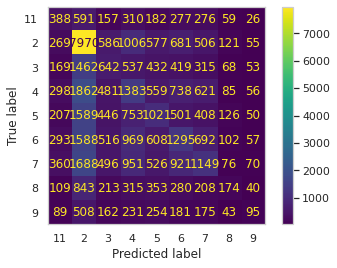

<Figure size 720x720 with 0 Axes>

XG Boost Test Accuracy: 0.33248454774963004
              precision    recall  f1-score   support

          11       0.33      0.04      0.07      2266
           2       0.42      0.81      0.55     11771
           3       0.35      0.01      0.02      4097
           4       0.23      0.17      0.20      6083
           5       0.23      0.20      0.21      5101
           6       0.25      0.24      0.24      6120
           7       0.26      0.32      0.29      6237
           8       0.21      0.03      0.05      2535
           9       0.00      0.00      0.00      1738

    accuracy                           0.33     45948
   macro avg       0.25      0.20      0.18     45948
weighted avg       0.29      0.33      0.27     45948



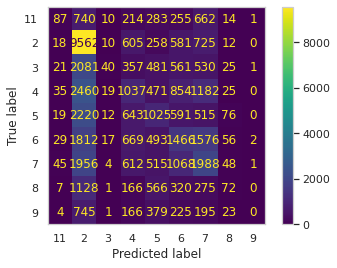

<Figure size 720x720 with 0 Axes>

In [ ]:
vac_merged_copy=replace_y(vac_merged_copy,'district_classes')
#extracting columns
X_train, X_test, y_train, y_test = split(vac_merged_copy, 0.3,42, None)
X_test_copy = X_test.copy()
X_train = X_train[one_hot +ordinal]
X_test = X_test[one_hot+ordinal]

probs = model_fit(X_train, X_test, y_train, y_test, one_hot, ordinal,.5, 'gini', 6,7, 2, 7,1,2,'manhattan',7, 'uniform', 3,150)

##### stacked models output for location

0.34410638112649083
              precision    recall  f1-score   support

          11       0.32      0.09      0.14      2266
           2       0.46      0.76      0.57     11771
           3       0.28      0.05      0.08      4097
           4       0.24      0.23      0.24      6083
           5       0.25      0.24      0.24      5101
           6       0.26      0.27      0.26      6120
           7       0.27      0.30      0.28      6237
           8       0.27      0.07      0.12      2535
           9       0.25      0.04      0.08      1738

    accuracy                           0.34     45948
   macro avg       0.29      0.23      0.22     45948
weighted avg       0.31      0.34      0.30     45948



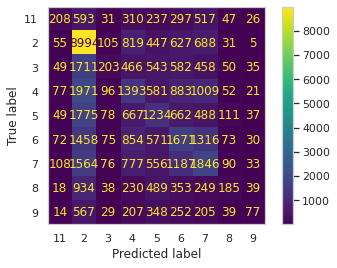

In [ ]:
#output of stacked model
from sklearn.ensemble import StackingClassifier

probs_stacked= stack_models(X_train, X_test, y_train, y_test, one_hot, ordinal,.5, 'gini', 6,7, 2, 7,1,2,'manhattan',7, 'uniform', 3,150)

